In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(font_scale=2)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Sequential

import torch_geometric
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.transforms as T
import torch_cluster

from torch_geometric.nn import NNConv, GCNConv, GraphConv
from torch_geometric.nn import PointConv, EdgeConv, SplineConv

from sklearn.cluster import DBSCAN

In [2]:
torch.cuda.device_count()

4

In [3]:
#device = torch.device('cuda:0')
device = torch.device('cuda:0')

In [4]:
#!pip install --upgrade --force-reinstall torch-sparse && pip install --upgrade --force-reinstall torch-cluster && pip install --upgrade --force-reinstall torch-scatter && pip install --upgrade --force-reinstall torch-spline_conv && pip install --upgrade --force-reinstall torch-geometric

## Download train data

In [5]:
showers_train = torch.load('./data/showers_train.pt')

In [6]:
showers_train = [shower.to(device) for shower in showers_train[:20]]

In [7]:
showers_train[0]

Data(edge_attr=[44065, 1], edge_index=[2, 44065], pos=[8816, 5], x=[8816, 5], y=[8816])

In [8]:
np.unique(showers_train[0].y.cpu().detach().numpy())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

## Features creation

In [9]:
for i in range(len(showers_train)):
    data = showers_train[i].x
    
    shape_0 = data.shape[0]
    
    #azimuthal_angle
    feat_0 = torch.atan(data[:, 1]/data[:, 0]).view(shape_0,1)
    
    feat_1 = (torch.sqrt(torch.pow(data[:, 1], 2) + torch.pow(data[:, 0],2))
              /data[:, 2]).view(shape_0,1)
    
    feat_2 = (data[:, 0]/data[:, 2]).view(shape_0,1)
    
    feat_3 = (data[:, 1]/data[:, 2]).view(shape_0,1)
    
    showers_train[i].x = torch.cat((data, feat_0, feat_1, feat_2, feat_3), 1)

In [10]:
showers_train[0].x.shape

torch.Size([8816, 9])

## Checking weather edges connect hits from the same shower

We need to compare Z-coordinates of each brick layer with our data Z-coordinate

In [11]:
Z = np.array([     0.,   1293.,   2586.,   3879.,   5172.,   6465.,   7758.,
                          9051.,  10344.,  11637.,  12930.,  14223.,  15516.,  16809.,
                         18102.,  19395.,  20688.,  21981.,  23274.,  24567.,  25860.,
                         27153.,  28446.,  29739.,  31032.,  32325.,  33618.,  34911.,
                         36204.,  37497.,  38790.,  40083.,  41376.,  42669.,  43962.,
                         45255.,  46548.,  47841.,  49134.,  50427.,  51720.,  53013.,
                         54306.,  55599.,  56892.,  58185.,  59478.,  60771.,  62064.,
                         63357.,  64650.,  65943.,  67236.,  68529.,  69822.,  71115.,
                         72408.,  73701.])

In [12]:
Z_centered = Z - 73701. / 2

In [13]:
Z_centered

array([-36850.5, -35557.5, -34264.5, -32971.5, -31678.5, -30385.5,
       -29092.5, -27799.5, -26506.5, -25213.5, -23920.5, -22627.5,
       -21334.5, -20041.5, -18748.5, -17455.5, -16162.5, -14869.5,
       -13576.5, -12283.5, -10990.5,  -9697.5,  -8404.5,  -7111.5,
        -5818.5,  -4525.5,  -3232.5,  -1939.5,   -646.5,    646.5,
         1939.5,   3232.5,   4525.5,   5818.5,   7111.5,   8404.5,
         9697.5,  10990.5,  12283.5,  13576.5,  14869.5,  16162.5,
        17455.5,  18748.5,  20041.5,  21334.5,  22627.5,  23920.5,
        25213.5,  26506.5,  27799.5,  29092.5,  30385.5,  31678.5,
        32971.5,  34264.5,  35557.5,  36850.5])

In [14]:
Z_0 = np.array(showers_train[0].x[:, 2].cpu())*np.array([1e4])

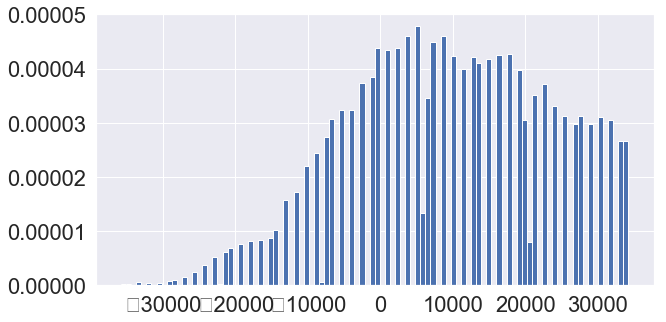

In [15]:
plt.figure(figsize=(10, 5))
# the histogram of the data
plt.hist(Z_0, 100, density=True)

plt.grid(True)
plt.show()


## Masks for activating only those edges that are connecting the same shower

In [16]:
def round_Z_coodr(x):
        return Z_centered[np.argmin(np.abs(Z_centered - x))]
round_Z_coodr = np.vectorize(round_Z_coodr)
    
def mask(data):
    x = data.x[:, 2]
    
    Z_0 = np.array(x.cpu()) * np.array([1e4])
    
    z_rounded = round_Z_coodr(Z_0)
    
    orders = np.zeros((len(Z_centered), data.edge_index.shape[1]))

    for i, z_i in enumerate(Z_centered):
        for j, z_0_i in enumerate(z_rounded):
            if z_0_i == z_i:
                # TODO data.edge_index[0] vs data.edge_index[1]
                orders[i][(data.edge_index[0] == j).cpu().numpy().astype(bool)] = 1
            
    return orders.astype(np.uint8)

In [17]:
masks = []
for i in range(len(showers_train)):
    masks.append(mask(showers_train[i]))

## GNN 

In [18]:
class EmulsionConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')
        self.mp = torch.nn.Linear(in_channels * 2, out_channels)
        
    def forward(self, x, edge_index, orders):
        for order in orders: 
            x = self.propagate('add', 
                               torch.index_select(edge_index[:, torch.ByteTensor(order)], 
                                                  0, 
                                                  torch.LongTensor([1, 0]).to(device)), x=x)     
        return x

    def message(self, x_j, x_i):
        return self.mp(torch.cat([x_i, x_j - x_i], dim=1))

    def update(self, aggr_out, x):
        return aggr_out + x

In [19]:
class GraphNN_KNN(torch.nn.Module):
    def __init__(self, k=9, dim_out=10):
        super().__init__()
        self.k = k
        self.emconv = EmulsionConv(self.k, dim_out)
        
        
    def forward(self, data, mask):
        x, edge_index, orders = data.x, data.edge_index, mask
        x = self.emconv(x=x, edge_index=edge_index, orders=orders)
        return x

In [20]:
model = GraphNN_KNN(dim_out=9).to(device)

In [21]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

----------------

In [ ]:
#embeddings = model(showers_train[0], masks[0])

In [ ]:
#edge_classifier = nn.Linear(18, 2)

In [ ]:
#edge_labels = (showers_train[0].y[showers_train[0].edge_index[0]] == showers_train[0].y[showers_train[0].edge_index[1]])

In [ ]:
#edge_labels.shape

In [ ]:
#edge_data = torch.cat([embeddings[showers_train[0].edge_index[0]], embeddings[showers_train[0].edge_index[1]]], dim=1)

In [ ]:
#edge_data.shape

In [ ]:
#edge_labels.to(torch.int64)

In [ ]:
#loss = F.nll_loss(edge_classifier(edge_data), edge_labels.to(torch.int64))

In [23]:
criterion = nn.BCELoss()
edge_classifier = nn.Sequential(nn.Linear(18, 9),
                                nn.ReLU(),
                                nn.Linear(9, 1),
                                nn.Sigmoid()).to(device)


from tqdm import tqdm
for i in tqdm(range(10000)):
    mask = masks[i % len(showers_train)]
    shower = showers_train[i % len(showers_train)]
    
    optimizer.zero_grad()
    
    embeddings = model(shower, mask)
 
    
    edge_labels = (shower.y[shower.edge_index[0]] 
                   == shower.y[shower.edge_index[1]])  
    
    
    
    edge_data = torch.cat([embeddings[shower.edge_index[0]], 
                           embeddings[shower.edge_index[1]]], dim=1)
    

    loss = criterion(edge_classifier(edge_data).view(-1), edge_labels.view(-1).float())
    
    
    loss.backward()
    
    
    print(loss)
    
    optimizer.step()
    


  0%|          | 2/10000 [00:00<18:02,  9.23it/s]

tensor(1.1779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.2919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 4/10000 [00:00<18:21,  9.07it/s]

tensor(0.9102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.1423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 6/10000 [00:00<18:15,  9.12it/s]

tensor(1.2679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 8/10000 [00:00<18:11,  9.15it/s]

tensor(1.1318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.1995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 10/10000 [00:01<18:15,  9.12it/s]

tensor(0.8709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.1146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 12/10000 [00:01<18:11,  9.15it/s]

tensor(1.1395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 14/10000 [00:01<18:37,  8.93it/s]

tensor(1.0875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.1009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 16/10000 [00:01<19:20,  8.60it/s]

tensor(0.8482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.0633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 18/10000 [00:02<18:45,  8.87it/s]

tensor(1.0587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 20/10000 [00:02<18:14,  9.12it/s]

tensor(1.0502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.0384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 22/10000 [00:02<18:17,  9.09it/s]

tensor(0.8406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.0293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 24/10000 [00:02<18:03,  9.21it/s]

tensor(1.0135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 26/10000 [00:02<17:50,  9.32it/s]

tensor(1.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 28/10000 [00:03<18:11,  9.14it/s]

tensor(0.8201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 30/10000 [00:03<18:02,  9.21it/s]

tensor(0.9871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 32/10000 [00:03<18:41,  8.89it/s]

tensor(0.9689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 34/10000 [00:03<18:45,  8.86it/s]

tensor(0.8039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 36/10000 [00:03<18:40,  8.90it/s]

tensor(0.9674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 38/10000 [00:04<18:27,  8.99it/s]

tensor(0.9449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 40/10000 [00:04<18:50,  8.81it/s]

tensor(0.7888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 42/10000 [00:04<19:00,  8.73it/s]

tensor(0.9364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 44/10000 [00:04<18:54,  8.77it/s]

tensor(0.9196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 46/10000 [00:05<19:15,  8.62it/s]

tensor(0.7783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 48/10000 [00:05<19:03,  8.70it/s]

tensor(0.9204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  0%|          | 50/10000 [00:05<18:43,  8.86it/s]

tensor(0.8864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 52/10000 [00:05<18:47,  8.83it/s]

tensor(0.7698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 54/10000 [00:06<18:42,  8.86it/s]

tensor(0.9038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 56/10000 [00:06<18:24,  9.00it/s]

tensor(0.8732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.9034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 58/10000 [00:06<18:24,  9.00it/s]

tensor(0.7546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 60/10000 [00:06<18:14,  9.08it/s]

tensor(0.8936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 62/10000 [00:06<18:11,  9.11it/s]

tensor(0.8568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 64/10000 [00:07<18:08,  9.13it/s]

tensor(0.7480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 66/10000 [00:07<17:55,  9.24it/s]

tensor(0.8844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 68/10000 [00:07<17:47,  9.31it/s]

tensor(0.8451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 70/10000 [00:07<17:56,  9.22it/s]

tensor(0.7425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 72/10000 [00:07<17:53,  9.25it/s]

tensor(0.8719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 74/10000 [00:08<18:12,  9.09it/s]

tensor(0.8341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 76/10000 [00:08<18:32,  8.92it/s]

tensor(0.7372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 78/10000 [00:08<18:13,  9.08it/s]

tensor(0.8623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 80/10000 [00:08<18:03,  9.15it/s]

tensor(0.8252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 82/10000 [00:09<18:18,  9.03it/s]

tensor(0.7335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 84/10000 [00:09<18:12,  9.07it/s]

tensor(0.8542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 86/10000 [00:09<18:33,  8.90it/s]

tensor(0.8167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 88/10000 [00:09<18:54,  8.74it/s]

tensor(0.7303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 90/10000 [00:10<18:31,  8.92it/s]

tensor(0.8476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 92/10000 [00:10<18:10,  9.09it/s]

tensor(0.8100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 94/10000 [00:10<18:08,  9.10it/s]

tensor(0.7274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 96/10000 [00:10<18:12,  9.06it/s]

tensor(0.8416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 98/10000 [00:10<18:38,  8.86it/s]

tensor(0.8036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 100/10000 [00:11<18:19,  9.00it/s]

tensor(0.7247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 102/10000 [00:11<18:21,  8.99it/s]

tensor(0.8360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 104/10000 [00:11<18:24,  8.96it/s]

tensor(0.7978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 106/10000 [00:11<18:16,  9.02it/s]

tensor(0.7218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 108/10000 [00:12<18:28,  8.93it/s]

tensor(0.8315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 110/10000 [00:12<18:33,  8.88it/s]

tensor(0.7924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 112/10000 [00:12<18:41,  8.81it/s]

tensor(0.7193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 114/10000 [00:12<18:06,  9.10it/s]

tensor(0.8274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 116/10000 [00:12<17:54,  9.20it/s]

tensor(0.7872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 118/10000 [00:13<17:53,  9.21it/s]

tensor(0.7169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 120/10000 [00:13<17:55,  9.19it/s]

tensor(0.8235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 122/10000 [00:13<17:38,  9.33it/s]

tensor(0.7828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|          | 124/10000 [00:13<17:53,  9.20it/s]

tensor(0.7145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 126/10000 [00:13<17:39,  9.32it/s]

tensor(0.8197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 128/10000 [00:14<17:34,  9.36it/s]

tensor(0.7787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 130/10000 [00:14<17:59,  9.14it/s]

tensor(0.7121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 132/10000 [00:14<18:18,  8.98it/s]

tensor(0.8163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 134/10000 [00:14<17:45,  9.26it/s]

tensor(0.7746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 136/10000 [00:15<17:41,  9.29it/s]

tensor(0.7098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 138/10000 [00:15<17:29,  9.40it/s]

tensor(0.8121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 140/10000 [00:15<17:19,  9.48it/s]

tensor(0.7747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 142/10000 [00:15<17:32,  9.36it/s]

tensor(0.7080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 144/10000 [00:15<17:22,  9.45it/s]

tensor(0.8091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 146/10000 [00:16<17:23,  9.44it/s]

tensor(0.7720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  1%|▏         | 148/10000 [00:16<17:33,  9.35it/s]

tensor(0.7063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 150/10000 [00:16<17:20,  9.46it/s]

tensor(0.8055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 152/10000 [00:16<17:14,  9.52it/s]

tensor(0.7696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 154/10000 [00:16<17:21,  9.46it/s]

tensor(0.7044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 156/10000 [00:17<17:24,  9.42it/s]

tensor(0.8029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 158/10000 [00:17<17:11,  9.54it/s]

tensor(0.7663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 160/10000 [00:17<17:26,  9.40it/s]

tensor(0.7026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7646, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 162/10000 [00:17<17:18,  9.48it/s]

tensor(0.8001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 164/10000 [00:18<17:06,  9.58it/s]

tensor(0.7631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 166/10000 [00:18<17:47,  9.21it/s]

tensor(0.7008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 168/10000 [00:18<17:41,  9.26it/s]

tensor(0.7974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 170/10000 [00:18<17:29,  9.36it/s]

tensor(0.7600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 172/10000 [00:18<17:37,  9.29it/s]

tensor(0.6988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 174/10000 [00:19<17:30,  9.36it/s]

tensor(0.7951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 176/10000 [00:19<17:24,  9.40it/s]

tensor(0.7570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 178/10000 [00:19<17:33,  9.32it/s]

tensor(0.6975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 180/10000 [00:19<17:31,  9.34it/s]

tensor(0.7924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 182/10000 [00:19<17:22,  9.41it/s]

tensor(0.7540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 184/10000 [00:20<17:31,  9.34it/s]

tensor(0.6960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 186/10000 [00:20<17:40,  9.26it/s]

tensor(0.7894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 188/10000 [00:20<17:53,  9.14it/s]

tensor(0.7512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 190/10000 [00:20<18:01,  9.07it/s]

tensor(0.6943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 192/10000 [00:21<17:45,  9.21it/s]

tensor(0.7874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 194/10000 [00:21<17:53,  9.14it/s]

tensor(0.7487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 196/10000 [00:21<18:25,  8.87it/s]

tensor(0.6929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 198/10000 [00:21<18:28,  8.84it/s]

tensor(0.7855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 200/10000 [00:21<18:02,  9.05it/s]

tensor(0.7464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 202/10000 [00:22<18:23,  8.88it/s]

tensor(0.6911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 204/10000 [00:22<18:06,  9.02it/s]

tensor(0.7832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 206/10000 [00:22<17:46,  9.18it/s]

tensor(0.7438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 208/10000 [00:22<18:02,  9.04it/s]

tensor(0.6896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 210/10000 [00:23<18:00,  9.06it/s]

tensor(0.7813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 212/10000 [00:23<17:47,  9.17it/s]

tensor(0.7409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 214/10000 [00:23<17:50,  9.14it/s]

tensor(0.6880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 216/10000 [00:23<17:45,  9.18it/s]

tensor(0.7793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 218/10000 [00:23<17:44,  9.19it/s]

tensor(0.7373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 220/10000 [00:24<17:54,  9.10it/s]

tensor(0.6866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 222/10000 [00:24<18:03,  9.02it/s]

tensor(0.7782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 224/10000 [00:24<17:47,  9.16it/s]

tensor(0.7326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 226/10000 [00:24<17:50,  9.13it/s]

tensor(0.6840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 228/10000 [00:25<17:53,  9.10it/s]

tensor(0.7755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 230/10000 [00:25<17:37,  9.24it/s]

tensor(0.7314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 232/10000 [00:25<17:42,  9.19it/s]

tensor(0.6830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 234/10000 [00:25<18:32,  8.78it/s]

tensor(0.7739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 236/10000 [00:25<19:10,  8.48it/s]

tensor(0.7296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 238/10000 [00:26<18:26,  8.83it/s]

tensor(0.6811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 240/10000 [00:26<20:00,  8.13it/s]

tensor(0.7728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 242/10000 [00:26<18:28,  8.80it/s]

tensor(0.7266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 244/10000 [00:26<17:59,  9.03it/s]

tensor(0.6798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 246/10000 [00:27<17:36,  9.24it/s]

tensor(0.7701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▏         | 248/10000 [00:27<17:16,  9.41it/s]

tensor(0.7246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  2%|▎         | 250/10000 [00:27<17:26,  9.31it/s]

tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 252/10000 [00:27<17:20,  9.37it/s]

tensor(0.7694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 254/10000 [00:27<17:13,  9.43it/s]

tensor(0.7211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 256/10000 [00:28<17:20,  9.37it/s]

tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 258/10000 [00:28<17:14,  9.42it/s]

tensor(0.7680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 260/10000 [00:28<17:10,  9.45it/s]

tensor(0.7199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 262/10000 [00:28<17:22,  9.35it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 264/10000 [00:28<17:49,  9.10it/s]

tensor(0.7664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 266/10000 [00:29<18:24,  8.81it/s]

tensor(0.7173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 268/10000 [00:29<18:06,  8.96it/s]

tensor(0.6758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 270/10000 [00:29<17:37,  9.20it/s]

tensor(0.7652, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 272/10000 [00:29<17:30,  9.26it/s]

tensor(0.7146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 274/10000 [00:30<17:39,  9.18it/s]

tensor(0.6747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 276/10000 [00:30<17:47,  9.11it/s]

tensor(0.7643, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6738, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 278/10000 [00:30<17:36,  9.20it/s]

tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 280/10000 [00:30<17:39,  9.18it/s]

tensor(0.6737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 282/10000 [00:30<17:33,  9.23it/s]

tensor(0.7633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 284/10000 [00:31<17:21,  9.33it/s]

tensor(0.7085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 286/10000 [00:31<17:51,  9.07it/s]

tensor(0.6719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 288/10000 [00:31<17:48,  9.09it/s]

tensor(0.7615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 290/10000 [00:31<17:25,  9.29it/s]

tensor(0.7062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 292/10000 [00:32<17:26,  9.28it/s]

tensor(0.6713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 294/10000 [00:32<17:11,  9.41it/s]

tensor(0.7595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 296/10000 [00:32<17:00,  9.51it/s]

tensor(0.7039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 298/10000 [00:32<17:23,  9.30it/s]

tensor(0.6694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 300/10000 [00:32<17:26,  9.26it/s]

tensor(0.7581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 302/10000 [00:33<17:09,  9.42it/s]

tensor(0.7022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 304/10000 [00:33<17:16,  9.35it/s]

tensor(0.6682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 306/10000 [00:33<17:11,  9.40it/s]

tensor(0.7566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 308/10000 [00:33<17:11,  9.40it/s]

tensor(0.7004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 310/10000 [00:33<17:35,  9.18it/s]

tensor(0.6669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 312/10000 [00:34<17:21,  9.30it/s]

tensor(0.7560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 314/10000 [00:34<17:12,  9.38it/s]

tensor(0.6991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 316/10000 [00:34<17:37,  9.16it/s]

tensor(0.6656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 318/10000 [00:34<17:35,  9.17it/s]

tensor(0.7540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 320/10000 [00:35<17:22,  9.29it/s]

tensor(0.6974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 322/10000 [00:35<17:26,  9.25it/s]

tensor(0.6639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 324/10000 [00:35<17:21,  9.29it/s]

tensor(0.7529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 326/10000 [00:35<17:33,  9.19it/s]

tensor(0.6962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 328/10000 [00:35<17:27,  9.23it/s]

tensor(0.6631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 330/10000 [00:36<17:21,  9.29it/s]

tensor(0.7519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 332/10000 [00:36<17:20,  9.30it/s]

tensor(0.6950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 334/10000 [00:36<17:30,  9.20it/s]

tensor(0.6620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 336/10000 [00:36<17:29,  9.21it/s]

tensor(0.7506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 338/10000 [00:36<17:20,  9.28it/s]

tensor(0.6937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 340/10000 [00:37<17:34,  9.16it/s]

tensor(0.6611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 342/10000 [00:37<17:36,  9.14it/s]

tensor(0.7493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 344/10000 [00:37<17:25,  9.23it/s]

tensor(0.6925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 346/10000 [00:37<17:36,  9.14it/s]

tensor(0.6601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  3%|▎         | 348/10000 [00:38<17:38,  9.12it/s]

tensor(0.7485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 350/10000 [00:38<17:28,  9.20it/s]

tensor(0.6913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 352/10000 [00:38<17:41,  9.09it/s]

tensor(0.6587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 354/10000 [00:38<17:23,  9.25it/s]

tensor(0.7473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 356/10000 [00:38<17:10,  9.36it/s]

tensor(0.6901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 358/10000 [00:39<17:14,  9.32it/s]

tensor(0.6576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 360/10000 [00:39<17:02,  9.42it/s]

tensor(0.7461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 362/10000 [00:39<16:51,  9.53it/s]

tensor(0.6888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 364/10000 [00:39<17:09,  9.36it/s]

tensor(0.6565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 366/10000 [00:40<17:00,  9.44it/s]

tensor(0.7451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 368/10000 [00:40<16:57,  9.46it/s]

tensor(0.6874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 370/10000 [00:40<17:06,  9.39it/s]

tensor(0.6556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 372/10000 [00:40<16:59,  9.44it/s]

tensor(0.7444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▎         | 374/10000 [00:40<16:52,  9.51it/s]

tensor(0.6862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 376/10000 [00:41<17:20,  9.25it/s]

tensor(0.6545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 378/10000 [00:41<17:07,  9.36it/s]

tensor(0.7429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 380/10000 [00:41<17:01,  9.42it/s]

tensor(0.6852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 382/10000 [00:41<17:14,  9.30it/s]

tensor(0.6534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 384/10000 [00:41<17:04,  9.39it/s]

tensor(0.7420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 386/10000 [00:42<16:57,  9.44it/s]

tensor(0.6838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 388/10000 [00:42<17:26,  9.18it/s]

tensor(0.6522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 390/10000 [00:42<17:24,  9.20it/s]

tensor(0.7402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 392/10000 [00:42<17:09,  9.33it/s]

tensor(0.6825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 394/10000 [00:43<17:24,  9.20it/s]

tensor(0.6506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 396/10000 [00:43<17:13,  9.29it/s]

tensor(0.7389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 398/10000 [00:43<16:59,  9.41it/s]

tensor(0.6815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 400/10000 [00:43<17:10,  9.32it/s]

tensor(0.6491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 402/10000 [00:43<17:06,  9.35it/s]

tensor(0.7367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 404/10000 [00:44<17:08,  9.33it/s]

tensor(0.6806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 406/10000 [00:44<17:19,  9.23it/s]

tensor(0.6474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 408/10000 [00:44<17:23,  9.19it/s]

tensor(0.7351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 410/10000 [00:44<17:35,  9.08it/s]

tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 412/10000 [00:44<17:39,  9.05it/s]

tensor(0.6454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 414/10000 [00:45<17:37,  9.06it/s]

tensor(0.7338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 416/10000 [00:45<17:22,  9.19it/s]

tensor(0.6787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 418/10000 [00:45<17:41,  9.02it/s]

tensor(0.6439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 420/10000 [00:45<17:14,  9.26it/s]

tensor(0.7318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 422/10000 [00:46<17:00,  9.39it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 424/10000 [00:46<17:16,  9.24it/s]

tensor(0.6422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 426/10000 [00:46<17:19,  9.21it/s]

tensor(0.7303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 428/10000 [00:46<17:09,  9.29it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 430/10000 [00:46<17:18,  9.22it/s]

tensor(0.6408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 432/10000 [00:47<17:14,  9.25it/s]

tensor(0.7281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 434/10000 [00:47<17:18,  9.21it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 436/10000 [00:47<17:28,  9.12it/s]

tensor(0.6400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6748, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 438/10000 [00:47<17:23,  9.16it/s]

tensor(0.7271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 440/10000 [00:48<17:08,  9.29it/s]

tensor(0.6741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 442/10000 [00:48<17:22,  9.17it/s]

tensor(0.6389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 444/10000 [00:48<17:30,  9.10it/s]

tensor(0.7261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 446/10000 [00:48<17:35,  9.05it/s]

tensor(0.6728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 448/10000 [00:48<17:43,  8.99it/s]

tensor(0.6380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  4%|▍         | 450/10000 [00:49<17:39,  9.01it/s]

tensor(0.7248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 452/10000 [00:49<17:34,  9.06it/s]

tensor(0.6715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 454/10000 [00:49<17:39,  9.01it/s]

tensor(0.6368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 456/10000 [00:49<17:29,  9.09it/s]

tensor(0.7229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 458/10000 [00:49<17:17,  9.20it/s]

tensor(0.6705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 460/10000 [00:50<17:31,  9.07it/s]

tensor(0.6357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 462/10000 [00:50<17:23,  9.14it/s]

tensor(0.7220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 464/10000 [00:50<17:16,  9.20it/s]

tensor(0.6697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 466/10000 [00:50<17:26,  9.11it/s]

tensor(0.6347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 468/10000 [00:51<17:20,  9.16it/s]

tensor(0.7212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 470/10000 [00:51<17:14,  9.21it/s]

tensor(0.6680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 472/10000 [00:51<17:26,  9.11it/s]

tensor(0.6340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 474/10000 [00:51<17:17,  9.18it/s]

tensor(0.7199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 476/10000 [00:51<17:04,  9.30it/s]

tensor(0.6675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 478/10000 [00:52<17:28,  9.08it/s]

tensor(0.6334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 480/10000 [00:52<17:50,  8.89it/s]

tensor(0.7194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 482/10000 [00:52<17:39,  8.98it/s]

tensor(0.6661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 484/10000 [00:52<18:02,  8.79it/s]

tensor(0.6328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 486/10000 [00:53<17:46,  8.92it/s]

tensor(0.7185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 488/10000 [00:53<17:21,  9.13it/s]

tensor(0.6646, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 490/10000 [00:53<17:24,  9.11it/s]

tensor(0.6320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 492/10000 [00:53<17:09,  9.24it/s]

tensor(0.7177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 494/10000 [00:53<17:04,  9.28it/s]

tensor(0.6638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 496/10000 [00:54<17:20,  9.13it/s]

tensor(0.6314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▍         | 498/10000 [00:54<17:12,  9.20it/s]

tensor(0.7166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 500/10000 [00:54<16:57,  9.34it/s]

tensor(0.6628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 502/10000 [00:54<17:08,  9.23it/s]

tensor(0.6307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 504/10000 [00:55<16:58,  9.32it/s]

tensor(0.7154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 506/10000 [00:55<16:58,  9.32it/s]

tensor(0.6614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 508/10000 [00:55<17:06,  9.25it/s]

tensor(0.6301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 510/10000 [00:55<17:01,  9.29it/s]

tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 512/10000 [00:55<17:09,  9.22it/s]

tensor(0.6603, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 514/10000 [00:56<17:44,  8.92it/s]

tensor(0.6294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 516/10000 [00:56<18:28,  8.55it/s]

tensor(0.7138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 518/10000 [00:56<17:58,  8.79it/s]

tensor(0.6590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 520/10000 [00:56<18:01,  8.76it/s]

tensor(0.6288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 522/10000 [00:57<17:45,  8.89it/s]

tensor(0.7127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 524/10000 [00:57<17:45,  8.89it/s]

tensor(0.6585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 526/10000 [00:57<17:57,  8.80it/s]

tensor(0.6278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 528/10000 [00:57<17:42,  8.91it/s]

tensor(0.7122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 530/10000 [00:57<17:24,  9.07it/s]

tensor(0.6571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 532/10000 [00:58<17:29,  9.02it/s]

tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 534/10000 [00:58<17:31,  9.00it/s]

tensor(0.7110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 536/10000 [00:58<17:08,  9.21it/s]

tensor(0.6567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 538/10000 [00:58<17:21,  9.08it/s]

tensor(0.6263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 540/10000 [00:59<17:08,  9.20it/s]

tensor(0.7106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 542/10000 [00:59<16:57,  9.29it/s]

tensor(0.6561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 544/10000 [00:59<17:24,  9.05it/s]

tensor(0.6253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 546/10000 [00:59<17:09,  9.18it/s]

tensor(0.7101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  5%|▌         | 548/10000 [00:59<16:58,  9.28it/s]

tensor(0.6553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 550/10000 [01:00<17:16,  9.11it/s]

tensor(0.6245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 552/10000 [01:00<17:32,  8.98it/s]

tensor(0.7095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 554/10000 [01:00<17:28,  9.01it/s]

tensor(0.6538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 556/10000 [01:00<17:27,  9.01it/s]

tensor(0.6241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 558/10000 [01:01<17:11,  9.15it/s]

tensor(0.7089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 560/10000 [01:01<17:02,  9.24it/s]

tensor(0.6529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 562/10000 [01:01<17:11,  9.15it/s]

tensor(0.6235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 564/10000 [01:01<17:04,  9.21it/s]

tensor(0.7083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 566/10000 [01:01<17:06,  9.19it/s]

tensor(0.6520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 568/10000 [01:02<16:58,  9.26it/s]

tensor(0.6230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 570/10000 [01:02<16:40,  9.42it/s]

tensor(0.7076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 572/10000 [01:02<16:43,  9.39it/s]

tensor(0.6509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 574/10000 [01:02<16:53,  9.30it/s]

tensor(0.6221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 576/10000 [01:02<16:50,  9.33it/s]

tensor(0.7069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 578/10000 [01:03<16:38,  9.44it/s]

tensor(0.6499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 580/10000 [01:03<16:41,  9.40it/s]

tensor(0.6215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 582/10000 [01:03<16:36,  9.45it/s]

tensor(0.7062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 584/10000 [01:03<16:39,  9.42it/s]

tensor(0.6489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 586/10000 [01:04<16:52,  9.30it/s]

tensor(0.6211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 588/10000 [01:04<16:55,  9.27it/s]

tensor(0.7055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 590/10000 [01:04<16:55,  9.27it/s]

tensor(0.6481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 592/10000 [01:04<17:16,  9.08it/s]

tensor(0.6206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 594/10000 [01:04<17:07,  9.16it/s]

tensor(0.7047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 596/10000 [01:05<16:56,  9.25it/s]

tensor(0.6470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 598/10000 [01:05<17:20,  9.04it/s]

tensor(0.6201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 600/10000 [01:05<17:13,  9.09it/s]

tensor(0.7040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 602/10000 [01:05<16:59,  9.21it/s]

tensor(0.6463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 604/10000 [01:05<17:18,  9.05it/s]

tensor(0.6196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 606/10000 [01:06<17:34,  8.91it/s]

tensor(0.7035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 608/10000 [01:06<17:13,  9.09it/s]

tensor(0.6461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 610/10000 [01:06<17:07,  9.14it/s]

tensor(0.6191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 612/10000 [01:06<17:05,  9.15it/s]

tensor(0.7031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 614/10000 [01:07<16:59,  9.21it/s]

tensor(0.6448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 616/10000 [01:07<17:00,  9.19it/s]

tensor(0.6184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 618/10000 [01:07<17:03,  9.17it/s]

tensor(0.7024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 620/10000 [01:07<16:53,  9.26it/s]

tensor(0.6442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 622/10000 [01:07<17:02,  9.17it/s]

tensor(0.6179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▌         | 624/10000 [01:08<16:56,  9.22it/s]

tensor(0.7019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 626/10000 [01:08<16:45,  9.32it/s]

tensor(0.6433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 628/10000 [01:08<16:59,  9.20it/s]

tensor(0.6174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 630/10000 [01:08<17:04,  9.15it/s]

tensor(0.7015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 632/10000 [01:09<16:58,  9.20it/s]

tensor(0.6426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 634/10000 [01:09<16:59,  9.18it/s]

tensor(0.6167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 636/10000 [01:09<16:48,  9.28it/s]

tensor(0.7003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 638/10000 [01:09<16:43,  9.33it/s]

tensor(0.6418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 640/10000 [01:09<17:30,  8.91it/s]

tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 642/10000 [01:10<17:17,  9.02it/s]

tensor(0.6998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 644/10000 [01:10<17:00,  9.16it/s]

tensor(0.6411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 646/10000 [01:10<16:57,  9.19it/s]

tensor(0.6157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 648/10000 [01:10<16:53,  9.23it/s]

tensor(0.6989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  6%|▋         | 650/10000 [01:10<16:45,  9.30it/s]

tensor(0.6407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 652/10000 [01:11<16:55,  9.21it/s]

tensor(0.6153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 653/10000 [01:11<16:36,  9.38it/s]

tensor(0.6985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 654/10000 [01:11<22:29,  6.92it/s]


tensor(0.6150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


  7%|▋         | 657/10000 [01:11<21:16,  7.32it/s]

tensor(0.6982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 659/10000 [01:12<18:55,  8.23it/s]

tensor(0.6394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 661/10000 [01:12<17:55,  8.68it/s]

tensor(0.6145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 663/10000 [01:12<17:22,  8.95it/s]

tensor(0.6979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 665/10000 [01:12<17:01,  9.14it/s]

tensor(0.6387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 667/10000 [01:13<17:05,  9.10it/s]

tensor(0.6140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 669/10000 [01:13<16:53,  9.21it/s]

tensor(0.6972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 671/10000 [01:13<16:45,  9.27it/s]

tensor(0.6375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 673/10000 [01:13<16:53,  9.20it/s]

tensor(0.6136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 675/10000 [01:13<16:41,  9.31it/s]

tensor(0.6966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 677/10000 [01:14<16:38,  9.34it/s]

tensor(0.6382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 679/10000 [01:14<16:42,  9.30it/s]

tensor(0.6130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 681/10000 [01:14<16:35,  9.36it/s]

tensor(0.6963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 683/10000 [01:14<16:34,  9.37it/s]

tensor(0.6367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 685/10000 [01:15<17:07,  9.06it/s]

tensor(0.6124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 687/10000 [01:15<16:50,  9.22it/s]

tensor(0.6959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 689/10000 [01:15<16:29,  9.41it/s]

tensor(0.6356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 691/10000 [01:15<16:43,  9.28it/s]

tensor(0.6120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 693/10000 [01:15<16:34,  9.36it/s]

tensor(0.6952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 695/10000 [01:16<17:03,  9.09it/s]

tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 697/10000 [01:16<17:36,  8.80it/s]

tensor(0.6114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 699/10000 [01:16<17:40,  8.77it/s]

tensor(0.6949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 701/10000 [01:16<17:35,  8.81it/s]

tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 703/10000 [01:17<17:33,  8.82it/s]

tensor(0.6110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 705/10000 [01:17<17:18,  8.95it/s]

tensor(0.6945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 707/10000 [01:17<17:00,  9.10it/s]

tensor(0.6338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 709/10000 [01:17<17:07,  9.04it/s]

tensor(0.6106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 711/10000 [01:17<16:53,  9.17it/s]

tensor(0.6941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 713/10000 [01:18<16:40,  9.28it/s]

tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 715/10000 [01:18<16:51,  9.18it/s]

tensor(0.6101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 717/10000 [01:18<17:13,  8.99it/s]

tensor(0.6939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 719/10000 [01:18<16:47,  9.21it/s]

tensor(0.6324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 721/10000 [01:18<16:50,  9.18it/s]

tensor(0.6097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 723/10000 [01:19<16:43,  9.25it/s]

tensor(0.6934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 725/10000 [01:19<16:30,  9.37it/s]

tensor(0.6319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 727/10000 [01:19<16:43,  9.24it/s]

tensor(0.6093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 729/10000 [01:19<16:38,  9.28it/s]

tensor(0.6930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 731/10000 [01:20<16:29,  9.37it/s]

tensor(0.6314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 733/10000 [01:20<16:51,  9.16it/s]

tensor(0.6089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 735/10000 [01:20<16:49,  9.18it/s]

tensor(0.6925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 737/10000 [01:20<16:53,  9.14it/s]

tensor(0.6306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 739/10000 [01:20<16:58,  9.09it/s]

tensor(0.6086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 741/10000 [01:21<16:41,  9.24it/s]

tensor(0.6922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 743/10000 [01:21<16:32,  9.33it/s]

tensor(0.6301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 745/10000 [01:21<16:37,  9.28it/s]

tensor(0.6082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 747/10000 [01:21<16:33,  9.32it/s]

tensor(0.6914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  7%|▋         | 749/10000 [01:21<16:25,  9.39it/s]

tensor(0.6293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 751/10000 [01:22<16:34,  9.30it/s]

tensor(0.6078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 753/10000 [01:22<16:36,  9.28it/s]

tensor(0.6911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 755/10000 [01:22<16:47,  9.17it/s]

tensor(0.6288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 757/10000 [01:22<16:50,  9.15it/s]

tensor(0.6072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 759/10000 [01:23<17:05,  9.01it/s]

tensor(0.6907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 761/10000 [01:23<17:00,  9.05it/s]

tensor(0.6283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 763/10000 [01:23<16:53,  9.12it/s]

tensor(0.6066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 765/10000 [01:23<16:35,  9.27it/s]

tensor(0.6904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 767/10000 [01:23<16:40,  9.23it/s]

tensor(0.6279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 769/10000 [01:24<16:57,  9.07it/s]

tensor(0.6061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 771/10000 [01:24<16:49,  9.15it/s]

tensor(0.6901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 773/10000 [01:24<16:38,  9.24it/s]

tensor(0.6271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 775/10000 [01:24<17:13,  8.93it/s]

tensor(0.6058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 777/10000 [01:25<18:56,  8.12it/s]

tensor(0.6898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 779/10000 [01:25<17:58,  8.55it/s]

tensor(0.6267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 781/10000 [01:25<17:27,  8.80it/s]

tensor(0.6054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 783/10000 [01:25<16:59,  9.04it/s]

tensor(0.6894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 785/10000 [01:25<16:38,  9.23it/s]

tensor(0.6262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 787/10000 [01:26<16:32,  9.28it/s]

tensor(0.6050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 789/10000 [01:26<16:31,  9.29it/s]

tensor(0.6892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 791/10000 [01:26<16:27,  9.32it/s]

tensor(0.6257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 793/10000 [01:26<16:54,  9.08it/s]

tensor(0.6044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 795/10000 [01:27<16:49,  9.11it/s]

tensor(0.6889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 797/10000 [01:27<16:50,  9.11it/s]

tensor(0.6253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 799/10000 [01:27<16:54,  9.07it/s]

tensor(0.6041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 801/10000 [01:27<16:51,  9.09it/s]

tensor(0.6885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 803/10000 [01:27<16:43,  9.17it/s]

tensor(0.6249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 805/10000 [01:28<16:41,  9.18it/s]

tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 807/10000 [01:28<16:30,  9.28it/s]

tensor(0.6881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 809/10000 [01:28<16:29,  9.29it/s]

tensor(0.6244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 811/10000 [01:28<16:33,  9.25it/s]

tensor(0.6032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 813/10000 [01:29<16:22,  9.35it/s]

tensor(0.6879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 815/10000 [01:29<16:16,  9.40it/s]

tensor(0.6238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 817/10000 [01:29<16:28,  9.29it/s]

tensor(0.6026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 819/10000 [01:29<16:21,  9.35it/s]

tensor(0.6876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 821/10000 [01:29<16:22,  9.35it/s]

tensor(0.6233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 823/10000 [01:30<16:30,  9.26it/s]

tensor(0.6023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 825/10000 [01:30<16:22,  9.33it/s]

tensor(0.6874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 827/10000 [01:30<16:14,  9.41it/s]

tensor(0.6229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 829/10000 [01:30<16:28,  9.28it/s]

tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 831/10000 [01:30<16:27,  9.29it/s]

tensor(0.6871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 833/10000 [01:31<16:15,  9.40it/s]

tensor(0.6225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 835/10000 [01:31<16:26,  9.29it/s]

tensor(0.6017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 837/10000 [01:31<16:22,  9.33it/s]

tensor(0.6867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 839/10000 [01:31<16:20,  9.34it/s]

tensor(0.6222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 841/10000 [01:32<16:37,  9.18it/s]

tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 843/10000 [01:32<16:38,  9.17it/s]

tensor(0.6864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 845/10000 [01:32<16:44,  9.12it/s]

tensor(0.6218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 847/10000 [01:32<16:44,  9.11it/s]

tensor(0.6010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  8%|▊         | 849/10000 [01:32<16:31,  9.23it/s]

tensor(0.6862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 851/10000 [01:33<16:19,  9.34it/s]

tensor(0.6214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 853/10000 [01:33<16:27,  9.27it/s]

tensor(0.6007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 855/10000 [01:33<16:39,  9.15it/s]

tensor(0.6855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 857/10000 [01:33<16:30,  9.23it/s]

tensor(0.6210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 859/10000 [01:33<16:36,  9.17it/s]

tensor(0.6004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 861/10000 [01:34<16:37,  9.16it/s]

tensor(0.6852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 863/10000 [01:34<16:37,  9.16it/s]

tensor(0.6206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 865/10000 [01:34<16:55,  9.00it/s]

tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 867/10000 [01:34<16:53,  9.01it/s]

tensor(0.6850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 869/10000 [01:35<16:50,  9.04it/s]

tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 871/10000 [01:35<16:50,  9.03it/s]

tensor(0.5995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▊         | 873/10000 [01:35<16:48,  9.05it/s]

tensor(0.6847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 875/10000 [01:35<16:45,  9.07it/s]

tensor(0.6195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 877/10000 [01:35<16:53,  9.00it/s]

tensor(0.5992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 879/10000 [01:36<16:55,  8.98it/s]

tensor(0.6845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 881/10000 [01:36<16:39,  9.13it/s]

tensor(0.6191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 883/10000 [01:36<16:46,  9.06it/s]

tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 885/10000 [01:36<16:41,  9.10it/s]

tensor(0.6842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 887/10000 [01:37<16:37,  9.14it/s]

tensor(0.6187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 889/10000 [01:37<16:46,  9.05it/s]

tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 891/10000 [01:37<16:38,  9.12it/s]

tensor(0.6840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 893/10000 [01:37<16:33,  9.16it/s]

tensor(0.6184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 895/10000 [01:37<17:10,  8.84it/s]

tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 897/10000 [01:38<16:41,  9.09it/s]

tensor(0.6837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 899/10000 [01:38<16:30,  9.19it/s]

tensor(0.6180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 901/10000 [01:38<16:38,  9.11it/s]

tensor(0.5981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 903/10000 [01:38<16:32,  9.17it/s]

tensor(0.6831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 905/10000 [01:39<16:39,  9.10it/s]

tensor(0.6176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 907/10000 [01:39<16:29,  9.19it/s]

tensor(0.5978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 909/10000 [01:39<16:07,  9.40it/s]

tensor(0.6828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 911/10000 [01:39<16:00,  9.46it/s]

tensor(0.6169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 913/10000 [01:39<16:10,  9.37it/s]

tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 915/10000 [01:40<16:03,  9.43it/s]

tensor(0.6826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 917/10000 [01:40<15:53,  9.52it/s]

tensor(0.6166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 919/10000 [01:40<16:11,  9.34it/s]

tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 921/10000 [01:40<16:09,  9.36it/s]

tensor(0.6820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 923/10000 [01:40<16:25,  9.21it/s]

tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 925/10000 [01:41<16:30,  9.16it/s]

tensor(0.5968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 927/10000 [01:41<16:18,  9.27it/s]

tensor(0.6817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 929/10000 [01:41<16:11,  9.34it/s]

tensor(0.6158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 931/10000 [01:41<16:18,  9.27it/s]

tensor(0.5965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 933/10000 [01:42<16:13,  9.31it/s]

tensor(0.6814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 935/10000 [01:42<16:04,  9.39it/s]

tensor(0.6155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 937/10000 [01:42<16:15,  9.29it/s]

tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 939/10000 [01:42<16:09,  9.34it/s]

tensor(0.6812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 941/10000 [01:42<16:08,  9.35it/s]

tensor(0.6151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 943/10000 [01:43<16:22,  9.22it/s]

tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 945/10000 [01:43<16:09,  9.34it/s]

tensor(0.6809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 947/10000 [01:43<16:01,  9.42it/s]

tensor(0.6148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



  9%|▉         | 949/10000 [01:43<16:07,  9.36it/s]

tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 951/10000 [01:43<15:58,  9.44it/s]

tensor(0.6803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 953/10000 [01:44<15:49,  9.52it/s]

tensor(0.6144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 955/10000 [01:44<16:31,  9.13it/s]

tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 957/10000 [01:44<16:11,  9.31it/s]

tensor(0.6800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 959/10000 [01:44<15:51,  9.50it/s]

tensor(0.6141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 961/10000 [01:45<16:02,  9.40it/s]

tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 963/10000 [01:45<16:34,  9.09it/s]

tensor(0.6797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 965/10000 [01:45<16:08,  9.33it/s]

tensor(0.6137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 967/10000 [01:45<16:28,  9.14it/s]

tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 969/10000 [01:45<16:18,  9.23it/s]

tensor(0.6795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 971/10000 [01:46<16:12,  9.28it/s]

tensor(0.6131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 973/10000 [01:46<16:22,  9.19it/s]

tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 975/10000 [01:46<16:04,  9.36it/s]

tensor(0.6792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 977/10000 [01:46<15:52,  9.48it/s]

tensor(0.6128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 979/10000 [01:46<15:56,  9.43it/s]

tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 981/10000 [01:47<15:49,  9.50it/s]

tensor(0.6790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 983/10000 [01:47<15:39,  9.59it/s]

tensor(0.6124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 985/10000 [01:47<15:50,  9.48it/s]

tensor(0.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 987/10000 [01:47<16:02,  9.36it/s]

tensor(0.6788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 989/10000 [01:48<15:50,  9.48it/s]

tensor(0.6121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6786, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 991/10000 [01:48<16:02,  9.36it/s]

tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 993/10000 [01:48<15:53,  9.44it/s]

tensor(0.6785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 995/10000 [01:48<16:07,  9.31it/s]

tensor(0.6118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 997/10000 [01:48<16:55,  8.87it/s]

tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|▉         | 999/10000 [01:49<16:42,  8.97it/s]

tensor(0.6783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1001/10000 [01:49<16:32,  9.07it/s]

tensor(0.6115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1003/10000 [01:49<16:30,  9.08it/s]

tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1005/10000 [01:49<16:28,  9.10it/s]

tensor(0.6780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1007/10000 [01:50<16:11,  9.25it/s]

tensor(0.6112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1009/10000 [01:50<16:23,  9.14it/s]

tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1011/10000 [01:50<20:22,  7.35it/s]

tensor(0.6778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1013/10000 [01:50<18:17,  8.19it/s]

tensor(0.6108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1015/10000 [01:51<17:12,  8.70it/s]

tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1017/10000 [01:51<16:31,  9.06it/s]

tensor(0.6775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1019/10000 [01:51<16:04,  9.31it/s]

tensor(0.6105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1021/10000 [01:51<16:31,  9.05it/s]

tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1023/10000 [01:51<16:23,  9.13it/s]

tensor(0.6773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1025/10000 [01:52<16:06,  9.28it/s]

tensor(0.6102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1027/10000 [01:52<16:11,  9.23it/s]

tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1029/10000 [01:52<15:58,  9.36it/s]

tensor(0.6770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1031/10000 [01:52<15:45,  9.49it/s]

tensor(0.6099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1033/10000 [01:52<16:12,  9.22it/s]

tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1035/10000 [01:53<16:03,  9.30it/s]

tensor(0.6768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1037/10000 [01:53<16:05,  9.28it/s]

tensor(0.6097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1039/10000 [01:53<16:17,  9.17it/s]

tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1041/10000 [01:53<16:29,  9.06it/s]

tensor(0.6765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1043/10000 [01:54<16:17,  9.16it/s]

tensor(0.6091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1045/10000 [01:54<16:17,  9.16it/s]

tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1047/10000 [01:54<16:22,  9.11it/s]

tensor(0.6763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 10%|█         | 1049/10000 [01:54<16:05,  9.27it/s]

tensor(0.6088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1051/10000 [01:54<16:20,  9.13it/s]

tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1053/10000 [01:55<16:16,  9.16it/s]

tensor(0.6760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1055/10000 [01:55<16:07,  9.24it/s]

tensor(0.6085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1057/10000 [01:55<16:18,  9.14it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1059/10000 [01:55<16:13,  9.18it/s]

tensor(0.6757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1061/10000 [01:56<16:08,  9.23it/s]

tensor(0.6082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1063/10000 [01:56<16:15,  9.16it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1065/10000 [01:56<16:22,  9.10it/s]

tensor(0.6755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1067/10000 [01:56<16:13,  9.17it/s]

tensor(0.6079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1069/10000 [01:56<16:20,  9.11it/s]

tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1071/10000 [01:57<16:20,  9.11it/s]

tensor(0.6753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1073/10000 [01:57<16:39,  8.93it/s]

tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1075/10000 [01:57<16:39,  8.93it/s]

tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1077/10000 [01:57<16:22,  9.08it/s]

tensor(0.6747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1079/10000 [01:57<16:16,  9.14it/s]

tensor(0.6073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1081/10000 [01:58<16:21,  9.09it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1083/10000 [01:58<16:11,  9.18it/s]

tensor(0.6745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1085/10000 [01:58<16:08,  9.21it/s]

tensor(0.6070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1087/10000 [01:58<16:15,  9.14it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1089/10000 [01:59<16:15,  9.14it/s]

tensor(0.6743, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1091/10000 [01:59<16:04,  9.24it/s]

tensor(0.6067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1093/10000 [01:59<16:16,  9.12it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1095/10000 [01:59<16:11,  9.16it/s]

tensor(0.6740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1097/10000 [01:59<16:02,  9.25it/s]

tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1099/10000 [02:00<16:14,  9.13it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1101/10000 [02:00<16:05,  9.21it/s]

tensor(0.6738, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1103/10000 [02:00<16:02,  9.25it/s]

tensor(0.6062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1105/10000 [02:00<16:11,  9.16it/s]

tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1107/10000 [02:01<16:12,  9.15it/s]

tensor(0.6736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1109/10000 [02:01<16:01,  9.24it/s]

tensor(0.6059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1111/10000 [02:01<16:09,  9.17it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1113/10000 [02:01<16:08,  9.18it/s]

tensor(0.6734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1115/10000 [02:01<16:15,  9.10it/s]

tensor(0.6056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1117/10000 [02:02<16:19,  9.07it/s]

tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1119/10000 [02:02<16:07,  9.18it/s]

tensor(0.6732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1121/10000 [02:02<16:00,  9.24it/s]

tensor(0.6053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█         | 1123/10000 [02:02<16:08,  9.17it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1125/10000 [02:03<16:25,  9.01it/s]

tensor(0.6730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1127/10000 [02:03<16:09,  9.15it/s]

tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1129/10000 [02:03<16:06,  9.18it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1131/10000 [02:03<15:50,  9.33it/s]

tensor(0.6728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1133/10000 [02:03<15:31,  9.52it/s]

tensor(0.6048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6727, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1135/10000 [02:04<15:42,  9.41it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1137/10000 [02:04<15:40,  9.42it/s]

tensor(0.6726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1139/10000 [02:04<15:34,  9.48it/s]

tensor(0.6045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1141/10000 [02:04<15:46,  9.36it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1143/10000 [02:04<15:39,  9.43it/s]

tensor(0.6723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1145/10000 [02:05<15:32,  9.49it/s]

tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6722, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1147/10000 [02:05<15:40,  9.41it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 11%|█▏        | 1149/10000 [02:05<15:30,  9.51it/s]

tensor(0.6721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1151/10000 [02:05<15:23,  9.58it/s]

tensor(0.6040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1153/10000 [02:06<17:33,  8.40it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1155/10000 [02:06<16:57,  8.69it/s]

tensor(0.6719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1157/10000 [02:06<16:38,  8.86it/s]

tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1159/10000 [02:06<16:23,  8.99it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1161/10000 [02:06<15:59,  9.22it/s]

tensor(0.6713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1163/10000 [02:07<15:42,  9.38it/s]

tensor(0.6034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6712, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1165/10000 [02:07<15:50,  9.29it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1167/10000 [02:07<15:45,  9.34it/s]

tensor(0.6711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1169/10000 [02:07<15:38,  9.41it/s]

tensor(0.6032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1171/10000 [02:07<15:48,  9.30it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1173/10000 [02:08<15:48,  9.31it/s]

tensor(0.6709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1175/10000 [02:08<15:42,  9.36it/s]

tensor(0.6029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1177/10000 [02:08<15:50,  9.29it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1179/10000 [02:08<15:51,  9.27it/s]

tensor(0.6707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1181/10000 [02:09<15:48,  9.30it/s]

tensor(0.6026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1183/10000 [02:09<16:10,  9.08it/s]

tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1185/10000 [02:09<16:17,  9.02it/s]

tensor(0.6706, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1187/10000 [02:09<15:59,  9.19it/s]

tensor(0.6024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1189/10000 [02:09<16:10,  9.08it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1191/10000 [02:10<16:02,  9.16it/s]

tensor(0.6703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1193/10000 [02:10<15:50,  9.26it/s]

tensor(0.6021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1195/10000 [02:10<15:58,  9.19it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1197/10000 [02:10<15:57,  9.19it/s]

tensor(0.6701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1199/10000 [02:11<15:47,  9.29it/s]

tensor(0.6019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1201/10000 [02:11<16:33,  8.85it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1203/10000 [02:11<18:05,  8.10it/s]

tensor(0.6699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1205/10000 [02:11<18:24,  7.96it/s]

tensor(0.6016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1207/10000 [02:12<17:30,  8.37it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1209/10000 [02:12<16:38,  8.80it/s]

tensor(0.6697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1211/10000 [02:12<16:04,  9.11it/s]

tensor(0.6014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1213/10000 [02:12<16:06,  9.09it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1215/10000 [02:12<15:58,  9.17it/s]

tensor(0.6695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1217/10000 [02:13<15:57,  9.17it/s]

tensor(0.6011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1219/10000 [02:13<16:34,  8.83it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1221/10000 [02:13<16:36,  8.81it/s]

tensor(0.6693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1223/10000 [02:13<16:32,  8.84it/s]

tensor(0.6003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1225/10000 [02:14<16:21,  8.94it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1227/10000 [02:14<16:31,  8.85it/s]

tensor(0.6684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1229/10000 [02:14<16:06,  9.08it/s]

tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1231/10000 [02:14<16:15,  8.99it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1233/10000 [02:14<16:14,  9.00it/s]

tensor(0.6682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1235/10000 [02:15<16:08,  9.05it/s]

tensor(0.5998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1237/10000 [02:15<16:16,  8.97it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1239/10000 [02:15<16:05,  9.07it/s]

tensor(0.6680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1241/10000 [02:15<15:55,  9.17it/s]

tensor(0.5995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1243/10000 [02:15<15:54,  9.18it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1245/10000 [02:16<15:48,  9.23it/s]

tensor(0.6679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1247/10000 [02:16<15:37,  9.33it/s]

tensor(0.5993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 12%|█▏        | 1249/10000 [02:16<15:48,  9.22it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1251/10000 [02:16<15:42,  9.28it/s]

tensor(0.6676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1253/10000 [02:17<15:35,  9.35it/s]

tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1255/10000 [02:17<15:49,  9.21it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1257/10000 [02:17<15:42,  9.28it/s]

tensor(0.6675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1259/10000 [02:17<15:31,  9.38it/s]

tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1261/10000 [02:17<15:55,  9.15it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1263/10000 [02:18<15:51,  9.18it/s]

tensor(0.6673, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1265/10000 [02:18<15:47,  9.22it/s]

tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1267/10000 [02:18<15:52,  9.17it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1269/10000 [02:18<15:46,  9.23it/s]

tensor(0.6671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1271/10000 [02:19<15:35,  9.33it/s]

tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1273/10000 [02:19<15:42,  9.26it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1275/10000 [02:19<15:36,  9.31it/s]

tensor(0.6669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1277/10000 [02:19<15:41,  9.27it/s]

tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1279/10000 [02:19<15:45,  9.22it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1281/10000 [02:20<15:36,  9.31it/s]

tensor(0.6668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1283/10000 [02:20<15:30,  9.37it/s]

tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1285/10000 [02:20<15:36,  9.30it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1287/10000 [02:20<15:30,  9.37it/s]

tensor(0.6665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1289/10000 [02:20<15:23,  9.43it/s]

tensor(0.5972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1291/10000 [02:21<15:35,  9.31it/s]

tensor(0.5814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1293/10000 [02:21<15:31,  9.34it/s]

tensor(0.6663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1295/10000 [02:21<15:21,  9.44it/s]

tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1297/10000 [02:21<15:34,  9.31it/s]

tensor(0.5812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1299/10000 [02:22<15:35,  9.30it/s]

tensor(0.6661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1301/10000 [02:22<15:33,  9.32it/s]

tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1303/10000 [02:22<15:45,  9.20it/s]

tensor(0.5810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1305/10000 [02:22<15:38,  9.26it/s]

tensor(0.6660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5809, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1307/10000 [02:22<15:30,  9.34it/s]

tensor(0.5965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1309/10000 [02:23<15:39,  9.25it/s]

tensor(0.5808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1311/10000 [02:23<15:47,  9.17it/s]

tensor(0.6658, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1313/10000 [02:23<15:49,  9.15it/s]

tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1315/10000 [02:23<15:52,  9.12it/s]

tensor(0.5807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1317/10000 [02:23<15:30,  9.33it/s]

tensor(0.6656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1319/10000 [02:24<15:25,  9.38it/s]

tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1321/10000 [02:24<16:10,  8.94it/s]

tensor(0.5805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1323/10000 [02:24<16:05,  8.99it/s]

tensor(0.6654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1325/10000 [02:24<15:55,  9.08it/s]

tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1327/10000 [02:25<16:59,  8.51it/s]

tensor(0.5804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1329/10000 [02:25<16:30,  8.76it/s]

tensor(0.6652, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5803, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1331/10000 [02:25<16:02,  9.01it/s]

tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1333/10000 [02:25<16:10,  8.93it/s]

tensor(0.5802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1335/10000 [02:25<15:57,  9.05it/s]

tensor(0.6650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1337/10000 [02:26<15:56,  9.06it/s]

tensor(0.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1339/10000 [02:26<16:08,  8.94it/s]

tensor(0.5800, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1341/10000 [02:26<15:48,  9.13it/s]

tensor(0.6648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1343/10000 [02:26<15:45,  9.16it/s]

tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1345/10000 [02:27<16:00,  9.01it/s]

tensor(0.5798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1347/10000 [02:27<15:57,  9.04it/s]

tensor(0.6646, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 13%|█▎        | 1349/10000 [02:27<15:51,  9.09it/s]

tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6645, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1351/10000 [02:27<16:06,  8.95it/s]

tensor(0.5797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1353/10000 [02:27<16:08,  8.92it/s]

tensor(0.6644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1355/10000 [02:28<15:59,  9.01it/s]

tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1357/10000 [02:28<16:21,  8.81it/s]

tensor(0.5795, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1359/10000 [02:28<15:56,  9.03it/s]

tensor(0.6639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1361/10000 [02:28<15:36,  9.23it/s]

tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1363/10000 [02:29<15:44,  9.15it/s]

tensor(0.5793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1365/10000 [02:29<15:42,  9.16it/s]

tensor(0.6637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1367/10000 [02:29<15:33,  9.25it/s]

tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1369/10000 [02:29<15:40,  9.18it/s]

tensor(0.5792, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1371/10000 [02:29<15:35,  9.22it/s]

tensor(0.6635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▎        | 1373/10000 [02:30<15:29,  9.29it/s]

tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1375/10000 [02:30<15:44,  9.13it/s]

tensor(0.5790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1377/10000 [02:30<15:33,  9.23it/s]

tensor(0.6633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5789, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1379/10000 [02:30<15:26,  9.30it/s]

tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1381/10000 [02:31<15:33,  9.23it/s]

tensor(0.5784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1383/10000 [02:31<15:26,  9.30it/s]

tensor(0.6631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5783, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1385/10000 [02:31<15:16,  9.40it/s]

tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1387/10000 [02:31<15:16,  9.39it/s]

tensor(0.5782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1389/10000 [02:31<15:09,  9.47it/s]

tensor(0.6629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5782, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1391/10000 [02:32<15:03,  9.53it/s]

tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1393/10000 [02:32<15:13,  9.42it/s]

tensor(0.5781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1395/10000 [02:32<15:10,  9.45it/s]

tensor(0.6627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1397/10000 [02:32<15:02,  9.53it/s]

tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1399/10000 [02:32<15:30,  9.25it/s]

tensor(0.5780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1401/10000 [02:33<15:16,  9.38it/s]

tensor(0.6625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5779, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1403/10000 [02:33<15:06,  9.48it/s]

tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1405/10000 [02:33<15:16,  9.37it/s]

tensor(0.5778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1407/10000 [02:33<15:06,  9.48it/s]

tensor(0.6623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1409/10000 [02:34<15:00,  9.54it/s]

tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1411/10000 [02:34<15:21,  9.32it/s]

tensor(0.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1413/10000 [02:34<15:24,  9.29it/s]

tensor(0.6621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1415/10000 [02:34<15:15,  9.38it/s]

tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1417/10000 [02:34<15:21,  9.31it/s]

tensor(0.5775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1419/10000 [02:35<15:15,  9.37it/s]

tensor(0.6620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1421/10000 [02:35<15:11,  9.42it/s]

tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1423/10000 [02:35<15:21,  9.31it/s]

tensor(0.5773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1425/10000 [02:35<15:15,  9.37it/s]

tensor(0.6618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5773, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1427/10000 [02:35<15:10,  9.41it/s]

tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1429/10000 [02:36<15:20,  9.31it/s]

tensor(0.5772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1431/10000 [02:36<15:24,  9.26it/s]

tensor(0.6616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1433/10000 [02:36<15:18,  9.32it/s]

tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1435/10000 [02:36<15:26,  9.24it/s]

tensor(0.5770, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1437/10000 [02:37<15:23,  9.27it/s]

tensor(0.6614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1439/10000 [02:37<15:21,  9.29it/s]

tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1441/10000 [02:37<15:34,  9.16it/s]

tensor(0.5768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1443/10000 [02:37<15:22,  9.28it/s]

tensor(0.6609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1445/10000 [02:37<15:14,  9.36it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1447/10000 [02:38<15:30,  9.19it/s]

tensor(0.5767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 14%|█▍        | 1449/10000 [02:38<15:21,  9.28it/s]

tensor(0.6608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1451/10000 [02:38<15:23,  9.26it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1453/10000 [02:38<15:34,  9.15it/s]

tensor(0.5765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1455/10000 [02:38<15:18,  9.31it/s]

tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1457/10000 [02:39<15:08,  9.40it/s]

tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1459/10000 [02:39<15:11,  9.37it/s]

tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1461/10000 [02:39<15:01,  9.47it/s]

tensor(0.6604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1463/10000 [02:39<14:52,  9.57it/s]

tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1465/10000 [02:40<15:07,  9.41it/s]

tensor(0.5762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1467/10000 [02:40<15:01,  9.46it/s]

tensor(0.6603, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1469/10000 [02:40<14:55,  9.53it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1471/10000 [02:40<15:01,  9.46it/s]

tensor(0.5760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1473/10000 [02:40<15:49,  8.98it/s]

tensor(0.6601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1475/10000 [02:41<15:33,  9.13it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1477/10000 [02:41<15:35,  9.11it/s]

tensor(0.5759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1479/10000 [02:41<15:29,  9.16it/s]

tensor(0.6599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5758, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1481/10000 [02:41<15:18,  9.27it/s]

tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1483/10000 [02:41<15:26,  9.19it/s]

tensor(0.5757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1485/10000 [02:42<15:16,  9.29it/s]

tensor(0.6597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1487/10000 [02:42<15:11,  9.34it/s]

tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1489/10000 [02:42<15:19,  9.25it/s]

tensor(0.5756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1491/10000 [02:42<15:15,  9.30it/s]

tensor(0.6595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1493/10000 [02:43<15:09,  9.35it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1495/10000 [02:43<15:20,  9.24it/s]

tensor(0.5754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1497/10000 [02:43<16:16,  8.70it/s]

tensor(0.6594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▍        | 1499/10000 [02:43<15:33,  9.10it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1501/10000 [02:43<15:34,  9.10it/s]

tensor(0.5752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1503/10000 [02:44<15:29,  9.15it/s]

tensor(0.6592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1505/10000 [02:44<16:11,  8.75it/s]

tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1507/10000 [02:44<16:23,  8.64it/s]

tensor(0.5751, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1509/10000 [02:44<15:55,  8.89it/s]

tensor(0.6590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1511/10000 [02:45<15:56,  8.88it/s]

tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1513/10000 [02:45<15:45,  8.98it/s]

tensor(0.5749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1515/10000 [02:45<15:39,  9.03it/s]

tensor(0.6588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1517/10000 [02:45<15:44,  8.98it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1519/10000 [02:45<15:43,  8.99it/s]

tensor(0.5748, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1520/10000 [02:46<15:51,  8.91it/s]

tensor(0.6586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1523/10000 [02:46<21:05,  6.70it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1525/10000 [02:46<18:07,  7.79it/s]

tensor(0.5746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1527/10000 [02:47<17:25,  8.10it/s]

tensor(0.6585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1529/10000 [02:47<16:44,  8.43it/s]

tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1531/10000 [02:47<16:22,  8.62it/s]

tensor(0.5745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1533/10000 [02:47<15:48,  8.93it/s]

tensor(0.6583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1535/10000 [02:47<15:20,  9.20it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1537/10000 [02:48<15:28,  9.11it/s]

tensor(0.5744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1539/10000 [02:48<15:20,  9.19it/s]

tensor(0.6581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5743, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1541/10000 [02:48<15:32,  9.07it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1543/10000 [02:48<16:06,  8.75it/s]

tensor(0.5742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1545/10000 [02:49<16:19,  8.63it/s]

tensor(0.6579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1547/10000 [02:49<16:15,  8.66it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 15%|█▌        | 1549/10000 [02:49<16:30,  8.53it/s]

tensor(0.5741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1551/10000 [02:49<15:57,  8.82it/s]

tensor(0.6576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5741, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1553/10000 [02:49<15:31,  9.07it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1555/10000 [02:50<15:33,  9.04it/s]

tensor(0.5740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1557/10000 [02:50<15:43,  8.95it/s]

tensor(0.6573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1559/10000 [02:50<15:11,  9.26it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1561/10000 [02:50<15:15,  9.22it/s]

tensor(0.5739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1563/10000 [02:51<15:02,  9.35it/s]

tensor(0.6570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5738, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1565/10000 [02:51<14:57,  9.40it/s]

tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1567/10000 [02:51<15:00,  9.36it/s]

tensor(0.5738, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1569/10000 [02:51<15:07,  9.29it/s]

tensor(0.6569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1571/10000 [02:51<15:02,  9.34it/s]

tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1573/10000 [02:52<15:30,  9.06it/s]

tensor(0.5736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1575/10000 [02:52<15:16,  9.19it/s]

tensor(0.6567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1577/10000 [02:52<15:14,  9.21it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1579/10000 [02:52<15:30,  9.05it/s]

tensor(0.5735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1581/10000 [02:52<15:22,  9.13it/s]

tensor(0.6564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1583/10000 [02:53<15:30,  9.05it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1585/10000 [02:53<19:19,  7.26it/s]

tensor(0.5734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1587/10000 [02:53<17:23,  8.06it/s]

tensor(0.6563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1589/10000 [02:53<16:07,  8.69it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1591/10000 [02:54<15:51,  8.84it/s]

tensor(0.5733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1593/10000 [02:54<15:45,  8.89it/s]

tensor(0.6561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1595/10000 [02:54<15:43,  8.91it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1597/10000 [02:54<15:43,  8.91it/s]

tensor(0.5731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1599/10000 [02:55<15:38,  8.95it/s]

tensor(0.6559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1601/10000 [02:55<15:49,  8.84it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1603/10000 [02:55<15:36,  8.96it/s]

tensor(0.5730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1605/10000 [02:55<16:01,  8.73it/s]

tensor(0.6557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1607/10000 [02:56<15:30,  9.02it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1609/10000 [02:56<15:29,  9.03it/s]

tensor(0.5726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1611/10000 [02:56<15:24,  9.08it/s]

tensor(0.6555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1613/10000 [02:56<15:21,  9.10it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1615/10000 [02:56<15:35,  8.97it/s]

tensor(0.5725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1617/10000 [02:57<16:20,  8.55it/s]

tensor(0.6553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1619/10000 [02:57<16:08,  8.66it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1621/10000 [02:57<16:02,  8.70it/s]

tensor(0.5724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▌        | 1623/10000 [02:57<15:44,  8.87it/s]

tensor(0.6551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1625/10000 [02:58<15:41,  8.90it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1627/10000 [02:58<15:46,  8.84it/s]

tensor(0.5720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1629/10000 [02:58<15:16,  9.13it/s]

tensor(0.6549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1631/10000 [02:58<14:57,  9.33it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1633/10000 [02:58<15:18,  9.11it/s]

tensor(0.5719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1635/10000 [02:59<15:09,  9.19it/s]

tensor(0.6547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1637/10000 [02:59<15:04,  9.25it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1639/10000 [02:59<15:16,  9.12it/s]

tensor(0.5718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1641/10000 [02:59<15:09,  9.19it/s]

tensor(0.6545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1643/10000 [03:00<15:14,  9.14it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1645/10000 [03:00<15:26,  9.02it/s]

tensor(0.5717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1647/10000 [03:00<15:18,  9.10it/s]

tensor(0.6542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 16%|█▋        | 1649/10000 [03:00<15:08,  9.20it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1651/10000 [03:00<15:13,  9.14it/s]

tensor(0.5715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1653/10000 [03:01<15:00,  9.27it/s]

tensor(0.6540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1655/10000 [03:01<14:50,  9.37it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1657/10000 [03:01<14:55,  9.31it/s]

tensor(0.5714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1659/10000 [03:01<14:50,  9.37it/s]

tensor(0.6539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1661/10000 [03:01<14:42,  9.45it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1663/10000 [03:02<14:56,  9.30it/s]

tensor(0.5713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1665/10000 [03:02<15:08,  9.18it/s]

tensor(0.6537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5712, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1667/10000 [03:02<14:54,  9.31it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1669/10000 [03:02<15:39,  8.87it/s]

tensor(0.5711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1671/10000 [03:03<15:17,  9.08it/s]

tensor(0.6535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1673/10000 [03:03<15:11,  9.14it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1675/10000 [03:03<15:26,  8.99it/s]

tensor(0.5710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1677/10000 [03:03<15:17,  9.07it/s]

tensor(0.6533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1679/10000 [03:03<15:16,  9.08it/s]

tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1681/10000 [03:04<15:17,  9.06it/s]

tensor(0.5709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1683/10000 [03:04<15:11,  9.13it/s]

tensor(0.6531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1685/10000 [03:04<15:05,  9.19it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1687/10000 [03:04<15:06,  9.17it/s]

tensor(0.5707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1689/10000 [03:05<14:55,  9.28it/s]

tensor(0.6529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1691/10000 [03:05<14:46,  9.37it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1693/10000 [03:05<15:09,  9.13it/s]

tensor(0.5706, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5814, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1695/10000 [03:05<15:11,  9.11it/s]

tensor(0.6527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5706, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1697/10000 [03:05<15:06,  9.16it/s]

tensor(0.5813, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1699/10000 [03:06<15:13,  9.08it/s]

tensor(0.5705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5812, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1701/10000 [03:06<15:07,  9.15it/s]

tensor(0.6526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1703/10000 [03:06<15:20,  9.02it/s]

tensor(0.5811, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1705/10000 [03:06<15:30,  8.91it/s]

tensor(0.5704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5810, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1707/10000 [03:07<16:02,  8.61it/s]

tensor(0.6524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1709/10000 [03:07<15:30,  8.91it/s]

tensor(0.5808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1711/10000 [03:07<15:24,  8.97it/s]

tensor(0.5702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5808, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1713/10000 [03:07<17:06,  8.07it/s]

tensor(0.6522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1715/10000 [03:07<15:53,  8.69it/s]

tensor(0.5807, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1717/10000 [03:08<15:30,  8.90it/s]

tensor(0.5701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5806, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1719/10000 [03:08<15:06,  9.13it/s]

tensor(0.6520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1721/10000 [03:08<14:55,  9.24it/s]

tensor(0.5805, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1723/10000 [03:08<15:06,  9.13it/s]

tensor(0.5700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1725/10000 [03:09<15:24,  8.95it/s]

tensor(0.6518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1727/10000 [03:09<15:07,  9.12it/s]

tensor(0.5804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1729/10000 [03:09<15:20,  8.98it/s]

tensor(0.5698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1731/10000 [03:09<15:23,  8.96it/s]

tensor(0.6516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1733/10000 [03:09<15:12,  9.06it/s]

tensor(0.5801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1735/10000 [03:10<15:24,  8.94it/s]

tensor(0.5697, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5801, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1737/10000 [03:10<15:09,  9.08it/s]

tensor(0.6515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1739/10000 [03:10<15:01,  9.16it/s]

tensor(0.5799, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1741/10000 [03:10<15:00,  9.17it/s]

tensor(0.5696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1743/10000 [03:11<15:01,  9.16it/s]

tensor(0.6513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1745/10000 [03:11<15:03,  9.14it/s]

tensor(0.5798, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1747/10000 [03:11<15:06,  9.10it/s]

tensor(0.5694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5797, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 17%|█▋        | 1749/10000 [03:11<14:51,  9.25it/s]

tensor(0.6511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5694, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1751/10000 [03:11<14:53,  9.23it/s]

tensor(0.5796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1753/10000 [03:12<15:04,  9.12it/s]

tensor(0.5693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5796, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1755/10000 [03:12<14:57,  9.19it/s]

tensor(0.6509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1757/10000 [03:12<14:57,  9.18it/s]

tensor(0.5794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1759/10000 [03:12<15:12,  9.03it/s]

tensor(0.5692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1761/10000 [03:12<15:06,  9.09it/s]

tensor(0.6507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1763/10000 [03:13<14:54,  9.20it/s]

tensor(0.5793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1765/10000 [03:13<15:08,  9.06it/s]

tensor(0.5690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1767/10000 [03:13<14:51,  9.23it/s]

tensor(0.6506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1769/10000 [03:13<14:43,  9.32it/s]

tensor(0.5791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1771/10000 [03:14<15:12,  9.01it/s]

tensor(0.5689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1773/10000 [03:14<15:19,  8.95it/s]

tensor(0.6504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1775/10000 [03:14<15:09,  9.04it/s]

tensor(0.5788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1777/10000 [03:14<15:27,  8.86it/s]

tensor(0.5688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5788, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1779/10000 [03:14<15:00,  9.13it/s]

tensor(0.6502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1781/10000 [03:15<14:52,  9.21it/s]

tensor(0.5787, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1783/10000 [03:15<15:02,  9.10it/s]

tensor(0.5686, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1785/10000 [03:15<14:51,  9.21it/s]

tensor(0.6501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5686, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1787/10000 [03:15<14:44,  9.29it/s]

tensor(0.5785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1789/10000 [03:16<14:56,  9.16it/s]

tensor(0.5685, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1791/10000 [03:16<15:19,  8.93it/s]

tensor(0.6499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1793/10000 [03:16<15:09,  9.02it/s]

tensor(0.5784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1795/10000 [03:16<15:08,  9.04it/s]

tensor(0.5684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1797/10000 [03:16<15:02,  9.09it/s]

tensor(0.6497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1799/10000 [03:17<14:52,  9.18it/s]

tensor(0.5781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1801/10000 [03:17<15:10,  9.01it/s]

tensor(0.5683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5781, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1803/10000 [03:17<14:54,  9.17it/s]

tensor(0.6496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1805/10000 [03:17<14:45,  9.25it/s]

tensor(0.5780, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1807/10000 [03:18<14:57,  9.12it/s]

tensor(0.5682, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1809/10000 [03:18<14:49,  9.21it/s]

tensor(0.6493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1811/10000 [03:18<14:38,  9.32it/s]

tensor(0.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1813/10000 [03:18<14:44,  9.26it/s]

tensor(0.5680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1815/10000 [03:18<15:04,  9.05it/s]

tensor(0.6492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1817/10000 [03:19<14:50,  9.19it/s]

tensor(0.5776, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1819/10000 [03:19<15:03,  9.05it/s]

tensor(0.5679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5774, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1821/10000 [03:19<15:09,  8.99it/s]

tensor(0.6490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5679, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1823/10000 [03:19<14:58,  9.10it/s]

tensor(0.5775, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1825/10000 [03:20<15:36,  8.73it/s]

tensor(0.5678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5777, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1827/10000 [03:20<15:14,  8.94it/s]

tensor(0.6489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1829/10000 [03:20<15:03,  9.04it/s]

tensor(0.5772, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1831/10000 [03:20<15:04,  9.03it/s]

tensor(0.5677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5771, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1833/10000 [03:20<14:52,  9.15it/s]

tensor(0.6486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1835/10000 [03:21<14:40,  9.27it/s]

tensor(0.5769, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1837/10000 [03:21<14:41,  9.26it/s]

tensor(0.5675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5768, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1839/10000 [03:21<14:34,  9.33it/s]

tensor(0.6486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1841/10000 [03:21<14:45,  9.21it/s]

tensor(0.5767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1843/10000 [03:21<14:55,  9.11it/s]

tensor(0.5674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5766, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1845/10000 [03:22<14:48,  9.18it/s]

tensor(0.6484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5673, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1847/10000 [03:22<15:06,  9.00it/s]

tensor(0.5765, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 18%|█▊        | 1849/10000 [03:22<15:01,  9.04it/s]

tensor(0.5673, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1851/10000 [03:22<14:44,  9.21it/s]

tensor(0.6482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1853/10000 [03:23<14:29,  9.37it/s]

tensor(0.5763, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1855/10000 [03:23<14:38,  9.27it/s]

tensor(0.5672, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5762, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1857/10000 [03:23<14:34,  9.32it/s]

tensor(0.6480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5671, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1859/10000 [03:23<14:28,  9.38it/s]

tensor(0.5761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1861/10000 [03:23<14:42,  9.22it/s]

tensor(0.5670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5761, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1863/10000 [03:24<14:34,  9.31it/s]

tensor(0.6478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1865/10000 [03:24<14:30,  9.35it/s]

tensor(0.5760, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1867/10000 [03:24<14:36,  9.28it/s]

tensor(0.5669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5759, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1869/10000 [03:24<14:30,  9.34it/s]

tensor(0.6477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1871/10000 [03:25<14:27,  9.37it/s]

tensor(0.5757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▊        | 1873/10000 [03:25<14:36,  9.27it/s]

tensor(0.5668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5757, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1875/10000 [03:25<14:33,  9.30it/s]

tensor(0.6475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1877/10000 [03:25<14:24,  9.40it/s]

tensor(0.5756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1879/10000 [03:25<14:35,  9.28it/s]

tensor(0.5667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1881/10000 [03:26<14:32,  9.30it/s]

tensor(0.6473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1883/10000 [03:26<14:23,  9.40it/s]

tensor(0.5754, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1885/10000 [03:26<14:33,  9.29it/s]

tensor(0.5665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5753, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1887/10000 [03:26<14:28,  9.34it/s]

tensor(0.6471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1889/10000 [03:26<14:27,  9.35it/s]

tensor(0.5752, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1891/10000 [03:27<14:32,  9.29it/s]

tensor(0.5664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5751, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1893/10000 [03:27<14:20,  9.42it/s]

tensor(0.6470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1895/10000 [03:27<14:17,  9.46it/s]

tensor(0.5750, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1897/10000 [03:27<14:26,  9.36it/s]

tensor(0.5662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1899/10000 [03:28<14:22,  9.39it/s]

tensor(0.6468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1901/10000 [03:28<14:14,  9.48it/s]

tensor(0.5749, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1903/10000 [03:28<14:30,  9.30it/s]

tensor(0.5661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5748, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1905/10000 [03:28<14:23,  9.37it/s]

tensor(0.6466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1907/10000 [03:28<14:14,  9.47it/s]

tensor(0.5747, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1909/10000 [03:29<14:27,  9.33it/s]

tensor(0.5660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5746, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1911/10000 [03:29<14:26,  9.33it/s]

tensor(0.6464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1913/10000 [03:29<14:31,  9.28it/s]

tensor(0.5745, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1915/10000 [03:29<14:45,  9.13it/s]

tensor(0.5659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1917/10000 [03:29<14:42,  9.16it/s]

tensor(0.6462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5658, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1919/10000 [03:30<14:27,  9.32it/s]

tensor(0.5743, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1921/10000 [03:30<14:31,  9.27it/s]

tensor(0.5658, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5740, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1923/10000 [03:30<14:24,  9.34it/s]

tensor(0.6461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1925/10000 [03:30<14:22,  9.36it/s]

tensor(0.5739, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1927/10000 [03:31<14:46,  9.11it/s]

tensor(0.5656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5738, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1929/10000 [03:31<14:35,  9.22it/s]

tensor(0.6459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1931/10000 [03:31<14:31,  9.25it/s]

tensor(0.5737, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1933/10000 [03:31<14:36,  9.21it/s]

tensor(0.5655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5736, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1935/10000 [03:31<15:02,  8.93it/s]

tensor(0.6457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1937/10000 [03:32<14:43,  9.13it/s]

tensor(0.5735, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1939/10000 [03:32<14:47,  9.08it/s]

tensor(0.5654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5734, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1941/10000 [03:32<14:40,  9.16it/s]

tensor(0.6455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1943/10000 [03:32<14:25,  9.30it/s]

tensor(0.5733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1945/10000 [03:32<14:39,  9.16it/s]

tensor(0.5653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1947/10000 [03:33<14:35,  9.20it/s]

tensor(0.6454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5652, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 19%|█▉        | 1949/10000 [03:33<14:25,  9.31it/s]

tensor(0.5732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1951/10000 [03:33<14:39,  9.15it/s]

tensor(0.5651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5731, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1953/10000 [03:33<14:53,  9.01it/s]

tensor(0.6452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1955/10000 [03:34<14:41,  9.13it/s]

tensor(0.5730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1957/10000 [03:34<14:54,  8.99it/s]

tensor(0.5650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5729, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1959/10000 [03:34<15:20,  8.73it/s]

tensor(0.6450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1961/10000 [03:34<14:44,  9.09it/s]

tensor(0.5728, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1963/10000 [03:34<15:04,  8.88it/s]

tensor(0.5649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5727, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1965/10000 [03:35<14:46,  9.07it/s]

tensor(0.6448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1967/10000 [03:35<14:35,  9.18it/s]

tensor(0.5726, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1969/10000 [03:35<14:55,  8.96it/s]

tensor(0.5647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5725, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1971/10000 [03:35<14:39,  9.13it/s]

tensor(0.6447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1973/10000 [03:36<14:31,  9.21it/s]

tensor(0.5724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1975/10000 [03:36<14:37,  9.14it/s]

tensor(0.5646, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5721, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1977/10000 [03:36<14:26,  9.26it/s]

tensor(0.6445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5645, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1979/10000 [03:36<14:20,  9.32it/s]

tensor(0.5720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1981/10000 [03:36<14:21,  9.31it/s]

tensor(0.5645, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5719, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1982/10000 [03:37<14:55,  8.95it/s]

tensor(0.6443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1984/10000 [03:37<22:49,  5.85it/s]

tensor(0.5644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5718, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1986/10000 [03:37<18:25,  7.25it/s]

tensor(0.6443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1988/10000 [03:37<16:23,  8.15it/s]

tensor(0.5717, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1990/10000 [03:38<15:28,  8.63it/s]

tensor(0.5643, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1992/10000 [03:38<14:46,  9.03it/s]

tensor(0.6441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1994/10000 [03:38<14:28,  9.22it/s]

tensor(0.5716, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1996/10000 [03:38<14:31,  9.18it/s]

tensor(0.5642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5715, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|█▉        | 1998/10000 [03:39<14:23,  9.27it/s]

tensor(0.6439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2000/10000 [03:39<14:15,  9.35it/s]

tensor(0.5714, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2002/10000 [03:39<14:21,  9.28it/s]

tensor(0.5640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5713, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2004/10000 [03:39<14:20,  9.29it/s]

tensor(0.6438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2006/10000 [03:39<14:11,  9.39it/s]

tensor(0.5712, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2008/10000 [03:40<14:21,  9.27it/s]

tensor(0.5639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5711, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2010/10000 [03:40<14:21,  9.28it/s]

tensor(0.6436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2012/10000 [03:40<14:30,  9.17it/s]

tensor(0.5710, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2014/10000 [03:40<14:49,  8.98it/s]

tensor(0.5638, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5709, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2016/10000 [03:41<14:32,  9.15it/s]

tensor(0.6434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2018/10000 [03:41<14:34,  9.13it/s]

tensor(0.5708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2020/10000 [03:41<15:07,  8.79it/s]

tensor(0.5637, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2022/10000 [03:41<14:41,  9.05it/s]

tensor(0.6432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2024/10000 [03:41<14:13,  9.35it/s]

tensor(0.5707, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2026/10000 [03:42<14:14,  9.34it/s]

tensor(0.5636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5706, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2028/10000 [03:42<14:04,  9.44it/s]

tensor(0.6431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2030/10000 [03:42<13:54,  9.55it/s]

tensor(0.5705, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2032/10000 [03:42<14:06,  9.41it/s]

tensor(0.5634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5704, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2034/10000 [03:42<13:58,  9.50it/s]

tensor(0.6429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5634, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2036/10000 [03:43<13:54,  9.54it/s]

tensor(0.5703, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6428, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2038/10000 [03:43<14:03,  9.44it/s]

tensor(0.5633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2040/10000 [03:43<13:57,  9.51it/s]

tensor(0.6427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5633, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2042/10000 [03:43<13:51,  9.57it/s]

tensor(0.5702, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2044/10000 [03:44<14:00,  9.47it/s]

tensor(0.5632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5701, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2046/10000 [03:44<13:59,  9.47it/s]

tensor(0.6426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2048/10000 [03:44<14:17,  9.27it/s]

tensor(0.5700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 20%|██        | 2050/10000 [03:44<14:13,  9.32it/s]

tensor(0.5631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2052/10000 [03:44<14:03,  9.42it/s]

tensor(0.6424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2054/10000 [03:45<16:55,  7.82it/s]

tensor(0.5698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2056/10000 [03:45<15:32,  8.52it/s]

tensor(0.5630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5698, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2058/10000 [03:45<15:08,  8.74it/s]

tensor(0.6422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2060/10000 [03:45<14:26,  9.16it/s]

tensor(0.5696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2062/10000 [03:46<14:25,  9.17it/s]

tensor(0.5629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2064/10000 [03:46<14:16,  9.26it/s]

tensor(0.6421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5628, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2066/10000 [03:46<14:06,  9.38it/s]

tensor(0.5696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2068/10000 [03:46<14:23,  9.19it/s]

tensor(0.5627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2070/10000 [03:46<14:21,  9.21it/s]

tensor(0.6419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5627, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2072/10000 [03:47<14:13,  9.29it/s]

tensor(0.5693, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2074/10000 [03:47<14:26,  9.15it/s]

tensor(0.5626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2076/10000 [03:47<15:05,  8.75it/s]

tensor(0.6417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2078/10000 [03:47<14:34,  9.06it/s]

tensor(0.5692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2080/10000 [03:47<14:26,  9.14it/s]

tensor(0.5625, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2082/10000 [03:48<14:16,  9.24it/s]

tensor(0.6415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2084/10000 [03:48<14:15,  9.25it/s]

tensor(0.5690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2086/10000 [03:48<14:58,  8.81it/s]

tensor(0.5624, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2088/10000 [03:48<14:47,  8.91it/s]

tensor(0.6413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2090/10000 [03:49<14:26,  9.12it/s]

tensor(0.5688, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2092/10000 [03:49<14:27,  9.11it/s]

tensor(0.5623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2094/10000 [03:49<14:18,  9.21it/s]

tensor(0.6412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2096/10000 [03:49<14:11,  9.28it/s]

tensor(0.5684, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2098/10000 [03:49<14:18,  9.21it/s]

tensor(0.5621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2100/10000 [03:50<14:07,  9.32it/s]

tensor(0.6411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2102/10000 [03:50<14:05,  9.34it/s]

tensor(0.5683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2104/10000 [03:50<14:13,  9.25it/s]

tensor(0.5620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2106/10000 [03:50<14:40,  8.97it/s]

tensor(0.6409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2108/10000 [03:51<15:14,  8.63it/s]

tensor(0.5681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2110/10000 [03:51<14:57,  8.80it/s]

tensor(0.5619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5681, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2112/10000 [03:51<14:56,  8.80it/s]

tensor(0.6407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2114/10000 [03:51<14:53,  8.83it/s]

tensor(0.5680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2116/10000 [03:51<14:51,  8.85it/s]

tensor(0.5618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5678, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2118/10000 [03:52<14:49,  8.86it/s]

tensor(0.6405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2120/10000 [03:52<14:36,  8.99it/s]

tensor(0.5677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2122/10000 [03:52<14:41,  8.93it/s]

tensor(0.5617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5677, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██        | 2124/10000 [03:52<14:41,  8.94it/s]

tensor(0.6404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2126/10000 [03:53<14:38,  8.96it/s]

tensor(0.5676, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2128/10000 [03:53<14:42,  8.92it/s]

tensor(0.5616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5675, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2130/10000 [03:53<14:26,  9.09it/s]

tensor(0.6402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2132/10000 [03:53<14:13,  9.22it/s]

tensor(0.5674, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2134/10000 [03:53<14:30,  9.04it/s]

tensor(0.5612, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2136/10000 [03:54<14:17,  9.17it/s]

tensor(0.6400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5612, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2138/10000 [03:54<14:10,  9.24it/s]

tensor(0.5670, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2140/10000 [03:54<14:19,  9.15it/s]

tensor(0.5611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2142/10000 [03:54<14:18,  9.15it/s]

tensor(0.6399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2144/10000 [03:55<14:08,  9.26it/s]

tensor(0.5668, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2146/10000 [03:55<14:24,  9.08it/s]

tensor(0.5610, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5667, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 21%|██▏       | 2148/10000 [03:55<14:22,  9.10it/s]

tensor(0.6397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2150/10000 [03:55<14:21,  9.11it/s]

tensor(0.5666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2152/10000 [03:55<14:30,  9.01it/s]

tensor(0.5609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5665, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2154/10000 [03:56<14:28,  9.03it/s]

tensor(0.6396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2156/10000 [03:56<14:25,  9.06it/s]

tensor(0.5664, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2158/10000 [03:56<14:28,  9.03it/s]

tensor(0.5608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2160/10000 [03:56<14:24,  9.06it/s]

tensor(0.6394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2162/10000 [03:57<14:17,  9.14it/s]

tensor(0.5663, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2164/10000 [03:57<14:27,  9.04it/s]

tensor(0.5607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2166/10000 [03:57<14:15,  9.16it/s]

tensor(0.6393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2168/10000 [03:57<15:02,  8.68it/s]

tensor(0.5662, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2170/10000 [03:57<14:53,  8.76it/s]

tensor(0.5605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5661, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2172/10000 [03:58<14:40,  8.89it/s]

tensor(0.6391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2174/10000 [03:58<14:25,  9.04it/s]

tensor(0.5660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2176/10000 [03:58<14:28,  9.01it/s]

tensor(0.5604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2178/10000 [03:58<14:26,  9.03it/s]

tensor(0.6389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5603, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2180/10000 [03:59<14:08,  9.22it/s]

tensor(0.5659, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2182/10000 [03:59<14:07,  9.22it/s]

tensor(0.5603, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5657, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2184/10000 [03:59<14:01,  9.28it/s]

tensor(0.6388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5603, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2186/10000 [03:59<13:55,  9.35it/s]

tensor(0.5656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2188/10000 [03:59<14:06,  9.23it/s]

tensor(0.5602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5656, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2190/10000 [04:00<14:01,  9.28it/s]

tensor(0.6386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2192/10000 [04:00<13:54,  9.35it/s]

tensor(0.5655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2194/10000 [04:00<14:19,  9.08it/s]

tensor(0.5601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5655, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2196/10000 [04:00<14:05,  9.23it/s]

tensor(0.6384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2198/10000 [04:00<13:55,  9.34it/s]

tensor(0.5654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2200/10000 [04:01<14:05,  9.23it/s]

tensor(0.5599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2202/10000 [04:01<14:18,  9.08it/s]

tensor(0.6382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2204/10000 [04:01<14:16,  9.10it/s]

tensor(0.5652, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2206/10000 [04:01<14:31,  8.94it/s]

tensor(0.5599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5651, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2208/10000 [04:02<14:16,  9.09it/s]

tensor(0.6381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2210/10000 [04:02<13:54,  9.34it/s]

tensor(0.5650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2212/10000 [04:02<14:23,  9.02it/s]

tensor(0.5597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2214/10000 [04:02<14:09,  9.17it/s]

tensor(0.6379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2216/10000 [04:02<14:03,  9.22it/s]

tensor(0.5649, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2218/10000 [04:03<14:19,  9.06it/s]

tensor(0.5596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2220/10000 [04:03<14:30,  8.94it/s]

tensor(0.6377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2222/10000 [04:03<14:11,  9.13it/s]

tensor(0.5648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2224/10000 [04:03<14:18,  9.06it/s]

tensor(0.5595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5647, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2226/10000 [04:04<14:11,  9.13it/s]

tensor(0.6376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2228/10000 [04:04<14:09,  9.15it/s]

tensor(0.5645, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2230/10000 [04:04<14:17,  9.07it/s]

tensor(0.5594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2232/10000 [04:04<14:21,  9.02it/s]

tensor(0.6375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2234/10000 [04:04<14:17,  9.05it/s]

tensor(0.5644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2236/10000 [04:05<14:24,  8.99it/s]

tensor(0.5593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5643, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2238/10000 [04:05<14:03,  9.20it/s]

tensor(0.6373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2240/10000 [04:05<13:44,  9.41it/s]

tensor(0.5642, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2242/10000 [04:05<13:52,  9.32it/s]

tensor(0.5592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5641, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2244/10000 [04:06<14:00,  9.23it/s]

tensor(0.6371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2246/10000 [04:06<13:43,  9.41it/s]

tensor(0.5640, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▏       | 2248/10000 [04:06<14:02,  9.20it/s]

tensor(0.5591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5639, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 22%|██▎       | 2250/10000 [04:06<13:53,  9.30it/s]

tensor(0.6370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5590, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2252/10000 [04:06<13:45,  9.39it/s]

tensor(0.5636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2254/10000 [04:07<14:02,  9.19it/s]

tensor(0.5589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5636, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2256/10000 [04:07<14:02,  9.19it/s]

tensor(0.6368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2258/10000 [04:07<14:06,  9.14it/s]

tensor(0.5635, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2260/10000 [04:07<14:09,  9.11it/s]

tensor(0.5589, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5631, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2262/10000 [04:07<14:01,  9.20it/s]

tensor(0.6367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2264/10000 [04:08<14:29,  8.90it/s]

tensor(0.5630, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2266/10000 [04:08<14:12,  9.07it/s]

tensor(0.5587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2268/10000 [04:08<13:57,  9.23it/s]

tensor(0.6365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2270/10000 [04:08<13:53,  9.28it/s]

tensor(0.5623, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2272/10000 [04:09<14:01,  9.19it/s]

tensor(0.5584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5622, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2274/10000 [04:09<13:49,  9.31it/s]

tensor(0.6363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2276/10000 [04:09<13:50,  9.30it/s]

tensor(0.5621, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2278/10000 [04:09<13:55,  9.24it/s]

tensor(0.5583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2280/10000 [04:09<13:47,  9.33it/s]

tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5582, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2282/10000 [04:10<13:43,  9.37it/s]

tensor(0.5619, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2284/10000 [04:10<13:52,  9.26it/s]

tensor(0.5581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5618, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2286/10000 [04:10<13:52,  9.27it/s]

tensor(0.6361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5581, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2288/10000 [04:10<13:42,  9.37it/s]

tensor(0.5617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2290/10000 [04:11<13:54,  9.24it/s]

tensor(0.5580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5617, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2292/10000 [04:11<14:03,  9.13it/s]

tensor(0.6359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5580, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2294/10000 [04:11<13:49,  9.29it/s]

tensor(0.5616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2296/10000 [04:11<14:00,  9.17it/s]

tensor(0.5579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2298/10000 [04:11<13:50,  9.28it/s]

tensor(0.6358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5579, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2300/10000 [04:12<13:55,  9.22it/s]

tensor(0.5614, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2302/10000 [04:12<14:48,  8.67it/s]

tensor(0.5578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5613, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2304/10000 [04:12<14:25,  8.89it/s]

tensor(0.6356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5578, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2306/10000 [04:12<14:11,  9.04it/s]

tensor(0.5612, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2308/10000 [04:13<14:09,  9.05it/s]

tensor(0.5577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2310/10000 [04:13<13:54,  9.22it/s]

tensor(0.6355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2312/10000 [04:13<13:41,  9.36it/s]

tensor(0.5611, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2314/10000 [04:13<13:51,  9.25it/s]

tensor(0.5576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2316/10000 [04:13<13:39,  9.38it/s]

tensor(0.6354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2318/10000 [04:14<13:34,  9.43it/s]

tensor(0.5609, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2320/10000 [04:14<13:41,  9.35it/s]

tensor(0.5575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5608, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2322/10000 [04:14<13:34,  9.43it/s]

tensor(0.6353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2324/10000 [04:14<13:30,  9.47it/s]

tensor(0.5606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2326/10000 [04:14<13:37,  9.38it/s]

tensor(0.5573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5606, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2328/10000 [04:15<13:34,  9.42it/s]

tensor(0.6351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2330/10000 [04:15<13:31,  9.45it/s]

tensor(0.5605, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2332/10000 [04:15<13:50,  9.24it/s]

tensor(0.5573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5604, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2334/10000 [04:15<13:41,  9.34it/s]

tensor(0.6349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2336/10000 [04:15<13:30,  9.45it/s]

tensor(0.5603, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2338/10000 [04:16<13:40,  9.34it/s]

tensor(0.5572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5602, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2340/10000 [04:16<13:32,  9.42it/s]

tensor(0.6348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2342/10000 [04:16<13:24,  9.52it/s]

tensor(0.5601, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2344/10000 [04:16<13:37,  9.37it/s]

tensor(0.5571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5600, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2346/10000 [04:17<13:33,  9.41it/s]

tensor(0.6347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 23%|██▎       | 2348/10000 [04:17<13:29,  9.45it/s]

tensor(0.5599, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2350/10000 [04:17<13:36,  9.37it/s]

tensor(0.5569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5598, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2352/10000 [04:17<13:34,  9.39it/s]

tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2354/10000 [04:17<13:35,  9.38it/s]

tensor(0.5597, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2356/10000 [04:18<13:43,  9.28it/s]

tensor(0.5568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2358/10000 [04:18<13:38,  9.33it/s]

tensor(0.6344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2360/10000 [04:18<13:38,  9.34it/s]

tensor(0.5596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2362/10000 [04:18<13:48,  9.22it/s]

tensor(0.5567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5595, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2364/10000 [04:18<13:54,  9.15it/s]

tensor(0.6343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2366/10000 [04:19<13:43,  9.27it/s]

tensor(0.5594, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2368/10000 [04:19<13:49,  9.20it/s]

tensor(0.5566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5593, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2370/10000 [04:19<13:42,  9.28it/s]

tensor(0.6341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2372/10000 [04:19<13:39,  9.31it/s]

tensor(0.5592, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▎       | 2374/10000 [04:20<13:46,  9.22it/s]

tensor(0.5563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5591, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2376/10000 [04:20<13:41,  9.28it/s]

tensor(0.6340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2378/10000 [04:20<13:37,  9.33it/s]

tensor(0.5588, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2380/10000 [04:20<13:50,  9.17it/s]

tensor(0.5559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5587, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2382/10000 [04:20<13:40,  9.29it/s]

tensor(0.6338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2384/10000 [04:21<13:54,  9.13it/s]

tensor(0.5586, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2386/10000 [04:21<13:59,  9.07it/s]

tensor(0.5558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2388/10000 [04:21<13:55,  9.11it/s]

tensor(0.6337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2390/10000 [04:21<13:48,  9.19it/s]

tensor(0.5584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2392/10000 [04:22<13:51,  9.15it/s]

tensor(0.5557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5584, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2394/10000 [04:22<13:52,  9.13it/s]

tensor(0.6336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2396/10000 [04:22<14:20,  8.84it/s]

tensor(0.5577, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2398/10000 [04:22<14:05,  8.99it/s]

tensor(0.5556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2400/10000 [04:22<13:46,  9.19it/s]

tensor(0.6334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2401/10000 [04:23<13:47,  9.18it/s]

tensor(0.5576, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2403/10000 [04:23<19:18,  6.56it/s]

tensor(0.6334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2405/10000 [04:23<16:20,  7.75it/s]

tensor(0.5575, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2407/10000 [04:23<15:13,  8.31it/s]

tensor(0.5554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5574, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2409/10000 [04:24<14:19,  8.84it/s]

tensor(0.6332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2411/10000 [04:24<13:56,  9.07it/s]

tensor(0.5573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2413/10000 [04:24<13:48,  9.16it/s]

tensor(0.5553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5572, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2415/10000 [04:24<13:40,  9.24it/s]

tensor(0.6331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5553, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2417/10000 [04:24<13:29,  9.37it/s]

tensor(0.5571, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2419/10000 [04:25<13:39,  9.25it/s]

tensor(0.5552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2421/10000 [04:25<13:40,  9.24it/s]

tensor(0.6330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2423/10000 [04:25<13:29,  9.36it/s]

tensor(0.5570, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2425/10000 [04:25<13:45,  9.18it/s]

tensor(0.5551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2427/10000 [04:26<13:36,  9.27it/s]

tensor(0.6328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2429/10000 [04:26<13:36,  9.27it/s]

tensor(0.5568, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2431/10000 [04:26<13:48,  9.14it/s]

tensor(0.5550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5567, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2433/10000 [04:26<13:43,  9.19it/s]

tensor(0.6327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2435/10000 [04:26<13:56,  9.04it/s]

tensor(0.5566, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2437/10000 [04:27<13:56,  9.04it/s]

tensor(0.5549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2439/10000 [04:27<13:53,  9.07it/s]

tensor(0.6326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2441/10000 [04:27<13:34,  9.28it/s]

tensor(0.5565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2443/10000 [04:27<13:49,  9.11it/s]

tensor(0.5548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2445/10000 [04:27<13:37,  9.24it/s]

tensor(0.6324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2447/10000 [04:28<13:26,  9.37it/s]

tensor(0.5563, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 24%|██▍       | 2449/10000 [04:28<13:39,  9.22it/s]

tensor(0.5547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5562, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2451/10000 [04:28<13:38,  9.23it/s]

tensor(0.6323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2453/10000 [04:28<13:35,  9.25it/s]

tensor(0.5561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2455/10000 [04:29<13:39,  9.20it/s]

tensor(0.5546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5560, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2457/10000 [04:29<13:25,  9.36it/s]

tensor(0.6322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2459/10000 [04:29<13:17,  9.46it/s]

tensor(0.5559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2461/10000 [04:29<13:39,  9.20it/s]

tensor(0.5545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5559, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2463/10000 [04:29<13:37,  9.22it/s]

tensor(0.6320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2465/10000 [04:30<13:32,  9.28it/s]

tensor(0.5558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2467/10000 [04:30<13:39,  9.19it/s]

tensor(0.5544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5557, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2469/10000 [04:30<13:52,  9.04it/s]

tensor(0.6319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2471/10000 [04:30<13:47,  9.10it/s]

tensor(0.5556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2473/10000 [04:31<13:51,  9.05it/s]

tensor(0.5542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5555, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2475/10000 [04:31<13:38,  9.19it/s]

tensor(0.6318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2477/10000 [04:31<13:38,  9.19it/s]

tensor(0.5554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2479/10000 [04:31<13:50,  9.05it/s]

tensor(0.5541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5554, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2481/10000 [04:31<13:58,  8.96it/s]

tensor(0.6316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2483/10000 [04:32<13:51,  9.04it/s]

tensor(0.5552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2485/10000 [04:32<13:55,  9.00it/s]

tensor(0.5538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5552, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2487/10000 [04:32<14:01,  8.93it/s]

tensor(0.6315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2489/10000 [04:32<14:00,  8.93it/s]

tensor(0.5551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2491/10000 [04:33<13:58,  8.96it/s]

tensor(0.5537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2493/10000 [04:33<13:42,  9.13it/s]

tensor(0.6313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2495/10000 [04:33<13:35,  9.20it/s]

tensor(0.5549, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2497/10000 [04:33<13:40,  9.14it/s]

tensor(0.5536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▍       | 2499/10000 [04:33<13:38,  9.16it/s]

tensor(0.6312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2501/10000 [04:34<13:34,  9.21it/s]

tensor(0.5548, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2503/10000 [04:34<13:54,  8.98it/s]

tensor(0.5535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5547, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2505/10000 [04:34<13:47,  9.06it/s]

tensor(0.6311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2507/10000 [04:34<13:35,  9.18it/s]

tensor(0.5546, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2509/10000 [04:34<13:46,  9.06it/s]

tensor(0.5534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2511/10000 [04:35<13:45,  9.07it/s]

tensor(0.6310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2513/10000 [04:35<14:02,  8.89it/s]

tensor(0.5544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2515/10000 [04:35<14:11,  8.80it/s]

tensor(0.5533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5544, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2517/10000 [04:35<14:01,  8.89it/s]

tensor(0.6308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2519/10000 [04:36<13:35,  9.18it/s]

tensor(0.5543, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2521/10000 [04:36<13:35,  9.17it/s]

tensor(0.5532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5542, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2523/10000 [04:36<13:32,  9.21it/s]

tensor(0.6307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2525/10000 [04:36<13:48,  9.02it/s]

tensor(0.5541, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2527/10000 [04:36<13:46,  9.04it/s]

tensor(0.5531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2529/10000 [04:37<13:32,  9.19it/s]

tensor(0.6306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2531/10000 [04:37<13:20,  9.33it/s]

tensor(0.5540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2533/10000 [04:37<13:26,  9.26it/s]

tensor(0.5530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5539, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2535/10000 [04:37<13:22,  9.30it/s]

tensor(0.6304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2537/10000 [04:38<13:16,  9.37it/s]

tensor(0.5538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2539/10000 [04:38<13:24,  9.27it/s]

tensor(0.5529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5537, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2541/10000 [04:38<13:23,  9.28it/s]

tensor(0.6303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2543/10000 [04:38<13:14,  9.38it/s]

tensor(0.5536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2545/10000 [04:38<13:30,  9.19it/s]

tensor(0.5528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2547/10000 [04:39<13:58,  8.89it/s]

tensor(0.6302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 25%|██▌       | 2549/10000 [04:39<13:49,  8.98it/s]

tensor(0.5535, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2551/10000 [04:39<14:02,  8.85it/s]

tensor(0.5527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5534, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2553/10000 [04:39<13:37,  9.11it/s]

tensor(0.6300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2555/10000 [04:40<13:30,  9.19it/s]

tensor(0.5533, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2557/10000 [04:40<13:56,  8.90it/s]

tensor(0.5526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2559/10000 [04:40<13:46,  9.01it/s]

tensor(0.6299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2561/10000 [04:40<13:28,  9.20it/s]

tensor(0.5532, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2563/10000 [04:40<13:37,  9.09it/s]

tensor(0.5525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2565/10000 [04:41<13:30,  9.17it/s]

tensor(0.6298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2567/10000 [04:41<13:19,  9.29it/s]

tensor(0.5530, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2569/10000 [04:41<13:27,  9.20it/s]

tensor(0.5522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2571/10000 [04:41<13:20,  9.29it/s]

tensor(0.6296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2573/10000 [04:41<13:15,  9.33it/s]

tensor(0.5528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2575/10000 [04:42<13:24,  9.23it/s]

tensor(0.5521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2577/10000 [04:42<13:20,  9.27it/s]

tensor(0.6295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2579/10000 [04:42<13:13,  9.35it/s]

tensor(0.5527, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2581/10000 [04:42<13:24,  9.23it/s]

tensor(0.5520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5526, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2583/10000 [04:43<13:19,  9.27it/s]

tensor(0.6294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2585/10000 [04:43<13:13,  9.34it/s]

tensor(0.5525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2587/10000 [04:43<13:22,  9.23it/s]

tensor(0.5519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5525, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2589/10000 [04:43<13:16,  9.30it/s]

tensor(0.6292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2591/10000 [04:43<13:13,  9.34it/s]

tensor(0.5524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2593/10000 [04:44<13:20,  9.26it/s]

tensor(0.5518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5523, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2595/10000 [04:44<13:15,  9.30it/s]

tensor(0.6291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2597/10000 [04:44<13:12,  9.34it/s]

tensor(0.5522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2599/10000 [04:44<13:23,  9.21it/s]

tensor(0.5517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2601/10000 [04:45<13:18,  9.26it/s]

tensor(0.6290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2603/10000 [04:45<13:07,  9.40it/s]

tensor(0.5521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2605/10000 [04:45<13:11,  9.34it/s]

tensor(0.5516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5520, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2607/10000 [04:45<15:41,  7.86it/s]

tensor(0.6288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2609/10000 [04:45<14:28,  8.51it/s]

tensor(0.5519, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2611/10000 [04:46<13:58,  8.81it/s]

tensor(0.5515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2613/10000 [04:46<13:41,  8.99it/s]

tensor(0.6287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2615/10000 [04:46<13:41,  8.99it/s]

tensor(0.5518, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2617/10000 [04:46<13:38,  9.02it/s]

tensor(0.5514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5517, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2619/10000 [04:47<13:25,  9.16it/s]

tensor(0.6286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2621/10000 [04:47<13:16,  9.27it/s]

tensor(0.5516, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▌       | 2623/10000 [04:47<13:25,  9.16it/s]

tensor(0.5513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2625/10000 [04:47<13:13,  9.29it/s]

tensor(0.6285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2627/10000 [04:47<13:08,  9.35it/s]

tensor(0.5515, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2629/10000 [04:48<13:17,  9.24it/s]

tensor(0.5512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5514, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2631/10000 [04:48<13:13,  9.28it/s]

tensor(0.6283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2633/10000 [04:48<13:27,  9.12it/s]

tensor(0.5513, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2635/10000 [04:48<13:27,  9.12it/s]

tensor(0.5511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2637/10000 [04:48<13:23,  9.17it/s]

tensor(0.6282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2639/10000 [04:49<13:13,  9.27it/s]

tensor(0.5512, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2641/10000 [04:49<13:20,  9.19it/s]

tensor(0.5511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5511, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2643/10000 [04:49<13:20,  9.19it/s]

tensor(0.6281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2645/10000 [04:49<13:16,  9.23it/s]

tensor(0.5510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2647/10000 [04:50<13:33,  9.04it/s]

tensor(0.5509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5510, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 26%|██▋       | 2649/10000 [04:50<13:27,  9.10it/s]

tensor(0.6280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2651/10000 [04:50<13:22,  9.15it/s]

tensor(0.5509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2653/10000 [04:50<13:24,  9.13it/s]

tensor(0.5509, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2655/10000 [04:50<13:10,  9.29it/s]

tensor(0.6278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2657/10000 [04:51<13:12,  9.26it/s]

tensor(0.5507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2659/10000 [04:51<13:06,  9.33it/s]

tensor(0.5508, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2661/10000 [04:51<13:00,  9.40it/s]

tensor(0.6278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2663/10000 [04:51<12:55,  9.46it/s]

tensor(0.5505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2665/10000 [04:52<12:59,  9.41it/s]

tensor(0.5507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2667/10000 [04:52<13:01,  9.38it/s]

tensor(0.6276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2669/10000 [04:52<12:49,  9.52it/s]

tensor(0.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2671/10000 [04:52<12:58,  9.42it/s]

tensor(0.5506, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2673/10000 [04:52<12:50,  9.50it/s]

tensor(0.6274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2675/10000 [04:53<12:47,  9.55it/s]

tensor(0.5502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2677/10000 [04:53<13:00,  9.39it/s]

tensor(0.5505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2679/10000 [04:53<13:04,  9.33it/s]

tensor(0.6274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2681/10000 [04:53<13:01,  9.36it/s]

tensor(0.5501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2683/10000 [04:53<13:39,  8.93it/s]

tensor(0.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2685/10000 [04:54<13:26,  9.07it/s]

tensor(0.6272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2687/10000 [04:54<13:11,  9.24it/s]

tensor(0.5507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2689/10000 [04:54<13:22,  9.11it/s]

tensor(0.5503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2691/10000 [04:54<13:15,  9.19it/s]

tensor(0.6269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5504, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2693/10000 [04:55<13:04,  9.31it/s]

tensor(0.5500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2695/10000 [04:55<13:12,  9.22it/s]

tensor(0.5503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2697/10000 [04:55<13:05,  9.30it/s]

tensor(0.6269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5501, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2699/10000 [04:55<13:03,  9.32it/s]

tensor(0.5496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2701/10000 [04:55<13:29,  9.02it/s]

tensor(0.5500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2703/10000 [04:56<13:13,  9.20it/s]

tensor(0.6269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2705/10000 [04:56<13:08,  9.25it/s]

tensor(0.5493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2707/10000 [04:56<13:11,  9.22it/s]

tensor(0.5500, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2709/10000 [04:56<13:05,  9.28it/s]

tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5499, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2711/10000 [04:56<12:59,  9.35it/s]

tensor(0.5491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2713/10000 [04:57<13:15,  9.16it/s]

tensor(0.5498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2715/10000 [04:57<13:40,  8.88it/s]

tensor(0.6267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2717/10000 [04:57<13:13,  9.18it/s]

tensor(0.5489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2719/10000 [04:57<13:15,  9.16it/s]

tensor(0.5498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2721/10000 [04:58<13:03,  9.29it/s]

tensor(0.6265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2723/10000 [04:58<12:58,  9.35it/s]

tensor(0.5488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2725/10000 [04:58<13:02,  9.30it/s]

tensor(0.5497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2727/10000 [04:58<13:01,  9.31it/s]

tensor(0.6263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5497, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2729/10000 [04:58<12:53,  9.40it/s]

tensor(0.5487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2731/10000 [04:59<13:00,  9.32it/s]

tensor(0.5496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2733/10000 [04:59<12:59,  9.32it/s]

tensor(0.6262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5496, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2735/10000 [04:59<12:56,  9.35it/s]

tensor(0.5485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2737/10000 [04:59<13:05,  9.24it/s]

tensor(0.5495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2739/10000 [04:59<12:57,  9.34it/s]

tensor(0.6261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2741/10000 [05:00<12:53,  9.39it/s]

tensor(0.5484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2743/10000 [05:00<13:06,  9.22it/s]

tensor(0.5495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2745/10000 [05:00<12:57,  9.34it/s]

tensor(0.6259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2747/10000 [05:00<12:51,  9.40it/s]

tensor(0.5483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 27%|██▋       | 2749/10000 [05:01<12:58,  9.32it/s]

tensor(0.5494, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2751/10000 [05:01<12:57,  9.32it/s]

tensor(0.6258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2753/10000 [05:01<12:47,  9.44it/s]

tensor(0.5481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2755/10000 [05:01<12:56,  9.33it/s]

tensor(0.5493, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2757/10000 [05:01<12:52,  9.37it/s]

tensor(0.6257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2759/10000 [05:02<12:45,  9.45it/s]

tensor(0.5479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2761/10000 [05:02<13:21,  9.04it/s]

tensor(0.5492, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2763/10000 [05:02<13:01,  9.27it/s]

tensor(0.6256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2765/10000 [05:02<12:51,  9.38it/s]

tensor(0.5478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2767/10000 [05:03<12:53,  9.35it/s]

tensor(0.5491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2769/10000 [05:03<12:49,  9.40it/s]

tensor(0.6255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5491, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2771/10000 [05:03<12:55,  9.32it/s]

tensor(0.5477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2773/10000 [05:03<13:05,  9.20it/s]

tensor(0.5490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2775/10000 [05:03<13:08,  9.16it/s]

tensor(0.6253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5490, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2777/10000 [05:04<13:08,  9.16it/s]

tensor(0.5476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2779/10000 [05:04<13:20,  9.02it/s]

tensor(0.5489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2781/10000 [05:04<13:32,  8.89it/s]

tensor(0.6252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2783/10000 [05:04<13:23,  8.99it/s]

tensor(0.5474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2785/10000 [05:04<13:23,  8.98it/s]

tensor(0.5489, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2787/10000 [05:05<13:31,  8.89it/s]

tensor(0.6251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2789/10000 [05:05<13:18,  9.03it/s]

tensor(0.5473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2791/10000 [05:05<13:20,  9.01it/s]

tensor(0.5488, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2793/10000 [05:05<13:13,  9.09it/s]

tensor(0.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2795/10000 [05:06<13:07,  9.15it/s]

tensor(0.5472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2797/10000 [05:06<13:24,  8.96it/s]

tensor(0.5487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2799/10000 [05:06<13:18,  9.02it/s]

tensor(0.6248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5487, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2801/10000 [05:06<13:10,  9.11it/s]

tensor(0.5470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2803/10000 [05:06<13:18,  9.01it/s]

tensor(0.5486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2805/10000 [05:07<13:12,  9.07it/s]

tensor(0.6247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2807/10000 [05:07<13:01,  9.20it/s]

tensor(0.5469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2809/10000 [05:07<13:15,  9.04it/s]

tensor(0.5486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2811/10000 [05:07<13:13,  9.06it/s]

tensor(0.6246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2813/10000 [05:08<13:15,  9.03it/s]

tensor(0.5468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2815/10000 [05:08<13:20,  8.98it/s]

tensor(0.5485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2817/10000 [05:08<13:20,  8.97it/s]

tensor(0.6245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5485, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2819/10000 [05:08<13:17,  9.00it/s]

tensor(0.5467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2821/10000 [05:08<13:37,  8.78it/s]

tensor(0.5484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2823/10000 [05:09<13:20,  8.97it/s]

tensor(0.6243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2825/10000 [05:09<13:07,  9.12it/s]

tensor(0.5465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2827/10000 [05:09<13:25,  8.91it/s]

tensor(0.5484, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2829/10000 [05:09<13:22,  8.93it/s]

tensor(0.6242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2831/10000 [05:10<13:14,  9.02it/s]

tensor(0.5464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2833/10000 [05:10<13:11,  9.05it/s]

tensor(0.5483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2835/10000 [05:10<12:52,  9.28it/s]

tensor(0.6241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5483, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2837/10000 [05:10<12:38,  9.44it/s]

tensor(0.5463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2839/10000 [05:10<12:41,  9.40it/s]

tensor(0.5482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2841/10000 [05:11<12:59,  9.18it/s]

tensor(0.6240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2843/10000 [05:11<12:41,  9.40it/s]

tensor(0.5461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2845/10000 [05:11<12:45,  9.35it/s]

tensor(0.5481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2847/10000 [05:11<13:15,  9.00it/s]

tensor(0.6238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 28%|██▊       | 2849/10000 [05:12<12:56,  9.21it/s]

tensor(0.5460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2851/10000 [05:12<13:02,  9.13it/s]

tensor(0.5481, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2853/10000 [05:12<13:31,  8.81it/s]

tensor(0.6237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2855/10000 [05:12<13:08,  9.06it/s]

tensor(0.5459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2857/10000 [05:12<13:08,  9.06it/s]

tensor(0.5480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2859/10000 [05:13<13:04,  9.11it/s]

tensor(0.6236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5480, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2861/10000 [05:13<12:51,  9.26it/s]

tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2863/10000 [05:13<13:30,  8.80it/s]

tensor(0.5479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2865/10000 [05:13<13:14,  8.98it/s]

tensor(0.6235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2867/10000 [05:14<12:55,  9.19it/s]

tensor(0.5456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2869/10000 [05:14<12:57,  9.17it/s]

tensor(0.5479, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2871/10000 [05:14<12:54,  9.21it/s]

tensor(0.6234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▊       | 2873/10000 [05:14<13:04,  9.08it/s]

tensor(0.5455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2875/10000 [05:14<13:03,  9.09it/s]

tensor(0.5478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2877/10000 [05:15<12:54,  9.20it/s]

tensor(0.6233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5478, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2879/10000 [05:15<12:40,  9.36it/s]

tensor(0.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2881/10000 [05:15<12:40,  9.36it/s]

tensor(0.5477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2883/10000 [05:15<12:32,  9.45it/s]

tensor(0.6231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2885/10000 [05:15<12:25,  9.54it/s]

tensor(0.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2887/10000 [05:16<12:32,  9.45it/s]

tensor(0.5477, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2889/10000 [05:16<12:27,  9.51it/s]

tensor(0.6230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2891/10000 [05:16<12:49,  9.24it/s]

tensor(0.5449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2893/10000 [05:16<12:53,  9.19it/s]

tensor(0.5476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2895/10000 [05:17<12:55,  9.16it/s]

tensor(0.6229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5476, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2897/10000 [05:17<12:38,  9.37it/s]

tensor(0.5448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2899/10000 [05:17<12:43,  9.30it/s]

tensor(0.5475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2901/10000 [05:17<12:43,  9.29it/s]

tensor(0.6228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5475, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2903/10000 [05:17<12:36,  9.39it/s]

tensor(0.5447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2905/10000 [05:18<12:42,  9.30it/s]

tensor(0.5474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2907/10000 [05:18<12:38,  9.35it/s]

tensor(0.6227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2909/10000 [05:18<12:33,  9.41it/s]

tensor(0.5446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2911/10000 [05:18<13:17,  8.89it/s]

tensor(0.5474, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2913/10000 [05:18<13:17,  8.89it/s]

tensor(0.6226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2915/10000 [05:19<12:55,  9.13it/s]

tensor(0.5444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2917/10000 [05:19<13:03,  9.04it/s]

tensor(0.5473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2919/10000 [05:19<14:01,  8.42it/s]

tensor(0.6225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2921/10000 [05:19<13:09,  8.97it/s]

tensor(0.5443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2923/10000 [05:20<12:53,  9.15it/s]

tensor(0.5472, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2925/10000 [05:20<12:40,  9.31it/s]

tensor(0.6224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2927/10000 [05:20<12:29,  9.44it/s]

tensor(0.5442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2929/10000 [05:20<12:36,  9.35it/s]

tensor(0.5471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2931/10000 [05:20<12:31,  9.41it/s]

tensor(0.6223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5471, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2933/10000 [05:21<12:27,  9.46it/s]

tensor(0.5440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2935/10000 [05:21<12:33,  9.37it/s]

tensor(0.5470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2937/10000 [05:21<12:47,  9.20it/s]

tensor(0.6222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5470, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2939/10000 [05:21<12:42,  9.26it/s]

tensor(0.5439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2941/10000 [05:22<12:50,  9.17it/s]

tensor(0.5469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2943/10000 [05:22<12:47,  9.20it/s]

tensor(0.6221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2945/10000 [05:22<12:44,  9.23it/s]

tensor(0.5438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2947/10000 [05:22<12:55,  9.09it/s]

tensor(0.5469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 29%|██▉       | 2949/10000 [05:22<12:53,  9.12it/s]

tensor(0.6220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2951/10000 [05:23<12:51,  9.14it/s]

tensor(0.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2953/10000 [05:23<12:58,  9.06it/s]

tensor(0.5468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2955/10000 [05:23<12:56,  9.07it/s]

tensor(0.6219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2957/10000 [05:23<12:52,  9.12it/s]

tensor(0.5435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2959/10000 [05:24<12:54,  9.09it/s]

tensor(0.5467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2961/10000 [05:24<12:51,  9.13it/s]

tensor(0.6218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2963/10000 [05:24<14:30,  8.08it/s]

tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2965/10000 [05:24<13:51,  8.46it/s]

tensor(0.5467, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2967/10000 [05:24<13:13,  8.86it/s]

tensor(0.6217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2969/10000 [05:25<12:48,  9.15it/s]

tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2971/10000 [05:25<12:53,  9.09it/s]

tensor(0.5466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2973/10000 [05:25<12:44,  9.19it/s]

tensor(0.6216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2975/10000 [05:25<12:38,  9.27it/s]

tensor(0.5431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2977/10000 [05:26<12:43,  9.20it/s]

tensor(0.5465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2979/10000 [05:26<12:37,  9.27it/s]

tensor(0.6215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2981/10000 [05:26<12:26,  9.41it/s]

tensor(0.5430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2983/10000 [05:26<12:29,  9.36it/s]

tensor(0.5464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2985/10000 [05:26<12:27,  9.38it/s]

tensor(0.6214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2987/10000 [05:27<12:19,  9.48it/s]

tensor(0.5429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2989/10000 [05:27<12:31,  9.33it/s]

tensor(0.5464, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5428, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2991/10000 [05:27<12:36,  9.27it/s]

tensor(0.6213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2993/10000 [05:27<12:56,  9.03it/s]

tensor(0.5427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2995/10000 [05:27<12:55,  9.03it/s]

tensor(0.5463, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2997/10000 [05:28<12:46,  9.14it/s]

tensor(0.6212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|██▉       | 2999/10000 [05:28<12:35,  9.27it/s]

tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3001/10000 [05:28<12:51,  9.08it/s]

tensor(0.5462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3003/10000 [05:28<13:00,  8.97it/s]

tensor(0.6211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3005/10000 [05:29<12:57,  9.00it/s]

tensor(0.5425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3007/10000 [05:29<13:00,  8.96it/s]

tensor(0.5461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3009/10000 [05:29<12:50,  9.08it/s]

tensor(0.6210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3011/10000 [05:29<12:40,  9.19it/s]

tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3013/10000 [05:29<12:51,  9.05it/s]

tensor(0.5461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3015/10000 [05:30<12:46,  9.11it/s]

tensor(0.6209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3017/10000 [05:30<12:44,  9.13it/s]

tensor(0.5422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3019/10000 [05:30<12:49,  9.07it/s]

tensor(0.5460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3021/10000 [05:30<12:52,  9.04it/s]

tensor(0.6208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5460, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3023/10000 [05:31<12:40,  9.18it/s]

tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3025/10000 [05:31<12:55,  8.99it/s]

tensor(0.5459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3027/10000 [05:31<12:54,  9.00it/s]

tensor(0.6207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3029/10000 [05:31<12:44,  9.12it/s]

tensor(0.5420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3031/10000 [05:31<12:56,  8.97it/s]

tensor(0.5459, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3033/10000 [05:32<12:52,  9.02it/s]

tensor(0.6205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3035/10000 [05:32<12:52,  9.02it/s]

tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3037/10000 [05:32<12:56,  8.96it/s]

tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3039/10000 [05:32<12:42,  9.13it/s]

tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5458, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3041/10000 [05:33<12:33,  9.23it/s]

tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3043/10000 [05:33<12:46,  9.08it/s]

tensor(0.5457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3045/10000 [05:33<12:38,  9.16it/s]

tensor(0.6203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3047/10000 [05:33<12:24,  9.33it/s]

tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 30%|███       | 3049/10000 [05:33<12:25,  9.33it/s]

tensor(0.5457, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3051/10000 [05:34<12:16,  9.44it/s]

tensor(0.6202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3053/10000 [05:34<12:07,  9.55it/s]

tensor(0.5415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3055/10000 [05:34<12:22,  9.36it/s]

tensor(0.5456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3057/10000 [05:34<12:22,  9.35it/s]

tensor(0.6201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5456, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3059/10000 [05:34<12:21,  9.36it/s]

tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3061/10000 [05:35<12:30,  9.24it/s]

tensor(0.5455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3063/10000 [05:35<12:27,  9.28it/s]

tensor(0.6200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3065/10000 [05:35<12:23,  9.33it/s]

tensor(0.5413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3067/10000 [05:35<12:38,  9.14it/s]

tensor(0.5455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3069/10000 [05:36<12:36,  9.16it/s]

tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3071/10000 [05:36<12:31,  9.22it/s]

tensor(0.5412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3073/10000 [05:36<12:40,  9.11it/s]

tensor(0.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3075/10000 [05:36<12:36,  9.16it/s]

tensor(0.6198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3077/10000 [05:36<12:32,  9.20it/s]

tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3079/10000 [05:37<12:46,  9.03it/s]

tensor(0.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3081/10000 [05:37<12:42,  9.07it/s]

tensor(0.6197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3083/10000 [05:37<12:42,  9.07it/s]

tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3085/10000 [05:37<12:55,  8.92it/s]

tensor(0.5453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3087/10000 [05:38<12:49,  8.98it/s]

tensor(0.6196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3089/10000 [05:38<12:38,  9.12it/s]

tensor(0.5406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3091/10000 [05:38<12:47,  9.00it/s]

tensor(0.5452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3093/10000 [05:38<12:46,  9.01it/s]

tensor(0.6195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3095/10000 [05:38<12:39,  9.09it/s]

tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3097/10000 [05:39<12:47,  8.99it/s]

tensor(0.5452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3099/10000 [05:39<12:41,  9.07it/s]

tensor(0.6194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3101/10000 [05:39<12:48,  8.98it/s]

tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3103/10000 [05:39<12:55,  8.89it/s]

tensor(0.5451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3105/10000 [05:40<12:47,  8.98it/s]

tensor(0.6193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5451, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3107/10000 [05:40<12:48,  8.97it/s]

tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3109/10000 [05:40<13:01,  8.82it/s]

tensor(0.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3111/10000 [05:40<12:58,  8.84it/s]

tensor(0.6192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3113/10000 [05:40<12:45,  9.00it/s]

tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3115/10000 [05:41<12:55,  8.87it/s]

tensor(0.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3117/10000 [05:41<12:54,  8.89it/s]

tensor(0.6191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5450, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3119/10000 [05:41<12:44,  9.00it/s]

tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3121/10000 [05:41<12:50,  8.92it/s]

tensor(0.5449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███       | 3123/10000 [05:42<12:46,  8.98it/s]

tensor(0.6190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3125/10000 [05:42<12:38,  9.06it/s]

tensor(0.5399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3127/10000 [05:42<12:44,  8.99it/s]

tensor(0.5449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3129/10000 [05:42<12:37,  9.07it/s]

tensor(0.6189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3131/10000 [05:42<12:30,  9.16it/s]

tensor(0.5398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3133/10000 [05:43<12:37,  9.06it/s]

tensor(0.5448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3135/10000 [05:43<12:32,  9.12it/s]

tensor(0.6188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5448, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3137/10000 [05:43<12:33,  9.11it/s]

tensor(0.5394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3139/10000 [05:43<12:41,  9.01it/s]

tensor(0.5447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3141/10000 [05:44<12:39,  9.03it/s]

tensor(0.6187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3143/10000 [05:44<12:38,  9.04it/s]

tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3145/10000 [05:44<12:52,  8.87it/s]

tensor(0.5447, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3147/10000 [05:44<12:51,  8.88it/s]

tensor(0.6186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 31%|███▏      | 3149/10000 [05:44<13:12,  8.64it/s]

tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3151/10000 [05:45<13:02,  8.76it/s]

tensor(0.5446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3153/10000 [05:45<13:05,  8.71it/s]

tensor(0.6185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5446, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3155/10000 [05:45<13:08,  8.68it/s]

tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3157/10000 [05:45<12:59,  8.78it/s]

tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3159/10000 [05:46<12:57,  8.80it/s]

tensor(0.6183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3161/10000 [05:46<12:47,  8.91it/s]

tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3163/10000 [05:46<12:35,  9.05it/s]

tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3165/10000 [05:46<12:22,  9.20it/s]

tensor(0.6182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5445, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3167/10000 [05:46<12:12,  9.33it/s]

tensor(0.5389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3169/10000 [05:47<12:21,  9.22it/s]

tensor(0.5444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3171/10000 [05:47<12:19,  9.24it/s]

tensor(0.6181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3173/10000 [05:47<12:12,  9.32it/s]

tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3175/10000 [05:47<12:21,  9.20it/s]

tensor(0.5444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3177/10000 [05:48<12:16,  9.27it/s]

tensor(0.6180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3179/10000 [05:48<12:17,  9.25it/s]

tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3181/10000 [05:48<12:28,  9.11it/s]

tensor(0.5443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3183/10000 [05:48<12:26,  9.14it/s]

tensor(0.6179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5443, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3185/10000 [05:48<12:20,  9.21it/s]

tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3187/10000 [05:49<12:29,  9.09it/s]

tensor(0.5442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3189/10000 [05:49<12:29,  9.09it/s]

tensor(0.6178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3191/10000 [05:49<12:18,  9.22it/s]

tensor(0.5385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3193/10000 [05:49<12:22,  9.17it/s]

tensor(0.5442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3195/10000 [05:50<12:22,  9.16it/s]

tensor(0.6177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5442, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3197/10000 [05:50<12:27,  9.10it/s]

tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3199/10000 [05:50<12:42,  8.92it/s]

tensor(0.5441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3201/10000 [05:50<12:33,  9.02it/s]

tensor(0.6176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3203/10000 [05:50<12:17,  9.21it/s]

tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3205/10000 [05:51<12:17,  9.21it/s]

tensor(0.5441, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3207/10000 [05:51<12:10,  9.29it/s]

tensor(0.6175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3209/10000 [05:51<12:03,  9.38it/s]

tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3211/10000 [05:51<12:10,  9.29it/s]

tensor(0.5440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3213/10000 [05:51<12:07,  9.33it/s]

tensor(0.6174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5440, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3215/10000 [05:52<12:08,  9.31it/s]

tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3217/10000 [05:52<12:20,  9.16it/s]

tensor(0.5439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3219/10000 [05:52<12:20,  9.16it/s]

tensor(0.6173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3221/10000 [05:52<12:08,  9.30it/s]

tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3223/10000 [05:53<12:13,  9.24it/s]

tensor(0.5439, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3225/10000 [05:53<12:06,  9.33it/s]

tensor(0.6172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3227/10000 [05:53<12:06,  9.32it/s]

tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3229/10000 [05:53<12:11,  9.26it/s]

tensor(0.5438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3231/10000 [05:53<12:07,  9.30it/s]

tensor(0.6171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5438, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3233/10000 [05:54<12:04,  9.34it/s]

tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3235/10000 [05:54<12:16,  9.18it/s]

tensor(0.5437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3237/10000 [05:54<12:28,  9.04it/s]

tensor(0.6170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3239/10000 [05:54<12:13,  9.21it/s]

tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3241/10000 [05:55<12:20,  9.13it/s]

tensor(0.5437, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3243/10000 [05:55<12:09,  9.26it/s]

tensor(0.6169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3245/10000 [05:55<12:01,  9.36it/s]

tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3247/10000 [05:55<12:08,  9.27it/s]

tensor(0.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 32%|███▏      | 3249/10000 [05:55<12:04,  9.32it/s]

tensor(0.6168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3251/10000 [05:56<11:57,  9.41it/s]

tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3253/10000 [05:56<12:04,  9.31it/s]

tensor(0.5436, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3255/10000 [05:56<12:04,  9.31it/s]

tensor(0.6167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3257/10000 [05:56<12:06,  9.28it/s]

tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3259/10000 [05:56<12:16,  9.15it/s]

tensor(0.5435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3261/10000 [05:57<12:15,  9.16it/s]

tensor(0.6166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3263/10000 [05:57<12:06,  9.28it/s]

tensor(0.5373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3265/10000 [05:57<12:13,  9.19it/s]

tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3267/10000 [05:57<12:09,  9.23it/s]

tensor(0.6165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3269/10000 [05:58<12:04,  9.29it/s]

tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3271/10000 [05:58<12:06,  9.26it/s]

tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3273/10000 [05:58<12:06,  9.26it/s]

tensor(0.6164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5434, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3275/10000 [05:58<12:02,  9.31it/s]

tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3277/10000 [05:58<12:08,  9.23it/s]

tensor(0.5433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3279/10000 [05:59<12:08,  9.23it/s]

tensor(0.6163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3281/10000 [05:59<11:54,  9.40it/s]

tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3283/10000 [05:59<12:08,  9.22it/s]

tensor(0.5433, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3285/10000 [05:59<12:04,  9.27it/s]

tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3287/10000 [05:59<12:00,  9.32it/s]

tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3289/10000 [06:00<12:08,  9.21it/s]

tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3291/10000 [06:00<12:08,  9.21it/s]

tensor(0.6161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3293/10000 [06:00<12:04,  9.26it/s]

tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3295/10000 [06:00<12:09,  9.19it/s]

tensor(0.5432, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3297/10000 [06:01<12:06,  9.22it/s]

tensor(0.6160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3299/10000 [06:01<11:55,  9.36it/s]

tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3301/10000 [06:01<12:06,  9.22it/s]

tensor(0.5431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3303/10000 [06:01<12:11,  9.15it/s]

tensor(0.6159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5431, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3305/10000 [06:01<12:24,  8.99it/s]

tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3307/10000 [06:02<12:23,  9.00it/s]

tensor(0.5430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3309/10000 [06:02<12:12,  9.14it/s]

tensor(0.6158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3311/10000 [06:02<11:54,  9.36it/s]

tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3313/10000 [06:02<12:00,  9.29it/s]

tensor(0.5430, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3315/10000 [06:03<11:53,  9.37it/s]

tensor(0.6157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3317/10000 [06:03<11:44,  9.48it/s]

tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3319/10000 [06:03<11:48,  9.43it/s]

tensor(0.5427, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3321/10000 [06:03<11:46,  9.45it/s]

tensor(0.6156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3323/10000 [06:03<11:38,  9.56it/s]

tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3325/10000 [06:04<11:44,  9.48it/s]

tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3327/10000 [06:04<11:41,  9.52it/s]

tensor(0.6155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3329/10000 [06:04<12:23,  8.98it/s]

tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3331/10000 [06:04<12:14,  9.07it/s]

tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3333/10000 [06:04<12:05,  9.18it/s]

tensor(0.6153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5426, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3335/10000 [06:05<11:55,  9.31it/s]

tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3337/10000 [06:05<12:01,  9.23it/s]

tensor(0.5425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3339/10000 [06:05<11:54,  9.32it/s]

tensor(0.6152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3341/10000 [06:05<11:51,  9.35it/s]

tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3343/10000 [06:06<11:58,  9.27it/s]

tensor(0.5425, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3345/10000 [06:06<11:54,  9.31it/s]

tensor(0.6151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3347/10000 [06:06<11:49,  9.38it/s]

tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 33%|███▎      | 3349/10000 [06:06<11:57,  9.27it/s]

tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3351/10000 [06:06<12:46,  8.68it/s]

tensor(0.6150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3353/10000 [06:07<12:20,  8.98it/s]

tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3355/10000 [06:07<12:21,  8.96it/s]

tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3357/10000 [06:07<12:07,  9.13it/s]

tensor(0.6148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3359/10000 [06:07<11:54,  9.29it/s]

tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3361/10000 [06:07<11:59,  9.22it/s]

tensor(0.5423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3363/10000 [06:08<11:57,  9.25it/s]

tensor(0.6147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3365/10000 [06:08<11:49,  9.36it/s]

tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3367/10000 [06:08<11:56,  9.25it/s]

tensor(0.5423, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3369/10000 [06:08<11:57,  9.24it/s]

tensor(0.6146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3371/10000 [06:09<11:44,  9.42it/s]

tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▎      | 3373/10000 [06:09<11:52,  9.30it/s]

tensor(0.5422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3375/10000 [06:09<11:54,  9.28it/s]

tensor(0.6145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3377/10000 [06:09<11:41,  9.44it/s]

tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3379/10000 [06:09<11:46,  9.37it/s]

tensor(0.5422, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3381/10000 [06:10<11:39,  9.46it/s]

tensor(0.6144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3383/10000 [06:10<11:42,  9.42it/s]

tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3385/10000 [06:10<11:58,  9.20it/s]

tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3387/10000 [06:10<12:01,  9.17it/s]

tensor(0.6143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3389/10000 [06:10<11:50,  9.30it/s]

tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3391/10000 [06:11<12:02,  9.15it/s]

tensor(0.5421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3393/10000 [06:11<12:07,  9.09it/s]

tensor(0.6142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3395/10000 [06:11<12:06,  9.09it/s]

tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3397/10000 [06:11<12:15,  8.98it/s]

tensor(0.5420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3399/10000 [06:12<12:03,  9.12it/s]

tensor(0.6141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5420, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3401/10000 [06:12<12:43,  8.65it/s]

tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3403/10000 [06:12<12:21,  8.90it/s]

tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3405/10000 [06:12<12:35,  8.73it/s]

tensor(0.6140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3407/10000 [06:12<12:04,  9.10it/s]

tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3409/10000 [06:13<11:56,  9.19it/s]

tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3411/10000 [06:13<11:47,  9.32it/s]

tensor(0.6139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3413/10000 [06:13<11:39,  9.42it/s]

tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3415/10000 [06:13<11:49,  9.29it/s]

tensor(0.5419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3417/10000 [06:14<11:44,  9.35it/s]

tensor(0.6138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3419/10000 [06:14<11:42,  9.37it/s]

tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3421/10000 [06:14<11:50,  9.26it/s]

tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3423/10000 [06:14<11:53,  9.21it/s]

tensor(0.6136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3425/10000 [06:14<11:41,  9.37it/s]

tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3427/10000 [06:15<11:42,  9.35it/s]

tensor(0.5418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3429/10000 [06:15<11:36,  9.43it/s]

tensor(0.6135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3431/10000 [06:15<11:53,  9.20it/s]

tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3433/10000 [06:15<12:08,  9.02it/s]

tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3435/10000 [06:16<12:01,  9.10it/s]

tensor(0.6135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3437/10000 [06:16<11:51,  9.23it/s]

tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3439/10000 [06:16<12:00,  9.10it/s]

tensor(0.5417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3441/10000 [06:16<11:46,  9.29it/s]

tensor(0.6134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3443/10000 [06:16<11:37,  9.40it/s]

tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3445/10000 [06:17<11:46,  9.28it/s]

tensor(0.5416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3447/10000 [06:17<11:48,  9.24it/s]

tensor(0.6132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 34%|███▍      | 3449/10000 [06:17<11:48,  9.25it/s]

tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3451/10000 [06:17<12:19,  8.85it/s]

tensor(0.5416, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3453/10000 [06:17<12:10,  8.97it/s]

tensor(0.6131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3455/10000 [06:18<11:59,  9.10it/s]

tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3457/10000 [06:18<12:02,  9.06it/s]

tensor(0.5415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3459/10000 [06:18<12:03,  9.04it/s]

tensor(0.6130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3461/10000 [06:18<12:01,  9.07it/s]

tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3463/10000 [06:19<11:59,  9.08it/s]

tensor(0.5415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3465/10000 [06:19<11:53,  9.16it/s]

tensor(0.6129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3467/10000 [06:19<11:51,  9.19it/s]

tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3469/10000 [06:19<12:01,  9.05it/s]

tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3471/10000 [06:19<11:52,  9.17it/s]

tensor(0.6128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3473/10000 [06:20<11:53,  9.15it/s]

tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3475/10000 [06:20<11:49,  9.20it/s]

tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3477/10000 [06:20<12:04,  9.01it/s]

tensor(0.6127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5414, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3479/10000 [06:20<12:06,  8.97it/s]

tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3481/10000 [06:21<12:03,  9.02it/s]

tensor(0.5413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3483/10000 [06:21<11:47,  9.21it/s]

tensor(0.6126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3485/10000 [06:21<11:43,  9.26it/s]

tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3487/10000 [06:21<11:54,  9.12it/s]

tensor(0.5413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3489/10000 [06:21<11:54,  9.11it/s]

tensor(0.6125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5413, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3491/10000 [06:22<11:58,  9.06it/s]

tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3493/10000 [06:22<12:08,  8.94it/s]

tensor(0.5412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3495/10000 [06:22<12:07,  8.94it/s]

tensor(0.6124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3497/10000 [06:22<11:48,  9.18it/s]

tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▍      | 3499/10000 [06:23<11:51,  9.14it/s]

tensor(0.5412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3501/10000 [06:23<11:42,  9.25it/s]

tensor(0.6123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3503/10000 [06:23<11:38,  9.30it/s]

tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3505/10000 [06:23<11:47,  9.18it/s]

tensor(0.5412, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3507/10000 [06:23<11:42,  9.25it/s]

tensor(0.6122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3509/10000 [06:24<11:35,  9.34it/s]

tensor(0.5337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3511/10000 [06:24<11:43,  9.22it/s]

tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3513/10000 [06:24<11:50,  9.14it/s]

tensor(0.6121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3515/10000 [06:24<11:42,  9.23it/s]

tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3517/10000 [06:24<11:46,  9.18it/s]

tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3519/10000 [06:25<11:37,  9.29it/s]

tensor(0.6120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5411, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3521/10000 [06:25<11:33,  9.34it/s]

tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3523/10000 [06:25<12:09,  8.88it/s]

tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3525/10000 [06:25<12:00,  8.99it/s]

tensor(0.6119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3527/10000 [06:26<11:47,  9.15it/s]

tensor(0.5332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3529/10000 [06:26<11:53,  9.07it/s]

tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3531/10000 [06:26<11:51,  9.09it/s]

tensor(0.6118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3533/10000 [06:26<12:01,  8.96it/s]

tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3535/10000 [06:26<12:12,  8.82it/s]

tensor(0.5410, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3537/10000 [06:27<12:34,  8.56it/s]

tensor(0.6117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3539/10000 [06:27<12:24,  8.68it/s]

tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3541/10000 [06:27<12:13,  8.81it/s]

tensor(0.5409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3543/10000 [06:27<11:59,  8.98it/s]

tensor(0.6115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3545/10000 [06:28<11:45,  9.15it/s]

tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3547/10000 [06:28<11:48,  9.11it/s]

tensor(0.5409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 35%|███▌      | 3549/10000 [06:28<11:44,  9.16it/s]

tensor(0.6114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3551/10000 [06:28<11:38,  9.23it/s]

tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3553/10000 [06:28<11:50,  9.08it/s]

tensor(0.5408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3555/10000 [06:29<11:53,  9.03it/s]

tensor(0.6113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3557/10000 [06:29<11:45,  9.13it/s]

tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3559/10000 [06:29<11:50,  9.07it/s]

tensor(0.5408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3561/10000 [06:29<11:45,  9.12it/s]

tensor(0.6112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5408, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3563/10000 [06:30<11:55,  9.00it/s]

tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3565/10000 [06:30<12:03,  8.89it/s]

tensor(0.5407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3567/10000 [06:30<11:48,  9.08it/s]

tensor(0.6112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3569/10000 [06:30<11:37,  9.22it/s]

tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3571/10000 [06:30<11:37,  9.21it/s]

tensor(0.5407, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3573/10000 [06:31<11:29,  9.32it/s]

tensor(0.6111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3575/10000 [06:31<11:56,  8.97it/s]

tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3577/10000 [06:31<11:59,  8.93it/s]

tensor(0.5406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3579/10000 [06:31<12:15,  8.73it/s]

tensor(0.6110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3581/10000 [06:32<11:49,  9.05it/s]

tensor(0.5325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3583/10000 [06:32<12:04,  8.85it/s]

tensor(0.5406, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3585/10000 [06:32<12:35,  8.49it/s]

tensor(0.6109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3587/10000 [06:32<12:36,  8.48it/s]

tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3589/10000 [06:33<12:12,  8.76it/s]

tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3591/10000 [06:33<11:46,  9.07it/s]

tensor(0.6108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3593/10000 [06:33<11:37,  9.18it/s]

tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3595/10000 [06:33<11:41,  9.13it/s]

tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3597/10000 [06:33<11:39,  9.16it/s]

tensor(0.6107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5405, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3599/10000 [06:34<11:41,  9.12it/s]

tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3601/10000 [06:34<11:54,  8.96it/s]

tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3603/10000 [06:34<11:54,  8.95it/s]

tensor(0.6106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3605/10000 [06:34<11:56,  8.92it/s]

tensor(0.5322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3607/10000 [06:35<12:02,  8.84it/s]

tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3609/10000 [06:35<11:58,  8.90it/s]

tensor(0.6105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3611/10000 [06:35<12:09,  8.76it/s]

tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3613/10000 [06:35<12:18,  8.65it/s]

tensor(0.5404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3615/10000 [06:35<12:15,  8.68it/s]

tensor(0.6104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3617/10000 [06:36<11:56,  8.91it/s]

tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3619/10000 [06:36<11:53,  8.94it/s]

tensor(0.5403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3621/10000 [06:36<12:09,  8.75it/s]

tensor(0.6103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▌      | 3623/10000 [06:36<12:10,  8.73it/s]

tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3625/10000 [06:37<11:50,  8.97it/s]

tensor(0.5403, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3627/10000 [06:37<11:44,  9.05it/s]

tensor(0.6102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3629/10000 [06:37<11:43,  9.06it/s]

tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3631/10000 [06:37<11:44,  9.03it/s]

tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3633/10000 [06:37<11:38,  9.12it/s]

tensor(0.6101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3635/10000 [06:38<11:26,  9.27it/s]

tensor(0.5318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3637/10000 [06:38<11:31,  9.20it/s]

tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3639/10000 [06:38<11:41,  9.07it/s]

tensor(0.6100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3641/10000 [06:38<11:28,  9.23it/s]

tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3643/10000 [06:39<11:37,  9.11it/s]

tensor(0.5402, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3645/10000 [06:39<11:35,  9.14it/s]

tensor(0.6099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3647/10000 [06:39<11:28,  9.23it/s]

tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 36%|███▋      | 3649/10000 [06:39<11:30,  9.20it/s]

tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3651/10000 [06:39<11:20,  9.34it/s]

tensor(0.6098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3653/10000 [06:40<11:22,  9.30it/s]

tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3655/10000 [06:40<11:21,  9.31it/s]

tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3657/10000 [06:40<11:13,  9.41it/s]

tensor(0.6097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5401, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3659/10000 [06:40<11:04,  9.54it/s]

tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3661/10000 [06:40<11:14,  9.39it/s]

tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3663/10000 [06:41<11:15,  9.39it/s]

tensor(0.6096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3665/10000 [06:41<11:07,  9.50it/s]

tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3667/10000 [06:41<11:14,  9.39it/s]

tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3669/10000 [06:41<11:09,  9.46it/s]

tensor(0.6095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3671/10000 [06:41<11:06,  9.50it/s]

tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3673/10000 [06:42<11:18,  9.32it/s]

tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3675/10000 [06:42<11:20,  9.30it/s]

tensor(0.6094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5400, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3677/10000 [06:42<11:16,  9.35it/s]

tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3679/10000 [06:42<11:24,  9.24it/s]

tensor(0.5399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3681/10000 [06:43<11:32,  9.12it/s]

tensor(0.6093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3683/10000 [06:43<11:28,  9.17it/s]

tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3685/10000 [06:43<11:35,  9.08it/s]

tensor(0.5399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3687/10000 [06:43<11:27,  9.18it/s]

tensor(0.6092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3689/10000 [06:43<11:25,  9.20it/s]

tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3691/10000 [06:44<11:43,  8.97it/s]

tensor(0.5399, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3693/10000 [06:44<11:42,  8.98it/s]

tensor(0.6091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3695/10000 [06:44<11:42,  8.97it/s]

tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3697/10000 [06:44<11:50,  8.87it/s]

tensor(0.5398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3699/10000 [06:45<11:58,  8.78it/s]

tensor(0.6091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3701/10000 [06:45<11:41,  8.98it/s]

tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3703/10000 [06:45<11:51,  8.85it/s]

tensor(0.5398, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3705/10000 [06:45<11:34,  9.07it/s]

tensor(0.6090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3707/10000 [06:45<11:19,  9.26it/s]

tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3709/10000 [06:46<11:36,  9.03it/s]

tensor(0.5397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3711/10000 [06:46<12:06,  8.66it/s]

tensor(0.6089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3713/10000 [06:46<11:51,  8.83it/s]

tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3715/10000 [06:46<11:54,  8.79it/s]

tensor(0.5397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3717/10000 [06:47<11:51,  8.83it/s]

tensor(0.6088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3719/10000 [06:47<11:34,  9.04it/s]

tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3721/10000 [06:47<11:35,  9.02it/s]

tensor(0.5397, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3723/10000 [06:47<11:28,  9.11it/s]

tensor(0.6087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3725/10000 [06:47<11:35,  9.02it/s]

tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3727/10000 [06:48<11:36,  9.00it/s]

tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3729/10000 [06:48<11:31,  9.07it/s]

tensor(0.6086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3731/10000 [06:48<11:12,  9.33it/s]

tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3733/10000 [06:48<11:12,  9.32it/s]

tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3735/10000 [06:49<11:05,  9.42it/s]

tensor(0.6085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5396, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3737/10000 [06:49<11:02,  9.45it/s]

tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3739/10000 [06:49<11:09,  9.35it/s]

tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3741/10000 [06:49<11:11,  9.32it/s]

tensor(0.6084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3743/10000 [06:49<11:04,  9.42it/s]

tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3745/10000 [06:50<11:13,  9.29it/s]

tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3747/10000 [06:50<11:13,  9.29it/s]

tensor(0.6084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 37%|███▋      | 3749/10000 [06:50<11:05,  9.39it/s]

tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3751/10000 [06:50<11:11,  9.30it/s]

tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3753/10000 [06:50<11:07,  9.35it/s]

tensor(0.6083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5395, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3755/10000 [06:51<11:06,  9.36it/s]

tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3757/10000 [06:51<11:14,  9.25it/s]

tensor(0.5394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3759/10000 [06:51<11:11,  9.29it/s]

tensor(0.6082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3761/10000 [06:51<11:03,  9.40it/s]

tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3763/10000 [06:52<11:23,  9.13it/s]

tensor(0.5394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3765/10000 [06:52<11:36,  8.95it/s]

tensor(0.6081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5394, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3767/10000 [06:52<11:25,  9.09it/s]

tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3769/10000 [06:52<11:29,  9.04it/s]

tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3771/10000 [06:52<11:26,  9.08it/s]

tensor(0.6080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3773/10000 [06:53<11:20,  9.15it/s]

tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3775/10000 [06:53<11:23,  9.11it/s]

tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3777/10000 [06:53<11:24,  9.09it/s]

tensor(0.6080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3779/10000 [06:53<11:26,  9.06it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3781/10000 [06:54<11:29,  9.01it/s]

tensor(0.5393, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3783/10000 [06:54<11:24,  9.09it/s]

tensor(0.6079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3785/10000 [06:54<11:13,  9.22it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3787/10000 [06:54<11:23,  9.09it/s]

tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3789/10000 [06:54<11:19,  9.14it/s]

tensor(0.6078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3791/10000 [06:55<11:42,  8.84it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3793/10000 [06:55<11:44,  8.81it/s]

tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3795/10000 [06:55<11:37,  8.89it/s]

tensor(0.6077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5392, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3797/10000 [06:55<11:35,  8.92it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3799/10000 [06:56<11:28,  9.01it/s]

tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3801/10000 [06:56<11:17,  9.16it/s]

tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3803/10000 [06:56<11:00,  9.38it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3805/10000 [06:56<11:10,  9.24it/s]

tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3807/10000 [06:56<11:03,  9.33it/s]

tensor(0.6076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3809/10000 [06:57<10:54,  9.46it/s]

tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3811/10000 [06:57<10:57,  9.41it/s]

tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3813/10000 [06:57<10:55,  9.44it/s]

tensor(0.6075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5391, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3815/10000 [06:57<10:50,  9.51it/s]

tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3817/10000 [06:57<10:53,  9.46it/s]

tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3819/10000 [06:58<10:50,  9.50it/s]

tensor(0.6074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3821/10000 [06:58<10:48,  9.53it/s]

tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3823/10000 [06:58<10:54,  9.44it/s]

tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3825/10000 [06:58<10:57,  9.39it/s]

tensor(0.6073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3827/10000 [06:59<10:48,  9.52it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3829/10000 [06:59<11:04,  9.29it/s]

tensor(0.5390, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3831/10000 [06:59<11:00,  9.34it/s]

tensor(0.6072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3833/10000 [06:59<10:52,  9.45it/s]

tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3835/10000 [06:59<11:00,  9.33it/s]

tensor(0.5389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3837/10000 [07:00<10:54,  9.41it/s]

tensor(0.6071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3839/10000 [07:00<10:52,  9.44it/s]

tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3841/10000 [07:00<11:22,  9.03it/s]

tensor(0.5389, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3843/10000 [07:00<11:17,  9.09it/s]

tensor(0.6070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3845/10000 [07:00<11:05,  9.25it/s]

tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3847/10000 [07:01<11:34,  8.86it/s]

tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 38%|███▊      | 3849/10000 [07:01<11:24,  8.98it/s]

tensor(0.6070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3851/10000 [07:01<11:19,  9.05it/s]

tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3853/10000 [07:01<11:18,  9.06it/s]

tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3855/10000 [07:02<11:07,  9.20it/s]

tensor(0.6069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5388, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3857/10000 [07:02<11:04,  9.25it/s]

tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3859/10000 [07:02<11:21,  9.01it/s]

tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3861/10000 [07:02<11:10,  9.16it/s]

tensor(0.6068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3863/10000 [07:02<11:01,  9.27it/s]

tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3865/10000 [07:03<11:05,  9.22it/s]

tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3867/10000 [07:03<11:06,  9.20it/s]

tensor(0.6067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3869/10000 [07:03<10:57,  9.33it/s]

tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3871/10000 [07:03<11:04,  9.22it/s]

tensor(0.5387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▊      | 3873/10000 [07:04<11:03,  9.24it/s]

tensor(0.6066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3875/10000 [07:04<10:56,  9.33it/s]

tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3877/10000 [07:04<11:04,  9.22it/s]

tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3879/10000 [07:04<11:18,  9.02it/s]

tensor(0.6066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3881/10000 [07:04<11:19,  9.01it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3883/10000 [07:05<11:59,  8.50it/s]

tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3885/10000 [07:05<11:32,  8.83it/s]

tensor(0.6065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3887/10000 [07:05<11:18,  9.02it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3889/10000 [07:05<11:21,  8.97it/s]

tensor(0.5386, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3891/10000 [07:06<11:13,  9.07it/s]

tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3893/10000 [07:06<11:02,  9.22it/s]

tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3894/10000 [07:06<11:02,  9.21it/s]


tensor(0.5385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 39%|███▉      | 3897/10000 [07:06<14:56,  6.81it/s]

tensor(0.6064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3899/10000 [07:07<12:51,  7.91it/s]

tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3901/10000 [07:07<12:01,  8.46it/s]

tensor(0.5385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3903/10000 [07:07<11:28,  8.86it/s]

tensor(0.6063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3905/10000 [07:07<11:10,  9.09it/s]

tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3907/10000 [07:07<11:12,  9.05it/s]

tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3909/10000 [07:08<11:05,  9.16it/s]

tensor(0.6062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3911/10000 [07:08<10:56,  9.28it/s]

tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3913/10000 [07:08<11:03,  9.17it/s]

tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3915/10000 [07:08<10:56,  9.26it/s]

tensor(0.6061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3917/10000 [07:09<10:50,  9.35it/s]

tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3919/10000 [07:09<11:01,  9.19it/s]

tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3921/10000 [07:09<11:05,  9.14it/s]

tensor(0.6060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5384, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3923/10000 [07:09<10:57,  9.24it/s]

tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3925/10000 [07:09<11:22,  8.91it/s]

tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3927/10000 [07:10<11:11,  9.04it/s]

tensor(0.6060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3929/10000 [07:10<11:00,  9.20it/s]

tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3931/10000 [07:10<11:29,  8.80it/s]

tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3933/10000 [07:10<11:06,  9.10it/s]

tensor(0.6059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3935/10000 [07:11<11:05,  9.11it/s]

tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3937/10000 [07:11<11:25,  8.84it/s]

tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3939/10000 [07:11<12:01,  8.40it/s]

tensor(0.6058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5383, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3941/10000 [07:11<11:45,  8.59it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3943/10000 [07:11<11:29,  8.79it/s]

tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3945/10000 [07:12<11:11,  9.02it/s]

tensor(0.6057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3947/10000 [07:12<11:04,  9.11it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 39%|███▉      | 3949/10000 [07:12<11:21,  8.88it/s]

tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3951/10000 [07:12<11:14,  8.97it/s]

tensor(0.6056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3953/10000 [07:13<11:04,  9.10it/s]

tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3955/10000 [07:13<11:12,  8.98it/s]

tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3957/10000 [07:13<11:14,  8.96it/s]

tensor(0.6056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5382, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3959/10000 [07:13<10:56,  9.20it/s]

tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3961/10000 [07:13<10:57,  9.18it/s]

tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3963/10000 [07:14<10:55,  9.21it/s]

tensor(0.6055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3965/10000 [07:14<10:45,  9.35it/s]

tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3967/10000 [07:14<11:31,  8.73it/s]

tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3969/10000 [07:14<11:13,  8.95it/s]

tensor(0.6054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3971/10000 [07:15<11:05,  9.06it/s]

tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3973/10000 [07:15<11:16,  8.91it/s]

tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3975/10000 [07:15<11:15,  8.92it/s]

tensor(0.6054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3977/10000 [07:15<11:05,  9.04it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3979/10000 [07:15<11:11,  8.96it/s]

tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3981/10000 [07:16<11:10,  8.97it/s]

tensor(0.6053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3983/10000 [07:16<11:06,  9.02it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3985/10000 [07:16<11:08,  9.00it/s]

tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3987/10000 [07:16<11:02,  9.07it/s]

tensor(0.6052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3989/10000 [07:17<11:10,  8.96it/s]

tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3991/10000 [07:17<11:25,  8.76it/s]

tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3993/10000 [07:17<11:17,  8.87it/s]

tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3995/10000 [07:17<11:04,  9.04it/s]

tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3997/10000 [07:17<11:09,  8.97it/s]

tensor(0.5380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|███▉      | 3999/10000 [07:18<11:03,  9.04it/s]

tensor(0.6050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4001/10000 [07:18<10:59,  9.10it/s]

tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4003/10000 [07:18<11:17,  8.85it/s]

tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4005/10000 [07:18<11:06,  8.99it/s]

tensor(0.6049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4007/10000 [07:19<10:56,  9.13it/s]

tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4009/10000 [07:19<11:01,  9.05it/s]

tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4011/10000 [07:19<11:11,  8.92it/s]

tensor(0.6049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4013/10000 [07:19<10:55,  9.13it/s]

tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4015/10000 [07:19<11:06,  8.98it/s]

tensor(0.5379, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4017/10000 [07:20<10:57,  9.09it/s]

tensor(0.6048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4019/10000 [07:20<10:52,  9.17it/s]

tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4021/10000 [07:20<10:56,  9.11it/s]

tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4023/10000 [07:20<10:50,  9.19it/s]

tensor(0.6047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4025/10000 [07:21<10:45,  9.25it/s]

tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4027/10000 [07:21<10:53,  9.14it/s]

tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4029/10000 [07:21<10:51,  9.17it/s]

tensor(0.6047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4031/10000 [07:21<10:50,  9.17it/s]

tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4033/10000 [07:21<10:54,  9.12it/s]

tensor(0.5378, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4035/10000 [07:22<10:53,  9.13it/s]

tensor(0.6046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4037/10000 [07:22<10:54,  9.12it/s]

tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4039/10000 [07:22<10:58,  9.05it/s]

tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4041/10000 [07:22<10:48,  9.18it/s]

tensor(0.6045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4043/10000 [07:23<10:46,  9.21it/s]

tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4045/10000 [07:23<11:04,  8.97it/s]

tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4047/10000 [07:23<11:03,  8.97it/s]

tensor(0.6044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 40%|████      | 4049/10000 [07:23<11:05,  8.95it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4051/10000 [07:23<11:06,  8.93it/s]

tensor(0.5377, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4053/10000 [07:24<11:05,  8.94it/s]

tensor(0.6044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4055/10000 [07:24<10:58,  9.03it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4057/10000 [07:24<11:00,  9.00it/s]

tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4059/10000 [07:24<10:49,  9.15it/s]

tensor(0.6043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4061/10000 [07:25<10:43,  9.23it/s]

tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4063/10000 [07:25<10:57,  9.03it/s]

tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4065/10000 [07:25<10:45,  9.20it/s]

tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4067/10000 [07:25<10:37,  9.31it/s]

tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4069/10000 [07:25<10:41,  9.24it/s]

tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4071/10000 [07:26<10:38,  9.28it/s]

tensor(0.6041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4073/10000 [07:26<10:33,  9.36it/s]

tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4075/10000 [07:26<10:41,  9.23it/s]

tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4077/10000 [07:26<10:37,  9.29it/s]

tensor(0.6041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4079/10000 [07:26<10:41,  9.23it/s]

tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4081/10000 [07:27<11:02,  8.93it/s]

tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4083/10000 [07:27<10:57,  8.99it/s]

tensor(0.6040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5375, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4085/10000 [07:27<10:51,  9.07it/s]

tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4087/10000 [07:27<10:53,  9.05it/s]

tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4089/10000 [07:28<10:42,  9.20it/s]

tensor(0.6039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4091/10000 [07:28<10:37,  9.27it/s]

tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4093/10000 [07:28<10:41,  9.21it/s]

tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4095/10000 [07:28<10:50,  9.07it/s]

tensor(0.6038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4097/10000 [07:28<11:13,  8.76it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4099/10000 [07:29<11:22,  8.64it/s]

tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4101/10000 [07:29<11:19,  8.68it/s]

tensor(0.6038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4103/10000 [07:29<11:14,  8.74it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4105/10000 [07:29<11:18,  8.68it/s]

tensor(0.5374, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4107/10000 [07:30<11:14,  8.74it/s]

tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4109/10000 [07:30<11:15,  8.72it/s]

tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4111/10000 [07:30<11:23,  8.62it/s]

tensor(0.5373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4113/10000 [07:30<11:21,  8.64it/s]

tensor(0.6036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4115/10000 [07:31<11:15,  8.71it/s]

tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4117/10000 [07:31<11:27,  8.56it/s]

tensor(0.5373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4119/10000 [07:31<11:13,  8.73it/s]

tensor(0.6036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4121/10000 [07:31<10:56,  8.96it/s]

tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████      | 4123/10000 [07:31<10:57,  8.94it/s]

tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4125/10000 [07:32<10:51,  9.02it/s]

tensor(0.6035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4127/10000 [07:32<10:43,  9.13it/s]

tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4129/10000 [07:32<10:48,  9.05it/s]

tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4131/10000 [07:32<10:47,  9.07it/s]

tensor(0.6034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4133/10000 [07:33<10:52,  8.99it/s]

tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4135/10000 [07:33<11:11,  8.74it/s]

tensor(0.5372, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4137/10000 [07:33<10:51,  9.00it/s]

tensor(0.6034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4139/10000 [07:33<10:50,  9.01it/s]

tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4141/10000 [07:33<10:48,  9.04it/s]

tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4143/10000 [07:34<10:37,  9.19it/s]

tensor(0.6033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4145/10000 [07:34<10:34,  9.22it/s]

tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4147/10000 [07:34<10:37,  9.19it/s]

tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 41%|████▏     | 4149/10000 [07:34<10:37,  9.18it/s]

tensor(0.6032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4151/10000 [07:35<10:30,  9.28it/s]

tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4153/10000 [07:35<10:39,  9.15it/s]

tensor(0.5371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4155/10000 [07:35<10:30,  9.28it/s]

tensor(0.6032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4157/10000 [07:35<10:28,  9.29it/s]

tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4159/10000 [07:35<10:32,  9.23it/s]

tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4161/10000 [07:36<10:23,  9.36it/s]

tensor(0.6031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4163/10000 [07:36<10:17,  9.46it/s]

tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4165/10000 [07:36<10:20,  9.40it/s]

tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4167/10000 [07:36<10:16,  9.46it/s]

tensor(0.6030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4169/10000 [07:36<10:15,  9.47it/s]

tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4171/10000 [07:37<10:29,  9.26it/s]

tensor(0.5370, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4173/10000 [07:37<10:29,  9.26it/s]

tensor(0.6030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4175/10000 [07:37<10:18,  9.42it/s]

tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4177/10000 [07:37<10:24,  9.32it/s]

tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4179/10000 [07:38<10:15,  9.45it/s]

tensor(0.6029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4181/10000 [07:38<10:12,  9.50it/s]

tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4183/10000 [07:38<10:27,  9.27it/s]

tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4185/10000 [07:38<10:28,  9.26it/s]

tensor(0.6028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4187/10000 [07:38<10:22,  9.34it/s]

tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4189/10000 [07:39<10:33,  9.18it/s]

tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4191/10000 [07:39<10:28,  9.24it/s]

tensor(0.6028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4193/10000 [07:39<10:40,  9.06it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4195/10000 [07:39<10:50,  8.93it/s]

tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4197/10000 [07:39<10:36,  9.11it/s]

tensor(0.6027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4199/10000 [07:40<10:26,  9.26it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4201/10000 [07:40<10:29,  9.21it/s]

tensor(0.5368, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4203/10000 [07:40<10:23,  9.30it/s]

tensor(0.6027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4205/10000 [07:40<10:19,  9.36it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4207/10000 [07:41<10:24,  9.28it/s]

tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4209/10000 [07:41<10:27,  9.23it/s]

tensor(0.6026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4211/10000 [07:41<10:33,  9.14it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4213/10000 [07:41<10:55,  8.82it/s]

tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4215/10000 [07:41<11:07,  8.67it/s]

tensor(0.6025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5367, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4217/10000 [07:42<11:02,  8.73it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4219/10000 [07:42<11:10,  8.62it/s]

tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4221/10000 [07:42<10:56,  8.80it/s]

tensor(0.6025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4223/10000 [07:42<10:53,  8.84it/s]

tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4225/10000 [07:43<10:54,  8.82it/s]

tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4227/10000 [07:43<10:39,  9.02it/s]

tensor(0.6024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4229/10000 [07:43<10:22,  9.27it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4231/10000 [07:43<10:29,  9.17it/s]

tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4233/10000 [07:43<10:27,  9.19it/s]

tensor(0.6023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5366, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4235/10000 [07:44<10:21,  9.28it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4237/10000 [07:44<10:37,  9.04it/s]

tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4239/10000 [07:44<10:31,  9.12it/s]

tensor(0.6022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4241/10000 [07:44<10:26,  9.20it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4243/10000 [07:45<10:30,  9.13it/s]

tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4245/10000 [07:45<10:31,  9.12it/s]

tensor(0.6022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4247/10000 [07:45<10:26,  9.18it/s]

tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 42%|████▏     | 4249/10000 [07:45<10:33,  9.08it/s]

tensor(0.5365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4251/10000 [07:45<10:31,  9.10it/s]

tensor(0.6021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4253/10000 [07:46<10:19,  9.28it/s]

tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4255/10000 [07:46<10:24,  9.20it/s]

tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4257/10000 [07:46<10:26,  9.17it/s]

tensor(0.6021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4259/10000 [07:46<10:30,  9.10it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4261/10000 [07:47<10:41,  8.95it/s]

tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4263/10000 [07:47<10:40,  8.96it/s]

tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5364, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4265/10000 [07:47<10:27,  9.15it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4267/10000 [07:47<10:29,  9.10it/s]

tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4269/10000 [07:47<10:25,  9.17it/s]

tensor(0.6019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4271/10000 [07:48<10:23,  9.19it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4273/10000 [07:48<10:23,  9.18it/s]

tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4275/10000 [07:48<10:53,  8.76it/s]

tensor(0.6019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4277/10000 [07:48<10:31,  9.06it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4279/10000 [07:49<10:32,  9.05it/s]

tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4281/10000 [07:49<10:15,  9.29it/s]

tensor(0.6018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5363, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4283/10000 [07:49<10:12,  9.34it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4285/10000 [07:49<10:23,  9.17it/s]

tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4287/10000 [07:49<10:15,  9.28it/s]

tensor(0.6017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4289/10000 [07:50<10:07,  9.40it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4291/10000 [07:50<10:12,  9.32it/s]

tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4293/10000 [07:50<10:08,  9.38it/s]

tensor(0.6017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4295/10000 [07:50<10:02,  9.47it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4297/10000 [07:50<10:08,  9.37it/s]

tensor(0.5362, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4299/10000 [07:51<10:09,  9.35it/s]

tensor(0.6016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4301/10000 [07:51<10:05,  9.41it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4303/10000 [07:51<10:14,  9.27it/s]

tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4305/10000 [07:51<10:20,  9.18it/s]

tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4307/10000 [07:52<10:10,  9.33it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4309/10000 [07:52<10:17,  9.21it/s]

tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4311/10000 [07:52<10:10,  9.32it/s]

tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4313/10000 [07:52<10:02,  9.44it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4315/10000 [07:52<10:03,  9.41it/s]

tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4317/10000 [07:53<10:00,  9.46it/s]

tensor(0.6014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4319/10000 [07:53<10:04,  9.39it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4321/10000 [07:53<10:14,  9.24it/s]

tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4323/10000 [07:53<10:07,  9.35it/s]

tensor(0.6014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4325/10000 [07:53<10:04,  9.39it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4327/10000 [07:54<10:40,  8.86it/s]

tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4329/10000 [07:54<10:18,  9.17it/s]

tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5360, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4331/10000 [07:54<10:17,  9.19it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4333/10000 [07:54<10:15,  9.21it/s]

tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4335/10000 [07:55<10:09,  9.29it/s]

tensor(0.6013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4337/10000 [07:55<10:00,  9.43it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4339/10000 [07:55<10:06,  9.33it/s]

tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4341/10000 [07:55<10:05,  9.35it/s]

tensor(0.6012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4343/10000 [07:55<09:57,  9.47it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4345/10000 [07:56<10:05,  9.33it/s]

tensor(0.5359, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4347/10000 [07:56<10:01,  9.40it/s]

tensor(0.6011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 43%|████▎     | 4349/10000 [07:56<09:57,  9.46it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4351/10000 [07:56<10:05,  9.33it/s]

tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4353/10000 [07:56<10:10,  9.24it/s]

tensor(0.6011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4355/10000 [07:57<10:06,  9.30it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4357/10000 [07:57<10:13,  9.19it/s]

tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4359/10000 [07:57<10:09,  9.26it/s]

tensor(0.6010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4361/10000 [07:57<10:01,  9.38it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4363/10000 [07:58<10:11,  9.22it/s]

tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4365/10000 [07:58<10:10,  9.23it/s]

tensor(0.6010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4367/10000 [07:58<10:07,  9.27it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4369/10000 [07:58<10:17,  9.13it/s]

tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4371/10000 [07:58<10:12,  9.19it/s]

tensor(0.6009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▎     | 4373/10000 [07:59<10:09,  9.24it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4375/10000 [07:59<10:14,  9.16it/s]

tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4376/10000 [07:59<10:12,  9.19it/s]

tensor(0.6008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4378/10000 [08:00<18:50,  4.97it/s]

tensor(0.5357, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4380/10000 [08:00<14:17,  6.55it/s]

tensor(0.6008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4382/10000 [08:00<12:02,  7.78it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4384/10000 [08:00<11:07,  8.41it/s]

tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4386/10000 [08:00<10:31,  8.90it/s]

tensor(0.6007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4388/10000 [08:01<10:11,  9.18it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4390/10000 [08:01<10:15,  9.12it/s]

tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4392/10000 [08:01<10:28,  8.93it/s]

tensor(0.6006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5356, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4394/10000 [08:01<10:09,  9.19it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4396/10000 [08:02<10:12,  9.14it/s]

tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4398/10000 [08:02<10:15,  9.09it/s]

tensor(0.6006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4400/10000 [08:02<10:07,  9.22it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4402/10000 [08:02<10:16,  9.09it/s]

tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4404/10000 [08:02<10:11,  9.16it/s]

tensor(0.6006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4406/10000 [08:03<10:05,  9.24it/s]

tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4408/10000 [08:03<10:06,  9.23it/s]

tensor(0.5355, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4410/10000 [08:03<10:03,  9.26it/s]

tensor(0.6005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4412/10000 [08:03<10:28,  8.89it/s]

tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4414/10000 [08:04<10:22,  8.97it/s]

tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4416/10000 [08:04<10:17,  9.04it/s]

tensor(0.6004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4418/10000 [08:04<10:29,  8.87it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4420/10000 [08:04<10:26,  8.90it/s]

tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4422/10000 [08:04<10:24,  8.93it/s]

tensor(0.6004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5354, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4424/10000 [08:05<10:21,  8.98it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4426/10000 [08:05<10:21,  8.98it/s]

tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4428/10000 [08:05<10:10,  9.12it/s]

tensor(0.6003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4430/10000 [08:05<10:18,  9.01it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4432/10000 [08:06<10:36,  8.75it/s]

tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4434/10000 [08:06<11:45,  7.89it/s]

tensor(0.6003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4436/10000 [08:06<10:57,  8.47it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4438/10000 [08:06<10:44,  8.63it/s]

tensor(0.5353, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4440/10000 [08:06<10:25,  8.88it/s]

tensor(0.6002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4442/10000 [08:07<10:12,  9.07it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4444/10000 [08:07<10:07,  9.14it/s]

tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4446/10000 [08:07<09:58,  9.28it/s]

tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4448/10000 [08:07<09:52,  9.36it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 44%|████▍     | 4450/10000 [08:08<09:58,  9.28it/s]

tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4452/10000 [08:08<09:57,  9.28it/s]

tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5352, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4454/10000 [08:08<09:49,  9.40it/s]

tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4456/10000 [08:08<09:59,  9.24it/s]

tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4458/10000 [08:08<10:01,  9.21it/s]

tensor(0.6001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4460/10000 [08:09<09:57,  9.27it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4462/10000 [08:09<10:08,  9.10it/s]

tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4464/10000 [08:09<10:00,  9.22it/s]

tensor(0.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4466/10000 [08:09<09:53,  9.33it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4468/10000 [08:09<10:01,  9.20it/s]

tensor(0.5351, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4470/10000 [08:10<10:00,  9.21it/s]

tensor(0.6000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4472/10000 [08:10<09:53,  9.32it/s]

tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4474/10000 [08:10<10:05,  9.13it/s]

tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4476/10000 [08:10<10:15,  8.98it/s]

tensor(0.5999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4478/10000 [08:11<12:06,  7.60it/s]

tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4480/10000 [08:11<11:29,  8.01it/s]

tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4482/10000 [08:11<12:36,  7.29it/s]

tensor(0.5998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5350, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4484/10000 [08:11<11:19,  8.12it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4486/10000 [08:12<10:43,  8.57it/s]

tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4488/10000 [08:12<10:28,  8.78it/s]

tensor(0.5998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4490/10000 [08:12<10:05,  9.10it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4492/10000 [08:12<10:02,  9.14it/s]

tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4494/10000 [08:12<09:53,  9.28it/s]

tensor(0.5997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4496/10000 [08:13<09:49,  9.33it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▍     | 4498/10000 [08:13<09:54,  9.26it/s]

tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4500/10000 [08:13<09:52,  9.28it/s]

tensor(0.5997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4502/10000 [08:13<09:51,  9.30it/s]

tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4504/10000 [08:14<10:04,  9.09it/s]

tensor(0.5349, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4506/10000 [08:14<10:21,  8.84it/s]

tensor(0.5996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4508/10000 [08:14<10:34,  8.66it/s]

tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4510/10000 [08:14<10:38,  8.59it/s]

tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4512/10000 [08:15<10:26,  8.76it/s]

tensor(0.5996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4514/10000 [08:15<10:12,  8.96it/s]

tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4516/10000 [08:15<10:26,  8.75it/s]

tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4518/10000 [08:15<10:21,  8.83it/s]

tensor(0.5995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5348, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4520/10000 [08:15<10:18,  8.85it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4522/10000 [08:16<10:25,  8.75it/s]

tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4524/10000 [08:16<10:45,  8.48it/s]

tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4526/10000 [08:16<10:45,  8.48it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4528/10000 [08:16<10:41,  8.53it/s]

tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4530/10000 [08:17<10:16,  8.87it/s]

tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4532/10000 [08:17<10:05,  9.03it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4534/10000 [08:17<10:16,  8.87it/s]

tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4536/10000 [08:17<10:07,  8.99it/s]

tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5347, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4538/10000 [08:17<09:56,  9.16it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4540/10000 [08:18<10:04,  9.03it/s]

tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4542/10000 [08:18<10:00,  9.09it/s]

tensor(0.5993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4544/10000 [08:18<09:54,  9.18it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4546/10000 [08:18<10:01,  9.07it/s]

tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 45%|████▌     | 4548/10000 [08:19<09:53,  9.19it/s]

tensor(0.5993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4550/10000 [08:19<09:50,  9.23it/s]

tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4552/10000 [08:19<09:48,  9.26it/s]

tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4554/10000 [08:19<09:39,  9.40it/s]

tensor(0.5992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5346, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4556/10000 [08:19<09:34,  9.48it/s]

tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4558/10000 [08:20<09:41,  9.36it/s]

tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4560/10000 [08:20<09:39,  9.39it/s]

tensor(0.5992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4562/10000 [08:20<09:35,  9.46it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4564/10000 [08:20<09:44,  9.30it/s]

tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4566/10000 [08:20<09:39,  9.38it/s]

tensor(0.5991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4568/10000 [08:21<09:41,  9.34it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4570/10000 [08:21<09:46,  9.26it/s]

tensor(0.5345, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4572/10000 [08:21<09:39,  9.36it/s]

tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4574/10000 [08:21<09:35,  9.44it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4576/10000 [08:22<09:41,  9.33it/s]

tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4578/10000 [08:22<09:38,  9.36it/s]

tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4580/10000 [08:22<09:34,  9.43it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4582/10000 [08:22<09:41,  9.31it/s]

tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4584/10000 [08:22<09:44,  9.27it/s]

tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4586/10000 [08:23<09:40,  9.33it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4588/10000 [08:23<09:45,  9.24it/s]

tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4590/10000 [08:23<09:43,  9.27it/s]

tensor(0.5989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4592/10000 [08:23<09:39,  9.33it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4594/10000 [08:23<09:48,  9.18it/s]

tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4596/10000 [08:24<09:51,  9.13it/s]

tensor(0.5989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4598/10000 [08:24<09:55,  9.07it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4600/10000 [08:24<10:02,  8.97it/s]

tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4602/10000 [08:24<10:04,  8.93it/s]

tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4604/10000 [08:25<10:02,  8.96it/s]

tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4606/10000 [08:25<10:09,  8.85it/s]

tensor(0.5343, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4608/10000 [08:25<09:55,  9.05it/s]

tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4610/10000 [08:25<09:51,  9.12it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4612/10000 [08:25<10:01,  8.96it/s]

tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4614/10000 [08:26<09:52,  9.09it/s]

tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4616/10000 [08:26<09:42,  9.24it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4618/10000 [08:26<09:56,  9.02it/s]

tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4620/10000 [08:26<09:58,  8.99it/s]

tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4622/10000 [08:27<10:04,  8.89it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▌     | 4624/10000 [08:27<10:14,  8.75it/s]

tensor(0.5342, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4626/10000 [08:27<10:14,  8.75it/s]

tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4628/10000 [08:27<10:09,  8.82it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4630/10000 [08:28<10:08,  8.82it/s]

tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4632/10000 [08:28<10:01,  8.93it/s]

tensor(0.5986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4634/10000 [08:28<09:52,  9.05it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4636/10000 [08:28<10:06,  8.84it/s]

tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4638/10000 [08:28<09:59,  8.95it/s]

tensor(0.5986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4640/10000 [08:29<10:03,  8.88it/s]

tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4642/10000 [08:29<10:03,  8.88it/s]

tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4644/10000 [08:29<09:58,  8.95it/s]

tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4646/10000 [08:29<09:52,  9.03it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4648/10000 [08:30<09:51,  9.04it/s]

tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 46%|████▋     | 4650/10000 [08:30<09:42,  9.19it/s]

tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4652/10000 [08:30<09:35,  9.29it/s]

tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4654/10000 [08:30<09:44,  9.15it/s]

tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4656/10000 [08:30<09:39,  9.23it/s]

tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4658/10000 [08:31<09:37,  9.24it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4660/10000 [08:31<09:40,  9.20it/s]

tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4662/10000 [08:31<09:36,  9.26it/s]

tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4664/10000 [08:31<09:32,  9.32it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4666/10000 [08:31<09:39,  9.20it/s]

tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4668/10000 [08:32<09:42,  9.16it/s]

tensor(0.5984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4670/10000 [08:32<09:37,  9.22it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4672/10000 [08:32<09:45,  9.10it/s]

tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4674/10000 [08:32<09:40,  9.17it/s]

tensor(0.5983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4676/10000 [08:33<09:30,  9.33it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4678/10000 [08:33<09:38,  9.20it/s]

tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4680/10000 [08:33<09:36,  9.23it/s]

tensor(0.5983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4682/10000 [08:33<09:32,  9.29it/s]

tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4684/10000 [08:33<09:38,  9.18it/s]

tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4686/10000 [08:34<09:34,  9.24it/s]

tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4688/10000 [08:34<09:29,  9.32it/s]

tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4690/10000 [08:34<09:42,  9.12it/s]

tensor(0.5337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4692/10000 [08:34<09:40,  9.14it/s]

tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4694/10000 [08:35<09:33,  9.26it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4696/10000 [08:35<09:39,  9.15it/s]

tensor(0.5337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4698/10000 [08:35<09:59,  8.84it/s]

tensor(0.5981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4700/10000 [08:35<09:41,  9.12it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4702/10000 [08:35<09:45,  9.06it/s]

tensor(0.5337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4704/10000 [08:36<09:46,  9.03it/s]

tensor(0.5981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4706/10000 [08:36<09:42,  9.08it/s]

tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4708/10000 [08:36<09:47,  9.00it/s]

tensor(0.5336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4710/10000 [08:36<09:48,  8.98it/s]

tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4712/10000 [08:36<09:48,  8.98it/s]

tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4714/10000 [08:37<10:12,  8.63it/s]

tensor(0.5336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4716/10000 [08:37<09:57,  8.85it/s]

tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4718/10000 [08:37<09:41,  9.09it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4720/10000 [08:37<09:38,  9.12it/s]

tensor(0.5336, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4722/10000 [08:38<09:31,  9.23it/s]

tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4724/10000 [08:38<09:31,  9.23it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4726/10000 [08:38<09:38,  9.11it/s]

tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4728/10000 [08:38<09:34,  9.17it/s]

tensor(0.5979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4730/10000 [08:38<09:36,  9.14it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4732/10000 [08:39<09:47,  8.97it/s]

tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4734/10000 [08:39<09:49,  8.93it/s]

tensor(0.5979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4736/10000 [08:39<09:39,  9.08it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4738/10000 [08:39<09:41,  9.05it/s]

tensor(0.5335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4740/10000 [08:40<09:38,  9.10it/s]

tensor(0.5978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4742/10000 [08:40<09:28,  9.25it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4744/10000 [08:40<09:28,  9.25it/s]

tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4746/10000 [08:40<09:24,  9.31it/s]

tensor(0.5978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 47%|████▋     | 4748/10000 [08:40<09:17,  9.41it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4750/10000 [08:41<09:24,  9.30it/s]

tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4752/10000 [08:41<09:21,  9.34it/s]

tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5334, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4754/10000 [08:41<09:21,  9.35it/s]

tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4756/10000 [08:41<09:23,  9.30it/s]

tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4758/10000 [08:42<09:16,  9.43it/s]

tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4760/10000 [08:42<09:14,  9.45it/s]

tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4762/10000 [08:42<09:38,  9.06it/s]

tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4764/10000 [08:42<09:34,  9.12it/s]

tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4766/10000 [08:42<09:25,  9.25it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4768/10000 [08:43<09:35,  9.10it/s]

tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4770/10000 [08:43<09:29,  9.18it/s]

tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5333, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4772/10000 [08:43<09:21,  9.31it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4774/10000 [08:43<09:38,  9.03it/s]

tensor(0.5332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4776/10000 [08:43<09:27,  9.20it/s]

tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4778/10000 [08:44<09:33,  9.10it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4780/10000 [08:44<09:32,  9.12it/s]

tensor(0.5332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4782/10000 [08:44<09:23,  9.26it/s]

tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4784/10000 [08:44<09:21,  9.29it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4786/10000 [08:45<09:23,  9.26it/s]

tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4788/10000 [08:45<09:19,  9.31it/s]

tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4790/10000 [08:45<09:24,  9.23it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4792/10000 [08:45<09:34,  9.07it/s]

tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4794/10000 [08:45<09:29,  9.15it/s]

tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4796/10000 [08:46<09:26,  9.19it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4798/10000 [08:46<09:27,  9.16it/s]

tensor(0.5331, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4800/10000 [08:46<09:40,  8.95it/s]

tensor(0.5975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4802/10000 [08:46<09:26,  9.18it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4804/10000 [08:47<09:27,  9.15it/s]

tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4806/10000 [08:47<09:23,  9.21it/s]

tensor(0.5974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4808/10000 [08:47<09:18,  9.29it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4810/10000 [08:47<09:23,  9.22it/s]

tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4812/10000 [08:47<09:19,  9.27it/s]

tensor(0.5974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4814/10000 [08:48<09:13,  9.37it/s]

tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4816/10000 [08:48<09:33,  9.04it/s]

tensor(0.5330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4818/10000 [08:48<09:24,  9.18it/s]

tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4820/10000 [08:48<09:18,  9.27it/s]

tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4822/10000 [08:48<09:22,  9.20it/s]

tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4824/10000 [08:49<09:19,  9.26it/s]

tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4826/10000 [08:49<09:18,  9.27it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4828/10000 [08:49<09:32,  9.03it/s]

tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4830/10000 [08:49<09:30,  9.06it/s]

tensor(0.5973, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4832/10000 [08:50<09:21,  9.20it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4834/10000 [08:50<09:39,  8.91it/s]

tensor(0.5329, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4836/10000 [08:50<09:27,  9.11it/s]

tensor(0.5972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4838/10000 [08:50<09:22,  9.17it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5972, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4840/10000 [08:50<09:32,  9.02it/s]


tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 48%|████▊     | 4842/10000 [08:51<14:04,  6.11it/s]

tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4844/10000 [08:51<13:25,  6.40it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4846/10000 [08:51<11:22,  7.55it/s]

tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4848/10000 [08:52<10:13,  8.40it/s]

tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 48%|████▊     | 4850/10000 [08:52<09:35,  8.95it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4852/10000 [08:52<09:22,  9.15it/s]

tensor(0.5328, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4854/10000 [08:52<09:14,  9.29it/s]

tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4856/10000 [08:52<09:04,  9.44it/s]

tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4858/10000 [08:53<09:10,  9.34it/s]

tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4860/10000 [08:53<09:04,  9.44it/s]

tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4862/10000 [08:53<09:01,  9.48it/s]

tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5971, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4864/10000 [08:53<09:13,  9.27it/s]

tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4866/10000 [08:54<09:09,  9.34it/s]

tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4868/10000 [08:54<09:03,  9.44it/s]

tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4870/10000 [08:54<09:26,  9.06it/s]

tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4872/10000 [08:54<09:26,  9.06it/s]

tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▊     | 4874/10000 [08:54<09:11,  9.30it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4876/10000 [08:55<09:18,  9.17it/s]

tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4878/10000 [08:55<09:18,  9.16it/s]

tensor(0.5970, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4880/10000 [08:55<09:06,  9.36it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4882/10000 [08:55<09:14,  9.23it/s]

tensor(0.5326, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4884/10000 [08:55<09:11,  9.28it/s]

tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4886/10000 [08:56<09:10,  9.30it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4888/10000 [08:56<09:19,  9.13it/s]

tensor(0.5325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4890/10000 [08:56<09:18,  9.15it/s]

tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5325, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4892/10000 [08:56<09:05,  9.36it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4894/10000 [08:57<09:07,  9.32it/s]

tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4896/10000 [08:57<09:16,  9.16it/s]

tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4898/10000 [08:57<09:10,  9.28it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4900/10000 [08:57<09:15,  9.18it/s]

tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4902/10000 [08:57<09:09,  9.27it/s]

tensor(0.5969, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4904/10000 [08:58<09:04,  9.36it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4906/10000 [08:58<09:18,  9.12it/s]

tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4908/10000 [08:58<09:25,  9.00it/s]

tensor(0.5968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4910/10000 [08:58<09:22,  9.05it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5968, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4912/10000 [08:59<09:17,  9.12it/s]

tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4914/10000 [08:59<09:08,  9.27it/s]

tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4916/10000 [08:59<09:14,  9.17it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4918/10000 [08:59<09:26,  8.97it/s]

tensor(0.5323, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4920/10000 [08:59<09:27,  8.95it/s]

tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4922/10000 [09:00<09:14,  9.16it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4924/10000 [09:00<09:15,  9.14it/s]

tensor(0.5322, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4926/10000 [09:00<09:09,  9.23it/s]

tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4928/10000 [09:00<09:08,  9.24it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5967, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4930/10000 [09:00<09:25,  8.97it/s]

tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4932/10000 [09:01<09:14,  9.14it/s]

tensor(0.5966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4934/10000 [09:01<09:26,  8.94it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4936/10000 [09:01<09:24,  8.97it/s]

tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4938/10000 [09:01<09:13,  9.14it/s]

tensor(0.5966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4940/10000 [09:02<09:08,  9.22it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4942/10000 [09:02<09:14,  9.12it/s]

tensor(0.5321, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4944/10000 [09:02<09:09,  9.20it/s]

tensor(0.5965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4946/10000 [09:02<09:13,  9.13it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 49%|████▉     | 4948/10000 [09:02<09:22,  8.99it/s]

tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4950/10000 [09:03<09:33,  8.81it/s]

tensor(0.5964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4952/10000 [09:03<09:16,  9.08it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4954/10000 [09:03<09:15,  9.08it/s]

tensor(0.5320, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4956/10000 [09:03<09:07,  9.21it/s]

tensor(0.5964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4958/10000 [09:04<09:00,  9.32it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4960/10000 [09:04<09:05,  9.24it/s]

tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4962/10000 [09:04<10:28,  8.01it/s]

tensor(0.5964, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4964/10000 [09:04<09:40,  8.67it/s]

tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4966/10000 [09:04<09:25,  8.90it/s]

tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4968/10000 [09:05<09:10,  9.15it/s]

tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4970/10000 [09:05<09:01,  9.29it/s]

tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4972/10000 [09:05<09:01,  9.29it/s]

tensor(0.5318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4974/10000 [09:05<09:05,  9.21it/s]

tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4976/10000 [09:06<09:08,  9.15it/s]

tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4978/10000 [09:06<09:17,  9.00it/s]

tensor(0.5318, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4980/10000 [09:06<09:08,  9.15it/s]

tensor(0.5963, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4982/10000 [09:06<09:04,  9.22it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4984/10000 [09:06<09:06,  9.18it/s]

tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4986/10000 [09:07<08:57,  9.33it/s]

tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4988/10000 [09:07<08:47,  9.49it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4990/10000 [09:07<08:58,  9.31it/s]

tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4992/10000 [09:07<08:52,  9.40it/s]

tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4994/10000 [09:07<08:47,  9.48it/s]

tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5962, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4996/10000 [09:08<08:52,  9.41it/s]

tensor(0.5317, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|████▉     | 4998/10000 [09:08<08:49,  9.45it/s]

tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5000/10000 [09:08<08:43,  9.54it/s]

tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5002/10000 [09:08<08:51,  9.40it/s]

tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5004/10000 [09:09<08:51,  9.40it/s]

tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5006/10000 [09:09<08:43,  9.53it/s]

tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5008/10000 [09:09<08:57,  9.29it/s]

tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5010/10000 [09:09<08:57,  9.29it/s]

tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5316, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5012/10000 [09:09<08:58,  9.27it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5961, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5014/10000 [09:10<09:05,  9.14it/s]

tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5016/10000 [09:10<09:03,  9.16it/s]

tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5018/10000 [09:10<08:52,  9.35it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5020/10000 [09:10<08:56,  9.28it/s]

tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5022/10000 [09:10<08:55,  9.30it/s]

tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5024/10000 [09:11<08:59,  9.23it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5026/10000 [09:11<09:00,  9.21it/s]

tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5028/10000 [09:11<09:06,  9.11it/s]

tensor(0.5960, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5315, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5030/10000 [09:11<09:00,  9.19it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5032/10000 [09:12<09:06,  9.09it/s]

tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5034/10000 [09:12<09:01,  9.16it/s]

tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5036/10000 [09:12<08:50,  9.37it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5038/10000 [09:12<09:00,  9.19it/s]

tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5040/10000 [09:12<08:50,  9.35it/s]

tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5314, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5042/10000 [09:13<08:58,  9.20it/s]

tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5044/10000 [09:13<09:23,  8.80it/s]

tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5046/10000 [09:13<09:09,  9.01it/s]

tensor(0.5959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5048/10000 [09:13<08:59,  9.18it/s]

tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 50%|█████     | 5050/10000 [09:14<09:23,  8.79it/s]

tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5052/10000 [09:14<09:11,  8.96it/s]

tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5054/10000 [09:14<09:12,  8.95it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5056/10000 [09:14<09:15,  8.90it/s]

tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5058/10000 [09:14<09:10,  8.98it/s]

tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5313, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5060/10000 [09:15<09:03,  9.09it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5062/10000 [09:15<09:01,  9.12it/s]

tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5064/10000 [09:15<08:53,  9.26it/s]

tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5066/10000 [09:15<09:17,  8.85it/s]

tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5068/10000 [09:16<09:04,  9.06it/s]

tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5070/10000 [09:16<08:50,  9.28it/s]

tensor(0.5958, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5072/10000 [09:16<08:53,  9.23it/s]

tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5074/10000 [09:16<09:00,  9.11it/s]

tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5076/10000 [09:16<08:56,  9.18it/s]

tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5078/10000 [09:17<08:55,  9.19it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5080/10000 [09:17<08:55,  9.18it/s]

tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5082/10000 [09:17<08:56,  9.16it/s]

tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5084/10000 [09:17<08:53,  9.22it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5086/10000 [09:18<08:57,  9.15it/s]

tensor(0.5311, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5088/10000 [09:18<09:01,  9.07it/s]

tensor(0.5957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5090/10000 [09:18<08:58,  9.12it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5092/10000 [09:18<09:19,  8.77it/s]

tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5094/10000 [09:18<09:15,  8.82it/s]

tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5096/10000 [09:19<09:04,  9.00it/s]

tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5098/10000 [09:19<09:06,  8.98it/s]

tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5100/10000 [09:19<08:58,  9.10it/s]

tensor(0.5956, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5310, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5102/10000 [09:19<08:49,  9.24it/s]

tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5104/10000 [09:20<08:58,  9.08it/s]

tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5106/10000 [09:20<08:52,  9.19it/s]

tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5108/10000 [09:20<08:47,  9.27it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5110/10000 [09:20<08:59,  9.07it/s]

tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5112/10000 [09:20<08:48,  9.25it/s]

tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5114/10000 [09:21<08:40,  9.40it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5116/10000 [09:21<08:42,  9.35it/s]

tensor(0.5309, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5118/10000 [09:21<08:37,  9.44it/s]

tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5120/10000 [09:21<08:33,  9.50it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5122/10000 [09:21<08:39,  9.40it/s]

tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████     | 5124/10000 [09:22<08:37,  9.42it/s]

tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5126/10000 [09:22<08:38,  9.40it/s]

tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5955, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5128/10000 [09:22<08:55,  9.10it/s]

tensor(0.5308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5130/10000 [09:22<08:54,  9.11it/s]

tensor(0.5954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5132/10000 [09:23<08:55,  9.10it/s]

tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5134/10000 [09:23<09:02,  8.97it/s]

tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5136/10000 [09:23<08:54,  9.10it/s]

tensor(0.5954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5138/10000 [09:23<08:46,  9.24it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5140/10000 [09:23<08:52,  9.13it/s]

tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5142/10000 [09:24<08:50,  9.16it/s]

tensor(0.5954, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5307, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5144/10000 [09:24<08:37,  9.39it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5146/10000 [09:24<08:45,  9.24it/s]

tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 51%|█████▏    | 5148/10000 [09:24<08:44,  9.25it/s]

tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5150/10000 [09:24<08:41,  9.29it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5152/10000 [09:25<08:58,  9.00it/s]

tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5154/10000 [09:25<09:09,  8.82it/s]

tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5156/10000 [09:25<08:48,  9.16it/s]

tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5158/10000 [09:25<08:56,  9.03it/s]

tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5160/10000 [09:26<08:52,  9.09it/s]

tensor(0.5953, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5162/10000 [09:26<08:45,  9.21it/s]

tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5164/10000 [09:26<08:48,  9.14it/s]

tensor(0.5306, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5166/10000 [09:26<08:44,  9.21it/s]

tensor(0.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5168/10000 [09:26<08:51,  9.08it/s]

tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5170/10000 [09:27<08:53,  9.05it/s]

tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5172/10000 [09:27<08:55,  9.01it/s]

tensor(0.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5174/10000 [09:27<09:07,  8.81it/s]

tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5952, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5176/10000 [09:27<09:10,  8.76it/s]

tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5178/10000 [09:28<08:58,  8.95it/s]

tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5180/10000 [09:28<08:57,  8.97it/s]

tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5182/10000 [09:28<08:51,  9.06it/s]

tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5184/10000 [09:28<08:46,  9.16it/s]

tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5186/10000 [09:28<08:52,  9.05it/s]

tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5188/10000 [09:29<08:57,  8.96it/s]

tensor(0.5305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5190/10000 [09:29<08:45,  9.15it/s]

tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5192/10000 [09:29<08:37,  9.29it/s]

tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5194/10000 [09:29<08:42,  9.19it/s]

tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5196/10000 [09:30<08:36,  9.30it/s]

tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5198/10000 [09:30<08:30,  9.42it/s]

tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5200/10000 [09:30<08:34,  9.33it/s]

tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5202/10000 [09:30<08:37,  9.27it/s]

tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5204/10000 [09:30<08:34,  9.31it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5206/10000 [09:31<08:40,  9.21it/s]

tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5208/10000 [09:31<08:38,  9.24it/s]

tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5210/10000 [09:31<08:36,  9.27it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5212/10000 [09:31<09:04,  8.80it/s]

tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5214/10000 [09:32<08:45,  9.10it/s]

tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5303, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5216/10000 [09:32<08:35,  9.28it/s]

tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5950, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5218/10000 [09:32<08:48,  9.04it/s]

tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5220/10000 [09:32<08:40,  9.18it/s]

tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5222/10000 [09:32<08:34,  9.28it/s]

tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5224/10000 [09:33<08:38,  9.21it/s]

tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5226/10000 [09:33<08:31,  9.33it/s]

tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5228/10000 [09:33<08:28,  9.39it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5949, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5230/10000 [09:33<08:38,  9.21it/s]

tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5232/10000 [09:33<08:35,  9.25it/s]

tensor(0.5948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5234/10000 [09:34<08:34,  9.26it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5236/10000 [09:34<08:54,  8.92it/s]

tensor(0.5302, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5238/10000 [09:34<08:42,  9.11it/s]

tensor(0.5948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5240/10000 [09:34<08:35,  9.24it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5242/10000 [09:35<08:33,  9.27it/s]

tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5244/10000 [09:35<08:23,  9.44it/s]

tensor(0.5948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5246/10000 [09:35<08:22,  9.46it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5948, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▏    | 5248/10000 [09:35<08:24,  9.42it/s]

tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 52%|█████▎    | 5250/10000 [09:35<08:19,  9.51it/s]

tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5252/10000 [09:36<08:18,  9.53it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5254/10000 [09:36<08:21,  9.47it/s]

tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5256/10000 [09:36<08:30,  9.30it/s]

tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5258/10000 [09:36<08:19,  9.49it/s]

tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5260/10000 [09:36<08:27,  9.35it/s]

tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5262/10000 [09:37<08:26,  9.35it/s]

tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5264/10000 [09:37<08:17,  9.51it/s]

tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5947, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5266/10000 [09:37<08:22,  9.43it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5268/10000 [09:37<08:18,  9.49it/s]

tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5270/10000 [09:38<08:17,  9.52it/s]

tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5272/10000 [09:38<08:29,  9.29it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5274/10000 [09:38<08:25,  9.35it/s]

tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5276/10000 [09:38<08:27,  9.31it/s]

tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5278/10000 [09:38<08:47,  8.94it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5280/10000 [09:39<08:39,  9.08it/s]

tensor(0.5946, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5282/10000 [09:39<08:30,  9.25it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5284/10000 [09:39<08:32,  9.20it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5286/10000 [09:39<08:40,  9.06it/s]

tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5288/10000 [09:39<08:29,  9.25it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5290/10000 [09:40<08:33,  9.18it/s]

tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5292/10000 [09:40<08:32,  9.18it/s]

tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5294/10000 [09:40<08:28,  9.26it/s]

tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5296/10000 [09:40<08:32,  9.19it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5298/10000 [09:41<08:28,  9.25it/s]

tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5300/10000 [09:41<08:24,  9.32it/s]

tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5302/10000 [09:41<08:26,  9.27it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5304/10000 [09:41<08:33,  9.14it/s]

tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5306/10000 [09:41<08:26,  9.28it/s]

tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5308/10000 [09:42<08:32,  9.16it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5310/10000 [09:42<08:26,  9.26it/s]

tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5312/10000 [09:42<08:21,  9.34it/s]

tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5314/10000 [09:42<08:26,  9.24it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5316/10000 [09:43<08:24,  9.28it/s]

tensor(0.5944, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5318/10000 [09:43<08:35,  9.08it/s]

tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5320/10000 [09:43<08:46,  8.89it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5322/10000 [09:43<08:34,  9.08it/s]

tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5324/10000 [09:43<08:26,  9.23it/s]

tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5326/10000 [09:44<08:29,  9.17it/s]

tensor(0.5299, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5328/10000 [09:44<08:25,  9.25it/s]

tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5330/10000 [09:44<08:18,  9.37it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5332/10000 [09:44<08:29,  9.16it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5334/10000 [09:44<08:28,  9.17it/s]

tensor(0.5943, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5336/10000 [09:45<08:29,  9.16it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5338/10000 [09:45<08:34,  9.06it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5340/10000 [09:45<08:36,  9.01it/s]

tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5342/10000 [09:45<08:31,  9.11it/s]

tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5344/10000 [09:46<08:35,  9.04it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5346/10000 [09:46<08:36,  9.01it/s]

tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 53%|█████▎    | 5348/10000 [09:46<08:33,  9.06it/s]

tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5350/10000 [09:46<08:32,  9.08it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5352/10000 [09:46<08:20,  9.30it/s]

tensor(0.5942, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5354/10000 [09:47<08:17,  9.34it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5356/10000 [09:47<08:22,  9.25it/s]

tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5358/10000 [09:47<08:22,  9.24it/s]

tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5298, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5360/10000 [09:47<08:15,  9.36it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5362/10000 [09:48<08:15,  9.36it/s]

tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5364/10000 [09:48<08:19,  9.29it/s]

tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5366/10000 [09:48<08:13,  9.40it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5368/10000 [09:48<08:17,  9.31it/s]

tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5370/10000 [09:48<08:18,  9.29it/s]

tensor(0.5941, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5372/10000 [09:49<08:11,  9.42it/s]

tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▎    | 5374/10000 [09:49<08:28,  9.09it/s]

tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5376/10000 [09:49<08:28,  9.10it/s]

tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5378/10000 [09:49<08:30,  9.06it/s]

tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5380/10000 [09:49<08:28,  9.08it/s]

tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5382/10000 [09:50<08:24,  9.15it/s]

tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5384/10000 [09:50<08:15,  9.32it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5386/10000 [09:50<08:18,  9.26it/s]

tensor(0.5297, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5388/10000 [09:50<08:17,  9.28it/s]

tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5390/10000 [09:51<08:17,  9.27it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5940, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5392/10000 [09:51<08:37,  8.90it/s]

tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5394/10000 [09:51<08:54,  8.62it/s]

tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5396/10000 [09:51<09:27,  8.11it/s]

tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5398/10000 [09:52<09:11,  8.34it/s]

tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5400/10000 [09:52<08:50,  8.67it/s]

tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5402/10000 [09:52<08:34,  8.93it/s]

tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5404/10000 [09:52<08:33,  8.94it/s]

tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5406/10000 [09:52<08:26,  9.06it/s]

tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5408/10000 [09:53<08:24,  9.09it/s]

tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5410/10000 [09:53<08:45,  8.74it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5412/10000 [09:53<08:29,  9.01it/s]

tensor(0.5939, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5414/10000 [09:53<08:24,  9.09it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5416/10000 [09:54<08:23,  9.11it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5418/10000 [09:54<08:18,  9.20it/s]

tensor(0.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5420/10000 [09:54<08:17,  9.20it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5422/10000 [09:54<08:18,  9.18it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5424/10000 [09:54<08:16,  9.22it/s]

tensor(0.5938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5426/10000 [09:55<08:16,  9.22it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5428/10000 [09:55<08:21,  9.12it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5430/10000 [09:55<08:19,  9.15it/s]

tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5432/10000 [09:55<08:16,  9.20it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5434/10000 [09:55<08:18,  9.15it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5436/10000 [09:56<08:16,  9.19it/s]

tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5438/10000 [09:56<08:14,  9.22it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5440/10000 [09:56<08:17,  9.16it/s]

tensor(0.5295, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5442/10000 [09:56<08:18,  9.14it/s]

tensor(0.5937, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5444/10000 [09:57<08:15,  9.20it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5446/10000 [09:57<08:16,  9.17it/s]

tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 54%|█████▍    | 5448/10000 [09:57<08:17,  9.15it/s]

tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5450/10000 [09:57<08:18,  9.13it/s]

tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5452/10000 [09:57<08:21,  9.07it/s]

tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5454/10000 [09:58<08:14,  9.20it/s]

tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5456/10000 [09:58<08:13,  9.21it/s]

tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5458/10000 [09:58<08:18,  9.12it/s]

tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5460/10000 [09:58<08:16,  9.14it/s]

tensor(0.5936, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5462/10000 [09:59<08:13,  9.19it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5464/10000 [09:59<08:18,  9.10it/s]

tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5466/10000 [09:59<08:17,  9.12it/s]

tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5468/10000 [09:59<08:15,  9.14it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5470/10000 [09:59<08:18,  9.08it/s]

tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5472/10000 [10:00<08:15,  9.14it/s]

tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5474/10000 [10:00<08:12,  9.19it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5476/10000 [10:00<08:17,  9.09it/s]

tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5478/10000 [10:00<08:17,  9.10it/s]

tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5480/10000 [10:01<08:11,  9.20it/s]

tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5935, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5482/10000 [10:01<08:14,  9.14it/s]

tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5484/10000 [10:01<08:13,  9.16it/s]

tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5486/10000 [10:01<08:08,  9.25it/s]

tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5488/10000 [10:01<08:19,  9.03it/s]

tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5490/10000 [10:02<08:12,  9.15it/s]

tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5293, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5492/10000 [10:02<08:11,  9.18it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5494/10000 [10:02<08:20,  9.00it/s]

tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5496/10000 [10:02<08:13,  9.13it/s]

tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▍    | 5498/10000 [10:02<08:07,  9.23it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5500/10000 [10:03<08:10,  9.18it/s]

tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5502/10000 [10:03<08:12,  9.13it/s]

tensor(0.5934, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5504/10000 [10:03<08:05,  9.26it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5506/10000 [10:03<08:10,  9.15it/s]

tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5508/10000 [10:04<08:09,  9.17it/s]

tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5510/10000 [10:04<08:04,  9.27it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5512/10000 [10:04<08:09,  9.17it/s]

tensor(0.5292, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5514/10000 [10:04<08:03,  9.27it/s]

tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5516/10000 [10:04<08:01,  9.30it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5518/10000 [10:05<08:12,  9.10it/s]

tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5520/10000 [10:05<08:11,  9.12it/s]

tensor(0.5933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5522/10000 [10:05<08:18,  8.99it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5524/10000 [10:05<08:22,  8.90it/s]

tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5526/10000 [10:06<08:15,  9.03it/s]

tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5528/10000 [10:06<08:05,  9.20it/s]

tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5530/10000 [10:06<08:11,  9.10it/s]

tensor(0.5291, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5532/10000 [10:06<08:13,  9.06it/s]

tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5534/10000 [10:06<08:08,  9.15it/s]

tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5536/10000 [10:07<08:13,  9.04it/s]

tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5538/10000 [10:07<08:13,  9.05it/s]

tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5540/10000 [10:07<08:05,  9.18it/s]

tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5542/10000 [10:07<08:09,  9.11it/s]

tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5544/10000 [10:08<08:11,  9.06it/s]

tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5546/10000 [10:08<08:04,  9.19it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 55%|█████▌    | 5548/10000 [10:08<08:06,  9.16it/s]

tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5550/10000 [10:08<08:26,  8.79it/s]

tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5552/10000 [10:08<08:33,  8.66it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5554/10000 [10:09<08:48,  8.41it/s]

tensor(0.5290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5556/10000 [10:09<08:42,  8.50it/s]

tensor(0.5931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5558/10000 [10:09<08:35,  8.62it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5560/10000 [10:09<08:41,  8.52it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5562/10000 [10:10<08:39,  8.54it/s]

tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5564/10000 [10:10<08:34,  8.62it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5566/10000 [10:10<08:45,  8.44it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5568/10000 [10:10<08:39,  8.53it/s]

tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5570/10000 [10:11<08:37,  8.55it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5572/10000 [10:11<09:27,  7.80it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5574/10000 [10:11<09:16,  7.95it/s]

tensor(0.5930, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5576/10000 [10:11<08:37,  8.55it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5578/10000 [10:12<08:20,  8.83it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5580/10000 [10:12<08:03,  9.15it/s]

tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5582/10000 [10:12<07:55,  9.28it/s]

tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5584/10000 [10:12<07:58,  9.24it/s]

tensor(0.5289, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5586/10000 [10:12<07:54,  9.30it/s]

tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5588/10000 [10:13<07:53,  9.31it/s]

tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5590/10000 [10:13<08:01,  9.16it/s]

tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5592/10000 [10:13<07:57,  9.24it/s]

tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5594/10000 [10:13<07:54,  9.28it/s]

tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5596/10000 [10:13<08:24,  8.72it/s]

tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5598/10000 [10:14<08:15,  8.88it/s]

tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5600/10000 [10:14<08:01,  9.14it/s]

tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5602/10000 [10:14<08:28,  8.64it/s]

tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5604/10000 [10:14<08:30,  8.62it/s]

tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5606/10000 [10:15<08:11,  8.94it/s]

tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5608/10000 [10:15<08:06,  9.02it/s]

tensor(0.5288, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5610/10000 [10:15<07:55,  9.23it/s]

tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5612/10000 [10:15<07:51,  9.30it/s]

tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5614/10000 [10:15<07:55,  9.23it/s]

tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5616/10000 [10:16<07:51,  9.30it/s]

tensor(0.5928, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5618/10000 [10:16<07:51,  9.30it/s]

tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5620/10000 [10:16<07:55,  9.22it/s]

tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5622/10000 [10:16<07:52,  9.26it/s]

tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▌    | 5624/10000 [10:17<07:50,  9.31it/s]

tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5626/10000 [10:17<07:57,  9.16it/s]

tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5628/10000 [10:17<07:57,  9.16it/s]

tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5630/10000 [10:17<07:50,  9.29it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5632/10000 [10:17<07:55,  9.18it/s]

tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5634/10000 [10:18<07:55,  9.18it/s]

tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5636/10000 [10:18<07:53,  9.22it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5927, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5638/10000 [10:18<07:53,  9.22it/s]

tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5640/10000 [10:18<07:50,  9.26it/s]

tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5642/10000 [10:18<07:49,  9.27it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5644/10000 [10:19<08:02,  9.03it/s]

tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5646/10000 [10:19<07:54,  9.17it/s]

tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5648/10000 [10:19<07:52,  9.20it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 56%|█████▋    | 5650/10000 [10:19<07:55,  9.15it/s]

tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5652/10000 [10:20<07:53,  9.19it/s]

tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5286, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5654/10000 [10:20<07:49,  9.26it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5656/10000 [10:20<07:54,  9.16it/s]

tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5658/10000 [10:20<07:53,  9.17it/s]

tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5660/10000 [10:20<07:51,  9.21it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5926, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5662/10000 [10:21<07:57,  9.08it/s]

tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5664/10000 [10:21<07:56,  9.09it/s]

tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5666/10000 [10:21<07:51,  9.19it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5668/10000 [10:21<08:03,  8.97it/s]

tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5670/10000 [10:22<07:57,  9.06it/s]

tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5672/10000 [10:22<07:55,  9.11it/s]

tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5674/10000 [10:22<07:58,  9.03it/s]

tensor(0.5285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5676/10000 [10:22<08:00,  9.00it/s]

tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5678/10000 [10:22<08:00,  9.00it/s]

tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5680/10000 [10:23<07:57,  9.05it/s]

tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5682/10000 [10:23<07:47,  9.23it/s]

tensor(0.5925, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5684/10000 [10:23<07:40,  9.36it/s]

tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5686/10000 [10:23<07:44,  9.28it/s]

tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5688/10000 [10:24<07:42,  9.33it/s]

tensor(0.5924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5690/10000 [10:24<07:48,  9.19it/s]

tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5692/10000 [10:24<07:48,  9.20it/s]

tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5694/10000 [10:24<07:53,  9.09it/s]

tensor(0.5924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5696/10000 [10:24<07:48,  9.18it/s]

tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5698/10000 [10:25<07:48,  9.18it/s]

tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5700/10000 [10:25<07:45,  9.24it/s]

tensor(0.5924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5284, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5702/10000 [10:25<07:39,  9.35it/s]

tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5704/10000 [10:25<07:45,  9.23it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5706/10000 [10:25<07:41,  9.30it/s]

tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5708/10000 [10:26<07:38,  9.36it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5710/10000 [10:26<07:45,  9.21it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5712/10000 [10:26<07:43,  9.26it/s]

tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5714/10000 [10:26<07:43,  9.25it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5716/10000 [10:27<07:50,  9.11it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5718/10000 [10:27<07:49,  9.11it/s]

tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5720/10000 [10:27<07:45,  9.19it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5923, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5722/10000 [10:27<07:51,  9.06it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5724/10000 [10:27<07:48,  9.13it/s]

tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5726/10000 [10:28<07:46,  9.16it/s]

tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5728/10000 [10:28<08:00,  8.89it/s]

tensor(0.5283, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5730/10000 [10:28<07:56,  8.96it/s]

tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5732/10000 [10:28<07:55,  8.98it/s]

tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5734/10000 [10:29<07:52,  9.02it/s]

tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5736/10000 [10:29<07:51,  9.05it/s]

tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5738/10000 [10:29<07:44,  9.17it/s]

tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5740/10000 [10:29<07:39,  9.27it/s]

tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5742/10000 [10:29<07:32,  9.40it/s]

tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5744/10000 [10:30<07:28,  9.49it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5922, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5746/10000 [10:30<07:37,  9.29it/s]

tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▋    | 5748/10000 [10:30<07:31,  9.42it/s]

tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 57%|█████▊    | 5750/10000 [10:30<07:27,  9.50it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5752/10000 [10:30<07:29,  9.46it/s]

tensor(0.5282, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5754/10000 [10:31<07:27,  9.48it/s]

tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5756/10000 [10:31<07:26,  9.51it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5758/10000 [10:31<07:34,  9.34it/s]

tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5760/10000 [10:31<07:35,  9.31it/s]

tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5762/10000 [10:32<07:40,  9.21it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5764/10000 [10:32<07:56,  8.89it/s]

tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5766/10000 [10:32<07:46,  9.08it/s]

tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5768/10000 [10:32<07:31,  9.37it/s]

tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5770/10000 [10:32<07:32,  9.35it/s]

tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5772/10000 [10:33<07:26,  9.46it/s]

tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5774/10000 [10:33<07:30,  9.39it/s]

tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5776/10000 [10:33<07:36,  9.25it/s]

tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5778/10000 [10:33<07:37,  9.23it/s]

tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5281, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5780/10000 [10:33<07:28,  9.40it/s]

tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5782/10000 [10:34<07:34,  9.28it/s]

tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5784/10000 [10:34<07:37,  9.21it/s]

tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5786/10000 [10:34<07:33,  9.29it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5788/10000 [10:34<07:51,  8.94it/s]

tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5790/10000 [10:35<07:41,  9.12it/s]

tensor(0.5920, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5792/10000 [10:35<07:44,  9.06it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5794/10000 [10:35<08:02,  8.72it/s]

tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5796/10000 [10:35<07:55,  8.84it/s]

tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5798/10000 [10:35<07:41,  9.10it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5800/10000 [10:36<07:38,  9.16it/s]

tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5802/10000 [10:36<07:32,  9.29it/s]

tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5804/10000 [10:36<07:26,  9.39it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5806/10000 [10:36<07:30,  9.30it/s]

tensor(0.5280, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5808/10000 [10:37<07:23,  9.44it/s]

tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5810/10000 [10:37<07:18,  9.55it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5812/10000 [10:37<07:29,  9.32it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5814/10000 [10:37<07:27,  9.35it/s]

tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5816/10000 [10:37<07:26,  9.36it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5818/10000 [10:38<07:29,  9.30it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5820/10000 [10:38<07:30,  9.28it/s]

tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5822/10000 [10:38<07:29,  9.30it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5824/10000 [10:38<07:32,  9.23it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5826/10000 [10:38<07:32,  9.21it/s]

tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5828/10000 [10:39<07:24,  9.38it/s]

tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5830/10000 [10:39<07:32,  9.21it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5832/10000 [10:39<07:32,  9.22it/s]

tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5834/10000 [10:39<07:31,  9.23it/s]

tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5918, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5836/10000 [10:40<07:34,  9.15it/s]

tensor(0.5279, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5838/10000 [10:40<07:28,  9.27it/s]

tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5839/10000 [10:40<09:03,  7.65it/s]

tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5841/10000 [10:40<12:33,  5.52it/s]

tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5843/10000 [10:41<10:04,  6.87it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5845/10000 [10:41<08:44,  7.92it/s]

tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5847/10000 [10:41<07:58,  8.68it/s]

tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 58%|█████▊    | 5849/10000 [10:41<07:33,  9.16it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5851/10000 [10:42<07:29,  9.22it/s]

tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5853/10000 [10:42<07:20,  9.41it/s]

tensor(0.5917, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5855/10000 [10:42<07:24,  9.32it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5857/10000 [10:42<07:26,  9.27it/s]

tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5859/10000 [10:42<07:23,  9.34it/s]

tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5861/10000 [10:43<07:23,  9.33it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5863/10000 [10:43<07:26,  9.26it/s]

tensor(0.5278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5865/10000 [10:43<07:26,  9.27it/s]

tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5867/10000 [10:43<07:24,  9.31it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5869/10000 [10:43<07:29,  9.19it/s]

tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5871/10000 [10:44<07:37,  9.03it/s]

tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▊    | 5873/10000 [10:44<07:29,  9.18it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5875/10000 [10:44<07:28,  9.20it/s]

tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5877/10000 [10:44<07:23,  9.29it/s]

tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5879/10000 [10:45<07:19,  9.38it/s]

tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5916, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5881/10000 [10:45<07:25,  9.24it/s]

tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5883/10000 [10:45<07:25,  9.23it/s]

tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5885/10000 [10:45<07:21,  9.32it/s]

tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5887/10000 [10:45<07:24,  9.25it/s]

tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5889/10000 [10:46<07:24,  9.25it/s]

tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5891/10000 [10:46<07:18,  9.36it/s]

tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5893/10000 [10:46<07:23,  9.26it/s]

tensor(0.5277, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5895/10000 [10:46<07:23,  9.27it/s]

tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5897/10000 [10:46<07:24,  9.23it/s]

tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5899/10000 [10:47<07:32,  9.06it/s]

tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5901/10000 [10:47<07:29,  9.13it/s]

tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5903/10000 [10:47<07:18,  9.34it/s]

tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5905/10000 [10:47<07:25,  9.19it/s]

tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5907/10000 [10:48<07:21,  9.27it/s]

tensor(0.5915, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5909/10000 [10:48<07:16,  9.38it/s]

tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5911/10000 [10:48<07:22,  9.25it/s]

tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5913/10000 [10:48<07:17,  9.34it/s]

tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5915/10000 [10:48<07:26,  9.15it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5917/10000 [10:49<07:23,  9.20it/s]

tensor(0.5276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5919/10000 [10:49<07:19,  9.28it/s]

tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5921/10000 [10:49<07:14,  9.38it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5923/10000 [10:49<07:24,  9.18it/s]

tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5925/10000 [10:49<07:21,  9.22it/s]

tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5927/10000 [10:50<07:25,  9.14it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5929/10000 [10:50<07:36,  8.91it/s]

tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5931/10000 [10:50<07:28,  9.07it/s]

tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5933/10000 [10:50<07:21,  9.20it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5935/10000 [10:51<07:26,  9.11it/s]

tensor(0.5275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5937/10000 [10:51<07:26,  9.10it/s]

tensor(0.5914, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5939/10000 [10:51<07:22,  9.17it/s]

tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5941/10000 [10:51<07:26,  9.10it/s]

tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5943/10000 [10:51<07:25,  9.10it/s]

tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5945/10000 [10:52<07:23,  9.14it/s]

tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5947/10000 [10:52<07:24,  9.11it/s]

tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 59%|█████▉    | 5949/10000 [10:52<07:22,  9.16it/s]

tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5951/10000 [10:52<07:13,  9.35it/s]

tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5953/10000 [10:53<07:18,  9.22it/s]

tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5955/10000 [10:53<07:14,  9.30it/s]

tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5957/10000 [10:53<07:12,  9.36it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5959/10000 [10:53<07:16,  9.27it/s]

tensor(0.5274, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5961/10000 [10:53<07:09,  9.41it/s]

tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5963/10000 [10:54<07:03,  9.53it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5965/10000 [10:54<07:14,  9.29it/s]

tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5967/10000 [10:54<07:08,  9.41it/s]

tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5969/10000 [10:54<07:02,  9.55it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5971/10000 [10:54<07:06,  9.44it/s]

tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5973/10000 [10:55<07:03,  9.51it/s]

tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5975/10000 [10:55<06:59,  9.58it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5977/10000 [10:55<07:32,  8.89it/s]

tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5979/10000 [10:55<07:22,  9.09it/s]

tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5273, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5981/10000 [10:56<07:14,  9.24it/s]

tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5983/10000 [10:56<07:19,  9.15it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5985/10000 [10:56<07:17,  9.18it/s]

tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5987/10000 [10:56<07:15,  9.22it/s]

tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5989/10000 [10:56<07:20,  9.11it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5991/10000 [10:57<07:17,  9.16it/s]

tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5993/10000 [10:57<07:21,  9.08it/s]

tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5995/10000 [10:57<07:24,  9.02it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5997/10000 [10:57<07:17,  9.16it/s]

tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|█████▉    | 5999/10000 [10:58<07:13,  9.22it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6001/10000 [10:58<07:20,  9.08it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6003/10000 [10:58<07:27,  8.94it/s]

tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6005/10000 [10:58<07:19,  9.09it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6007/10000 [10:58<07:21,  9.05it/s]

tensor(0.5272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6009/10000 [10:59<07:29,  8.87it/s]

tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6011/10000 [10:59<07:18,  9.09it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6013/10000 [10:59<07:20,  9.05it/s]

tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6015/10000 [10:59<07:18,  9.10it/s]

tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6017/10000 [11:00<07:09,  9.27it/s]

tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6019/10000 [11:00<07:15,  9.14it/s]

tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6021/10000 [11:00<07:14,  9.15it/s]

tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6023/10000 [11:00<07:12,  9.19it/s]

tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6025/10000 [11:00<07:18,  9.07it/s]

tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6027/10000 [11:01<07:14,  9.14it/s]

tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6029/10000 [11:01<07:10,  9.23it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6031/10000 [11:01<07:17,  9.08it/s]

tensor(0.5271, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6033/10000 [11:01<07:15,  9.10it/s]

tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6035/10000 [11:01<07:10,  9.21it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6037/10000 [11:02<07:18,  9.03it/s]

tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6039/10000 [11:02<07:10,  9.20it/s]

tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6041/10000 [11:02<07:05,  9.30it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6043/10000 [11:02<07:18,  9.03it/s]

tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6045/10000 [11:03<07:12,  9.15it/s]

tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6047/10000 [11:03<07:05,  9.29it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5910, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 60%|██████    | 6049/10000 [11:03<07:06,  9.27it/s]

tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6051/10000 [11:03<07:03,  9.32it/s]

tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6053/10000 [11:03<07:00,  9.38it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6055/10000 [11:04<07:09,  9.18it/s]

tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6057/10000 [11:04<07:13,  9.10it/s]

tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5270, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6059/10000 [11:04<07:41,  8.54it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6061/10000 [11:04<07:38,  8.59it/s]

tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6063/10000 [11:05<07:28,  8.79it/s]

tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6065/10000 [11:05<07:20,  8.93it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6067/10000 [11:05<07:18,  8.98it/s]

tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6069/10000 [11:05<07:10,  9.14it/s]

tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6071/10000 [11:05<07:03,  9.27it/s]

tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6073/10000 [11:06<07:15,  9.02it/s]

tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6075/10000 [11:06<07:10,  9.12it/s]

tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6077/10000 [11:06<07:01,  9.30it/s]

tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5909, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6079/10000 [11:06<07:08,  9.15it/s]

tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6081/10000 [11:07<07:03,  9.26it/s]

tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5269, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6083/10000 [11:07<07:18,  8.92it/s]

tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6085/10000 [11:07<07:11,  9.07it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6087/10000 [11:07<07:05,  9.19it/s]

tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6089/10000 [11:07<06:58,  9.34it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6091/10000 [11:08<07:03,  9.23it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6093/10000 [11:08<07:03,  9.22it/s]

tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6095/10000 [11:08<06:56,  9.37it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6097/10000 [11:08<07:01,  9.27it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6099/10000 [11:09<07:00,  9.28it/s]

tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6101/10000 [11:09<06:56,  9.35it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5908, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6103/10000 [11:09<07:05,  9.15it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6105/10000 [11:09<07:03,  9.19it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6107/10000 [11:09<07:08,  9.09it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6109/10000 [11:10<07:07,  9.10it/s]

tensor(0.5268, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6111/10000 [11:10<07:02,  9.20it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6113/10000 [11:10<06:59,  9.26it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6115/10000 [11:10<07:01,  9.23it/s]

tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6117/10000 [11:10<06:57,  9.29it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6119/10000 [11:11<07:02,  9.18it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6121/10000 [11:11<07:03,  9.15it/s]

tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████    | 6123/10000 [11:11<08:29,  7.61it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6125/10000 [11:11<07:45,  8.32it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6127/10000 [11:12<07:23,  8.74it/s]

tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6129/10000 [11:12<07:09,  9.02it/s]

tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6131/10000 [11:12<06:59,  9.22it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6133/10000 [11:12<07:08,  9.03it/s]

tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6135/10000 [11:12<07:00,  9.20it/s]

tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6137/10000 [11:13<06:53,  9.34it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6139/10000 [11:13<06:57,  9.25it/s]

tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6141/10000 [11:13<06:53,  9.34it/s]

tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6143/10000 [11:13<06:56,  9.27it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6145/10000 [11:14<07:17,  8.82it/s]

tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6147/10000 [11:14<07:11,  8.94it/s]

tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 61%|██████▏   | 6149/10000 [11:14<07:02,  9.11it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6151/10000 [11:14<07:11,  8.92it/s]

tensor(0.5266, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6153/10000 [11:15<08:33,  7.49it/s]

tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6155/10000 [11:15<07:47,  8.23it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5906, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6157/10000 [11:15<07:25,  8.64it/s]

tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6159/10000 [11:15<07:05,  9.03it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6161/10000 [11:15<06:56,  9.21it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6163/10000 [11:16<06:59,  9.14it/s]

tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6165/10000 [11:16<07:01,  9.10it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6167/10000 [11:16<07:02,  9.08it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6169/10000 [11:16<07:08,  8.95it/s]

tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6171/10000 [11:17<07:08,  8.93it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6173/10000 [11:17<07:13,  8.83it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6175/10000 [11:17<07:15,  8.78it/s]

tensor(0.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6177/10000 [11:17<07:12,  8.84it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6179/10000 [11:17<06:57,  9.14it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6181/10000 [11:18<06:56,  9.16it/s]

tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6183/10000 [11:18<06:50,  9.30it/s]

tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6185/10000 [11:18<06:44,  9.43it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5905, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6187/10000 [11:18<06:58,  9.12it/s]

tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6189/10000 [11:19<06:50,  9.28it/s]

tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6191/10000 [11:19<06:42,  9.46it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6193/10000 [11:19<06:55,  9.16it/s]

tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6195/10000 [11:19<06:51,  9.24it/s]

tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6197/10000 [11:19<06:43,  9.43it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6199/10000 [11:20<06:45,  9.37it/s]

tensor(0.5264, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6201/10000 [11:20<06:40,  9.48it/s]

tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6203/10000 [11:20<06:38,  9.54it/s]

tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6205/10000 [11:20<06:41,  9.45it/s]

tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6207/10000 [11:20<06:41,  9.45it/s]

tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6209/10000 [11:21<06:38,  9.51it/s]

tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6211/10000 [11:21<06:42,  9.42it/s]

tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6213/10000 [11:21<06:41,  9.44it/s]

tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6215/10000 [11:21<06:42,  9.40it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5904, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6217/10000 [11:21<06:52,  9.18it/s]

tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6219/10000 [11:22<06:48,  9.26it/s]

tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6221/10000 [11:22<06:46,  9.30it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6223/10000 [11:22<06:51,  9.18it/s]

tensor(0.5263, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6225/10000 [11:22<06:54,  9.10it/s]

tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6227/10000 [11:23<06:56,  9.07it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6229/10000 [11:23<06:55,  9.08it/s]

tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6231/10000 [11:23<06:53,  9.12it/s]

tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6233/10000 [11:23<06:48,  9.23it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6235/10000 [11:23<06:57,  9.01it/s]

tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6237/10000 [11:24<06:45,  9.27it/s]

tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6239/10000 [11:24<06:36,  9.48it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6241/10000 [11:24<06:39,  9.41it/s]

tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6243/10000 [11:24<06:40,  9.37it/s]

tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6245/10000 [11:25<06:41,  9.35it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6247/10000 [11:25<06:48,  9.20it/s]

tensor(0.5262, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 62%|██████▏   | 6249/10000 [11:25<06:47,  9.20it/s]

tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6251/10000 [11:25<06:46,  9.22it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6253/10000 [11:25<06:48,  9.17it/s]

tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6255/10000 [11:26<06:48,  9.17it/s]

tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6257/10000 [11:26<06:45,  9.22it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6259/10000 [11:26<06:57,  8.96it/s]

tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6261/10000 [11:26<06:47,  9.18it/s]

tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6263/10000 [11:26<06:43,  9.27it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6265/10000 [11:27<06:44,  9.23it/s]

tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6267/10000 [11:27<06:44,  9.22it/s]

tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6269/10000 [11:27<06:40,  9.32it/s]

tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5902, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6271/10000 [11:27<06:45,  9.20it/s]

tensor(0.5261, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6273/10000 [11:28<06:42,  9.25it/s]

tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6275/10000 [11:28<06:39,  9.32it/s]

tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6277/10000 [11:28<06:45,  9.19it/s]

tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6279/10000 [11:28<06:43,  9.23it/s]

tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6281/10000 [11:28<06:42,  9.25it/s]

tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6283/10000 [11:29<06:42,  9.23it/s]

tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6285/10000 [11:29<06:37,  9.35it/s]

tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6287/10000 [11:29<06:32,  9.46it/s]

tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6289/10000 [11:29<06:33,  9.42it/s]

tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6291/10000 [11:29<06:30,  9.50it/s]

tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6293/10000 [11:30<06:27,  9.56it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6295/10000 [11:30<06:34,  9.39it/s]

tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6297/10000 [11:30<06:32,  9.44it/s]

tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6299/10000 [11:30<06:27,  9.55it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6301/10000 [11:31<06:32,  9.42it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6303/10000 [11:31<06:31,  9.45it/s]

tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6305/10000 [11:31<06:43,  9.15it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6307/10000 [11:31<06:42,  9.18it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6309/10000 [11:31<06:39,  9.23it/s]

tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6311/10000 [11:32<06:36,  9.30it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6313/10000 [11:32<06:40,  9.22it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6315/10000 [11:32<06:37,  9.27it/s]

tensor(0.5900, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6317/10000 [11:32<06:33,  9.37it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6319/10000 [11:32<06:36,  9.29it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6321/10000 [11:33<06:35,  9.30it/s]

tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6323/10000 [11:33<06:32,  9.37it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6325/10000 [11:33<06:33,  9.35it/s]

tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6327/10000 [11:33<06:27,  9.47it/s]

tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5259, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6329/10000 [11:34<06:45,  9.05it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6331/10000 [11:34<06:45,  9.05it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6333/10000 [11:34<06:38,  9.19it/s]

tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6335/10000 [11:34<06:37,  9.23it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6337/10000 [11:34<06:36,  9.24it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6339/10000 [11:35<06:34,  9.27it/s]

tensor(0.5899, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6341/10000 [11:35<06:30,  9.38it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6343/10000 [11:35<06:34,  9.26it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6345/10000 [11:35<06:32,  9.32it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6347/10000 [11:36<06:28,  9.41it/s]

tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 63%|██████▎   | 6349/10000 [11:36<06:32,  9.29it/s]

tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6351/10000 [11:36<06:30,  9.34it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5258, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6353/10000 [11:36<06:29,  9.35it/s]

tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6355/10000 [11:36<06:41,  9.07it/s]

tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6357/10000 [11:37<06:35,  9.20it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6359/10000 [11:37<06:32,  9.27it/s]

tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6361/10000 [11:37<06:37,  9.16it/s]

tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6363/10000 [11:37<06:41,  9.05it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6365/10000 [11:37<06:35,  9.18it/s]

tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6367/10000 [11:38<06:40,  9.07it/s]

tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6369/10000 [11:38<06:39,  9.10it/s]

tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6371/10000 [11:38<06:34,  9.21it/s]

tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5898, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▎   | 6373/10000 [11:38<07:03,  8.56it/s]

tensor(0.5257, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6375/10000 [11:39<06:45,  8.94it/s]

tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6377/10000 [11:39<06:34,  9.18it/s]

tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6379/10000 [11:39<07:29,  8.06it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6381/10000 [11:39<07:33,  7.97it/s]

tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6383/10000 [11:40<07:00,  8.59it/s]

tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6385/10000 [11:40<06:48,  8.84it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6387/10000 [11:40<06:36,  9.12it/s]

tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6389/10000 [11:40<06:30,  9.25it/s]

tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6391/10000 [11:40<06:30,  9.23it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6393/10000 [11:41<06:28,  9.28it/s]

tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6395/10000 [11:41<06:26,  9.32it/s]

tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6397/10000 [11:41<06:28,  9.27it/s]

tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6399/10000 [11:41<06:27,  9.30it/s]

tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6401/10000 [11:41<06:26,  9.31it/s]

tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5897, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6403/10000 [11:42<06:32,  9.15it/s]

tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6405/10000 [11:42<06:31,  9.19it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6407/10000 [11:42<06:27,  9.26it/s]

tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6409/10000 [11:42<06:37,  9.04it/s]

tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6411/10000 [11:43<06:35,  9.08it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6413/10000 [11:43<06:30,  9.20it/s]

tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6415/10000 [11:43<06:34,  9.10it/s]

tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6417/10000 [11:43<06:29,  9.19it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6419/10000 [11:43<06:25,  9.28it/s]

tensor(0.5113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6421/10000 [11:44<06:34,  9.08it/s]

tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6423/10000 [11:44<06:28,  9.21it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6425/10000 [11:44<06:27,  9.23it/s]

tensor(0.5113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6427/10000 [11:44<06:33,  9.07it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6429/10000 [11:45<06:31,  9.12it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6431/10000 [11:45<06:29,  9.17it/s]

tensor(0.5113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6433/10000 [11:45<06:46,  8.77it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5113, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6435/10000 [11:45<06:37,  8.97it/s]

tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6437/10000 [11:45<06:35,  9.00it/s]

tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6439/10000 [11:46<06:54,  8.59it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6441/10000 [11:46<06:45,  8.78it/s]

tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6443/10000 [11:46<06:44,  8.78it/s]

tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6445/10000 [11:46<06:37,  8.93it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6447/10000 [11:47<06:34,  9.00it/s]

tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 64%|██████▍   | 6449/10000 [11:47<06:38,  8.90it/s]

tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6451/10000 [11:47<06:33,  9.03it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6453/10000 [11:47<06:27,  9.16it/s]

tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6455/10000 [11:47<06:27,  9.14it/s]

tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6457/10000 [11:48<06:28,  9.13it/s]

tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5112, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6459/10000 [11:48<06:22,  9.25it/s]

tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5254, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6461/10000 [11:48<06:19,  9.32it/s]

tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6463/10000 [11:48<06:31,  9.04it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6465/10000 [11:49<06:33,  8.98it/s]

tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6467/10000 [11:49<06:23,  9.20it/s]

tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5895, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6469/10000 [11:49<06:24,  9.18it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6471/10000 [11:49<06:19,  9.29it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6473/10000 [11:49<06:16,  9.37it/s]

tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6475/10000 [11:50<06:23,  9.19it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6477/10000 [11:50<06:20,  9.26it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6479/10000 [11:50<06:15,  9.37it/s]

tensor(0.5111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6481/10000 [11:50<06:22,  9.19it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6483/10000 [11:50<06:18,  9.30it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6485/10000 [11:51<06:17,  9.31it/s]

tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6487/10000 [11:51<06:20,  9.23it/s]

tensor(0.5253, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6489/10000 [11:51<06:17,  9.31it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6491/10000 [11:51<06:15,  9.35it/s]

tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6493/10000 [11:52<06:24,  9.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6495/10000 [11:52<06:20,  9.22it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6497/10000 [11:52<06:17,  9.28it/s]

tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▍   | 6499/10000 [11:52<06:20,  9.20it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5110, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6501/10000 [11:52<06:18,  9.25it/s]

tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6503/10000 [11:53<06:21,  9.16it/s]

tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6505/10000 [11:53<06:28,  8.99it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6507/10000 [11:53<06:25,  9.05it/s]

tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6509/10000 [11:53<06:18,  9.21it/s]

tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6511/10000 [11:54<06:21,  9.13it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6513/10000 [11:54<06:17,  9.23it/s]

tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6515/10000 [11:54<06:19,  9.19it/s]

tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6517/10000 [11:54<06:22,  9.10it/s]

tensor(0.5252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6519/10000 [11:54<06:21,  9.13it/s]

tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6521/10000 [11:55<06:19,  9.17it/s]

tensor(0.5109, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6523/10000 [11:55<06:23,  9.08it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6525/10000 [11:55<06:27,  8.96it/s]

tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6527/10000 [11:55<06:21,  9.09it/s]

tensor(0.5108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6529/10000 [11:56<06:29,  8.90it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6531/10000 [11:56<06:16,  9.20it/s]

tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6533/10000 [11:56<06:10,  9.35it/s]

tensor(0.5108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5893, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6535/10000 [11:56<06:12,  9.30it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6537/10000 [11:56<06:13,  9.26it/s]

tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6539/10000 [11:57<06:11,  9.32it/s]

tensor(0.5108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6541/10000 [11:57<06:13,  9.26it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6543/10000 [11:57<06:15,  9.19it/s]

tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6545/10000 [11:57<06:13,  9.24it/s]

tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6547/10000 [11:57<06:19,  9.09it/s]

tensor(0.5251, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 65%|██████▌   | 6549/10000 [11:58<06:16,  9.17it/s]

tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6551/10000 [11:58<06:20,  9.06it/s]

tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6553/10000 [11:58<06:37,  8.66it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6555/10000 [11:58<06:33,  8.76it/s]

tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6557/10000 [11:59<06:20,  9.04it/s]

tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6559/10000 [11:59<06:20,  9.05it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6561/10000 [11:59<06:16,  9.13it/s]

tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6563/10000 [11:59<06:16,  9.13it/s]

tensor(0.5107, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6565/10000 [11:59<06:20,  9.03it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6567/10000 [12:00<06:26,  8.88it/s]

tensor(0.5892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6569/10000 [12:00<06:22,  8.96it/s]

tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6571/10000 [12:00<06:24,  8.92it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6573/10000 [12:00<06:26,  8.87it/s]

tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6575/10000 [12:01<06:19,  9.01it/s]

tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6577/10000 [12:01<06:28,  8.81it/s]

tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6579/10000 [12:01<06:35,  8.65it/s]

tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5250, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6581/10000 [12:01<06:21,  8.96it/s]

tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6583/10000 [12:02<06:20,  8.99it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5106, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6585/10000 [12:02<06:14,  9.13it/s]

tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6587/10000 [12:02<06:18,  9.02it/s]

tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6589/10000 [12:02<06:21,  8.95it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6591/10000 [12:02<06:21,  8.93it/s]

tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6593/10000 [12:03<06:14,  9.09it/s]

tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6595/10000 [12:03<06:19,  8.98it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6597/10000 [12:03<06:19,  8.96it/s]

tensor(0.5891, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6599/10000 [12:03<06:19,  8.95it/s]

tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6601/10000 [12:04<06:17,  9.01it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6603/10000 [12:04<06:11,  9.15it/s]

tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6605/10000 [12:04<06:07,  9.23it/s]

tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6607/10000 [12:04<06:09,  9.19it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5105, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6609/10000 [12:04<06:06,  9.27it/s]

tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6611/10000 [12:05<06:05,  9.28it/s]

tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6613/10000 [12:05<06:07,  9.21it/s]

tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6615/10000 [12:05<06:06,  9.23it/s]

tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6617/10000 [12:05<06:02,  9.33it/s]

tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6619/10000 [12:05<06:06,  9.21it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6621/10000 [12:06<06:03,  9.29it/s]

tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▌   | 6623/10000 [12:06<06:00,  9.38it/s]

tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6625/10000 [12:06<06:06,  9.21it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6627/10000 [12:06<06:05,  9.23it/s]

tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6629/10000 [12:07<06:02,  9.30it/s]

tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5890, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6631/10000 [12:07<06:51,  8.18it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6633/10000 [12:07<06:29,  8.64it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6635/10000 [12:07<06:12,  9.05it/s]

tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6637/10000 [12:07<06:14,  8.98it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6639/10000 [12:08<06:02,  9.28it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6641/10000 [12:08<05:56,  9.43it/s]

tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6643/10000 [12:08<06:00,  9.31it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6645/10000 [12:08<06:13,  8.99it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6647/10000 [12:09<06:09,  9.07it/s]

tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 66%|██████▋   | 6649/10000 [12:09<06:09,  9.08it/s]

tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6651/10000 [12:09<06:06,  9.14it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5248, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6653/10000 [12:09<06:01,  9.25it/s]

tensor(0.5103, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6655/10000 [12:09<06:10,  9.02it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6657/10000 [12:10<06:03,  9.19it/s]

tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6659/10000 [12:10<05:58,  9.32it/s]

tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5889, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6661/10000 [12:10<06:01,  9.22it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6663/10000 [12:10<05:56,  9.36it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6665/10000 [12:11<06:25,  8.65it/s]

tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6667/10000 [12:11<06:12,  8.94it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6669/10000 [12:11<06:00,  9.23it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6671/10000 [12:11<05:53,  9.43it/s]

tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6673/10000 [12:11<06:06,  9.07it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6675/10000 [12:12<05:59,  9.24it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6677/10000 [12:12<05:59,  9.25it/s]

tensor(0.5102, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6679/10000 [12:12<06:04,  9.10it/s]

tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6681/10000 [12:12<06:05,  9.09it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6683/10000 [12:12<05:57,  9.28it/s]

tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6685/10000 [12:13<06:00,  9.19it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6687/10000 [12:13<05:57,  9.25it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6689/10000 [12:13<05:52,  9.40it/s]

tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6691/10000 [12:13<05:57,  9.25it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6693/10000 [12:14<06:00,  9.18it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6695/10000 [12:14<05:58,  9.22it/s]

tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6697/10000 [12:14<06:03,  9.08it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5101, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6699/10000 [12:14<06:01,  9.12it/s]

tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6701/10000 [12:14<05:59,  9.18it/s]

tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5888, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6703/10000 [12:15<06:04,  9.05it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6705/10000 [12:15<05:55,  9.26it/s]

tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6707/10000 [12:15<05:51,  9.36it/s]

tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6709/10000 [12:15<05:53,  9.31it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6711/10000 [12:15<05:50,  9.39it/s]

tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6713/10000 [12:16<06:12,  8.82it/s]

tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6715/10000 [12:16<06:15,  8.75it/s]

tensor(0.5246, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6717/10000 [12:16<06:03,  9.04it/s]

tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6719/10000 [12:16<05:58,  9.14it/s]

tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6721/10000 [12:17<05:58,  9.14it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6723/10000 [12:17<05:55,  9.22it/s]

tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6725/10000 [12:17<05:50,  9.35it/s]

tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6727/10000 [12:17<05:52,  9.27it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6729/10000 [12:17<05:53,  9.26it/s]

tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6731/10000 [12:18<05:58,  9.13it/s]

tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5887, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6733/10000 [12:18<05:55,  9.18it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6735/10000 [12:18<05:56,  9.16it/s]

tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6737/10000 [12:18<05:56,  9.16it/s]

tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6739/10000 [12:19<06:00,  9.05it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6741/10000 [12:19<06:00,  9.04it/s]

tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6743/10000 [12:19<05:52,  9.24it/s]

tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6745/10000 [12:19<05:55,  9.16it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6747/10000 [12:19<05:52,  9.24it/s]

tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 67%|██████▋   | 6749/10000 [12:20<05:51,  9.26it/s]

tensor(0.5099, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6751/10000 [12:20<05:54,  9.16it/s]

tensor(0.5245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6753/10000 [12:20<05:52,  9.20it/s]

tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6755/10000 [12:20<05:51,  9.23it/s]

tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6757/10000 [12:21<05:54,  9.16it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6759/10000 [12:21<05:52,  9.19it/s]

tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6761/10000 [12:21<06:10,  8.73it/s]

tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6763/10000 [12:21<06:03,  8.92it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6765/10000 [12:21<05:51,  9.19it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6767/10000 [12:22<05:47,  9.30it/s]

tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6769/10000 [12:22<05:51,  9.20it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5098, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6771/10000 [12:22<05:47,  9.30it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6773/10000 [12:22<05:44,  9.38it/s]

tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6775/10000 [12:22<05:47,  9.29it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6777/10000 [12:23<05:45,  9.32it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6779/10000 [12:23<05:44,  9.34it/s]

tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6781/10000 [12:23<05:47,  9.25it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6783/10000 [12:23<05:50,  9.17it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6785/10000 [12:24<05:50,  9.17it/s]

tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6787/10000 [12:24<05:56,  9.02it/s]

tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6789/10000 [12:24<05:48,  9.22it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6791/10000 [12:24<05:44,  9.33it/s]

tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6793/10000 [12:24<05:46,  9.26it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6795/10000 [12:25<05:57,  8.97it/s]

tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6797/10000 [12:25<05:47,  9.21it/s]

tensor(0.5097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6799/10000 [12:25<05:47,  9.22it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6801/10000 [12:25<05:47,  9.22it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6803/10000 [12:26<05:41,  9.36it/s]

tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6805/10000 [12:26<05:45,  9.26it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6807/10000 [12:26<05:44,  9.26it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6809/10000 [12:26<05:43,  9.29it/s]

tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6811/10000 [12:26<05:46,  9.20it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6813/10000 [12:27<05:44,  9.25it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6815/10000 [12:27<05:51,  9.06it/s]

tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6817/10000 [12:27<05:50,  9.08it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6819/10000 [12:27<05:48,  9.13it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6821/10000 [12:27<05:46,  9.17it/s]

tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6823/10000 [12:28<05:49,  9.09it/s]

tensor(0.5243, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5096, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6825/10000 [12:28<05:47,  9.14it/s]

tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6827/10000 [12:28<05:45,  9.19it/s]

tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6829/10000 [12:28<05:53,  8.98it/s]

tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6831/10000 [12:29<05:45,  9.17it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6833/10000 [12:29<06:11,  8.53it/s]

tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6835/10000 [12:29<07:58,  6.62it/s]

tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6837/10000 [12:30<08:18,  6.34it/s]

tensor(0.5884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6839/10000 [12:30<06:57,  7.58it/s]

tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6841/10000 [12:30<06:18,  8.34it/s]

tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6843/10000 [12:30<05:56,  8.86it/s]

tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6845/10000 [12:30<05:47,  9.09it/s]

tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6847/10000 [12:31<05:46,  9.11it/s]

tensor(0.5242, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 68%|██████▊   | 6849/10000 [12:31<05:42,  9.19it/s]

tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6851/10000 [12:31<05:37,  9.33it/s]

tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6853/10000 [12:31<05:39,  9.27it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6855/10000 [12:31<05:36,  9.34it/s]

tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6857/10000 [12:32<05:33,  9.43it/s]

tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6859/10000 [12:32<05:39,  9.26it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6861/10000 [12:32<05:39,  9.26it/s]

tensor(0.5883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6863/10000 [12:32<05:45,  9.07it/s]

tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6865/10000 [12:33<05:45,  9.08it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6867/10000 [12:33<05:41,  9.18it/s]

tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6869/10000 [12:33<05:38,  9.26it/s]

tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6871/10000 [12:33<05:36,  9.29it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▊   | 6873/10000 [12:33<05:33,  9.38it/s]

tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6875/10000 [12:34<05:32,  9.39it/s]

tensor(0.5094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6877/10000 [12:34<05:42,  9.11it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6879/10000 [12:34<05:41,  9.13it/s]

tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6881/10000 [12:34<05:40,  9.15it/s]

tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6883/10000 [12:35<05:43,  9.08it/s]

tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6885/10000 [12:35<05:39,  9.18it/s]

tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6887/10000 [12:35<05:38,  9.20it/s]

tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6889/10000 [12:35<05:41,  9.11it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6891/10000 [12:35<05:42,  9.08it/s]

tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6893/10000 [12:36<05:39,  9.14it/s]

tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5882, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6895/10000 [12:36<05:48,  8.91it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6897/10000 [12:36<05:41,  9.08it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6899/10000 [12:36<05:40,  9.10it/s]

tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6901/10000 [12:37<05:51,  8.81it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6903/10000 [12:37<05:46,  8.93it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6905/10000 [12:37<05:46,  8.93it/s]

tensor(0.5093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6907/10000 [12:37<05:44,  8.97it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6909/10000 [12:37<05:40,  9.07it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6911/10000 [12:38<05:41,  9.04it/s]

tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6913/10000 [12:38<05:49,  8.84it/s]

tensor(0.5240, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6915/10000 [12:38<05:42,  9.01it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6917/10000 [12:38<05:40,  9.06it/s]

tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6919/10000 [12:39<05:44,  8.95it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6921/10000 [12:39<05:40,  9.04it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6923/10000 [12:39<05:38,  9.09it/s]

tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6925/10000 [12:39<05:38,  9.07it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6927/10000 [12:39<05:40,  9.01it/s]

tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6929/10000 [12:40<05:39,  9.03it/s]

tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6931/10000 [12:40<05:48,  8.81it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6933/10000 [12:40<05:47,  8.82it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6935/10000 [12:40<05:44,  8.90it/s]

tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6937/10000 [12:41<05:46,  8.85it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6939/10000 [12:41<05:47,  8.80it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6941/10000 [12:41<05:45,  8.87it/s]

tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6943/10000 [12:41<05:40,  8.99it/s]

tensor(0.5239, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6945/10000 [12:41<05:33,  9.15it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6947/10000 [12:42<05:29,  9.28it/s]

tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 69%|██████▉   | 6949/10000 [12:42<05:32,  9.17it/s]

tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6951/10000 [12:42<05:37,  9.03it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6953/10000 [12:42<05:33,  9.14it/s]

tensor(0.5091, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6955/10000 [12:43<05:37,  9.01it/s]

tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6957/10000 [12:43<05:31,  9.19it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6959/10000 [12:43<05:29,  9.23it/s]

tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6961/10000 [12:43<05:29,  9.21it/s]

tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6963/10000 [12:43<05:30,  9.20it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6965/10000 [12:44<05:23,  9.38it/s]

tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6967/10000 [12:44<05:24,  9.33it/s]

tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6969/10000 [12:44<05:21,  9.42it/s]

tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5238, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6971/10000 [12:44<05:21,  9.43it/s]

tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6973/10000 [12:44<05:25,  9.29it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6975/10000 [12:45<05:20,  9.44it/s]

tensor(0.5880, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6977/10000 [12:45<05:16,  9.55it/s]

tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6979/10000 [12:45<05:20,  9.43it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5090, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6981/10000 [12:45<05:17,  9.50it/s]

tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6983/10000 [12:46<05:15,  9.56it/s]

tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6985/10000 [12:46<05:18,  9.47it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6987/10000 [12:46<05:16,  9.51it/s]

tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6989/10000 [12:46<05:18,  9.46it/s]

tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6991/10000 [12:46<05:24,  9.27it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6993/10000 [12:47<05:25,  9.25it/s]

tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6995/10000 [12:47<05:21,  9.34it/s]

tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6997/10000 [12:47<05:24,  9.26it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|██████▉   | 6999/10000 [12:47<05:20,  9.36it/s]

tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7001/10000 [12:47<05:15,  9.50it/s]

tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7003/10000 [12:48<05:19,  9.39it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7005/10000 [12:48<05:17,  9.43it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7007/10000 [12:48<05:15,  9.50it/s]

tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7009/10000 [12:48<05:17,  9.42it/s]

tensor(0.5237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7011/10000 [12:48<05:15,  9.48it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7013/10000 [12:49<05:12,  9.56it/s]

tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7015/10000 [12:49<05:15,  9.46it/s]

tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5089, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7017/10000 [12:49<05:15,  9.45it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7019/10000 [12:49<05:11,  9.56it/s]

tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7021/10000 [12:50<05:26,  9.13it/s]

tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7023/10000 [12:50<05:25,  9.15it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7025/10000 [12:50<05:25,  9.14it/s]

tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7027/10000 [12:50<05:37,  8.81it/s]

tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7029/10000 [12:50<05:29,  9.03it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7031/10000 [12:51<05:22,  9.20it/s]

tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7033/10000 [12:51<05:26,  9.10it/s]

tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7035/10000 [12:51<05:21,  9.22it/s]

tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5236, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7037/10000 [12:51<05:17,  9.32it/s]

tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7039/10000 [12:52<05:23,  9.16it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5088, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7041/10000 [12:52<05:20,  9.22it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7043/10000 [12:52<05:16,  9.33it/s]

tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7045/10000 [12:52<05:19,  9.25it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7047/10000 [12:52<05:14,  9.38it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 70%|███████   | 7049/10000 [12:53<05:16,  9.32it/s]

tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7051/10000 [12:53<05:19,  9.23it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7053/10000 [12:53<05:22,  9.14it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7055/10000 [12:53<05:20,  9.19it/s]

tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7057/10000 [12:53<05:26,  9.00it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7059/10000 [12:54<05:27,  8.99it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7061/10000 [12:54<05:24,  9.07it/s]

tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7063/10000 [12:54<05:24,  9.05it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5087, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7065/10000 [12:54<05:20,  9.17it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7067/10000 [12:55<05:15,  9.28it/s]

tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7069/10000 [12:55<05:20,  9.16it/s]

tensor(0.5235, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7071/10000 [12:55<05:16,  9.24it/s]

tensor(0.5877, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7073/10000 [12:55<05:13,  9.33it/s]

tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7075/10000 [12:55<05:22,  9.07it/s]

tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7077/10000 [12:56<05:19,  9.16it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7079/10000 [12:56<05:14,  9.30it/s]

tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7081/10000 [12:56<05:16,  9.23it/s]

tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7083/10000 [12:56<05:12,  9.32it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7085/10000 [12:57<05:08,  9.46it/s]

tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7087/10000 [12:57<05:14,  9.26it/s]

tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7089/10000 [12:57<05:13,  9.29it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7091/10000 [12:57<05:12,  9.31it/s]

tensor(0.5086, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7093/10000 [12:57<05:15,  9.20it/s]

tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7095/10000 [12:58<05:15,  9.22it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7097/10000 [12:58<05:09,  9.37it/s]

tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7099/10000 [12:58<05:12,  9.27it/s]

tensor(0.5234, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7101/10000 [12:58<05:11,  9.32it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7103/10000 [12:58<05:09,  9.37it/s]

tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7105/10000 [12:59<05:14,  9.19it/s]

tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7107/10000 [12:59<05:15,  9.18it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7109/10000 [12:59<05:12,  9.24it/s]

tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7111/10000 [12:59<05:15,  9.16it/s]

tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7113/10000 [13:00<05:14,  9.19it/s]

tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7115/10000 [13:00<05:11,  9.26it/s]

tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5876, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7117/10000 [13:00<05:13,  9.20it/s]

tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7119/10000 [13:00<05:08,  9.33it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7121/10000 [13:00<05:04,  9.46it/s]

tensor(0.5085, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████   | 7123/10000 [13:01<05:07,  9.35it/s]

tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7125/10000 [13:01<05:06,  9.37it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5233, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7127/10000 [13:01<05:04,  9.43it/s]

tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7129/10000 [13:01<05:10,  9.23it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7131/10000 [13:01<05:11,  9.20it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7133/10000 [13:02<05:10,  9.22it/s]

tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7135/10000 [13:02<05:16,  9.05it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7137/10000 [13:02<05:14,  9.11it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7139/10000 [13:02<05:09,  9.25it/s]

tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7141/10000 [13:03<05:17,  8.99it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7143/10000 [13:03<05:09,  9.24it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7145/10000 [13:03<05:03,  9.41it/s]

tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7147/10000 [13:03<05:12,  9.14it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 71%|███████▏  | 7149/10000 [13:03<05:04,  9.35it/s]

tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7151/10000 [13:04<04:59,  9.50it/s]

tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7153/10000 [13:04<05:02,  9.42it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5084, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7155/10000 [13:04<04:59,  9.50it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7157/10000 [13:04<04:57,  9.56it/s]

tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7159/10000 [13:04<05:00,  9.46it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7161/10000 [13:05<04:58,  9.52it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7163/10000 [13:05<04:55,  9.61it/s]

tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7165/10000 [13:05<05:02,  9.37it/s]

tensor(0.5232, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7167/10000 [13:05<04:59,  9.45it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7169/10000 [13:06<04:56,  9.54it/s]

tensor(0.5083, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7171/10000 [13:06<04:59,  9.44it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7173/10000 [13:06<04:57,  9.50it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7175/10000 [13:06<04:55,  9.56it/s]

tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7177/10000 [13:06<04:58,  9.45it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7179/10000 [13:07<04:57,  9.47it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7181/10000 [13:07<04:57,  9.47it/s]

tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7183/10000 [13:07<05:05,  9.22it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7185/10000 [13:07<05:10,  9.07it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7187/10000 [13:07<05:22,  8.71it/s]

tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7189/10000 [13:08<05:17,  8.86it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7191/10000 [13:08<05:09,  9.08it/s]

tensor(0.5874, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7193/10000 [13:08<05:02,  9.27it/s]

tensor(0.5082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7195/10000 [13:08<05:06,  9.15it/s]

tensor(0.5231, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7197/10000 [13:09<05:03,  9.24it/s]

tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7199/10000 [13:09<05:03,  9.23it/s]

tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7201/10000 [13:09<05:13,  8.94it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7203/10000 [13:09<05:09,  9.04it/s]

tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7205/10000 [13:09<05:02,  9.23it/s]

tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7207/10000 [13:10<05:02,  9.25it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7209/10000 [13:10<05:01,  9.25it/s]

tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7211/10000 [13:10<05:01,  9.25it/s]

tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7213/10000 [13:10<05:09,  9.00it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7215/10000 [13:11<05:26,  8.52it/s]

tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7217/10000 [13:11<05:20,  8.68it/s]

tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7219/10000 [13:11<05:22,  8.63it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5081, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7221/10000 [13:11<05:13,  8.88it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7223/10000 [13:11<05:05,  9.09it/s]

tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7225/10000 [13:12<05:10,  8.94it/s]

tensor(0.5230, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7227/10000 [13:12<05:07,  9.01it/s]

tensor(0.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7229/10000 [13:12<05:11,  8.89it/s]

tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7231/10000 [13:12<05:13,  8.84it/s]

tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7233/10000 [13:13<05:05,  9.05it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7235/10000 [13:13<05:00,  9.21it/s]

tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7237/10000 [13:13<05:03,  9.11it/s]

tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5080, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7239/10000 [13:13<04:59,  9.20it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7241/10000 [13:13<05:03,  9.10it/s]

tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7243/10000 [13:14<05:04,  9.04it/s]

tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7245/10000 [13:14<05:02,  9.11it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7247/10000 [13:14<04:59,  9.19it/s]

tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 72%|███████▏  | 7249/10000 [13:14<05:03,  9.06it/s]

tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7251/10000 [13:15<04:59,  9.16it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7253/10000 [13:15<04:55,  9.30it/s]

tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7255/10000 [13:15<04:57,  9.23it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7257/10000 [13:15<04:56,  9.25it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7259/10000 [13:15<04:56,  9.25it/s]

tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7261/10000 [13:16<04:59,  9.14it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7263/10000 [13:16<04:56,  9.23it/s]

tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7265/10000 [13:16<04:53,  9.32it/s]

tensor(0.5079, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7267/10000 [13:16<04:54,  9.28it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7269/10000 [13:16<04:53,  9.32it/s]

tensor(0.5872, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7271/10000 [13:17<04:50,  9.41it/s]

tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7273/10000 [13:17<04:55,  9.21it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7275/10000 [13:17<04:52,  9.31it/s]

tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7277/10000 [13:17<04:49,  9.41it/s]

tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7279/10000 [13:18<04:57,  9.15it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7281/10000 [13:18<04:55,  9.21it/s]

tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7283/10000 [13:18<04:55,  9.19it/s]

tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7285/10000 [13:18<04:56,  9.15it/s]

tensor(0.5228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7287/10000 [13:18<04:55,  9.18it/s]

tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7289/10000 [13:19<04:52,  9.27it/s]

tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7291/10000 [13:19<04:54,  9.19it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7293/10000 [13:19<04:53,  9.23it/s]

tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7295/10000 [13:19<04:49,  9.34it/s]

tensor(0.5078, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5871, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7297/10000 [13:20<04:55,  9.15it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7299/10000 [13:20<04:52,  9.22it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7301/10000 [13:20<04:51,  9.25it/s]

tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7303/10000 [13:20<04:53,  9.18it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7305/10000 [13:20<04:52,  9.22it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7307/10000 [13:21<04:49,  9.29it/s]

tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7309/10000 [13:21<04:51,  9.24it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7311/10000 [13:21<04:51,  9.22it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7313/10000 [13:21<04:50,  9.25it/s]

tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7315/10000 [13:21<04:53,  9.15it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5077, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7317/10000 [13:22<04:51,  9.20it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7319/10000 [13:22<04:46,  9.35it/s]

tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7321/10000 [13:22<04:50,  9.23it/s]

tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7323/10000 [13:22<04:49,  9.25it/s]

tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7325/10000 [13:23<04:51,  9.18it/s]

tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7327/10000 [13:23<04:53,  9.10it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7329/10000 [13:23<04:50,  9.21it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7331/10000 [13:23<04:47,  9.28it/s]

tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5870, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7333/10000 [13:23<04:53,  9.09it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7335/10000 [13:24<04:49,  9.19it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7337/10000 [13:24<04:45,  9.31it/s]

tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7339/10000 [13:24<04:51,  9.12it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7341/10000 [13:24<04:59,  8.89it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7343/10000 [13:25<04:55,  8.98it/s]

tensor(0.5076, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7345/10000 [13:25<04:53,  9.04it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7347/10000 [13:25<04:51,  9.11it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 73%|███████▎  | 7349/10000 [13:25<04:46,  9.24it/s]

tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7351/10000 [13:25<04:47,  9.20it/s]

tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7353/10000 [13:26<04:45,  9.26it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5226, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7355/10000 [13:26<04:42,  9.37it/s]

tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7357/10000 [13:26<04:44,  9.29it/s]

tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7359/10000 [13:26<04:41,  9.37it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7361/10000 [13:26<04:39,  9.43it/s]

tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7363/10000 [13:27<04:46,  9.22it/s]

tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7365/10000 [13:27<04:44,  9.25it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7367/10000 [13:27<04:50,  9.06it/s]

tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7369/10000 [13:27<04:50,  9.06it/s]

tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7371/10000 [13:28<04:48,  9.12it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▎  | 7373/10000 [13:28<04:42,  9.30it/s]

tensor(0.5075, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7375/10000 [13:28<04:47,  9.14it/s]

tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7377/10000 [13:28<04:49,  9.06it/s]

tensor(0.5869, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7379/10000 [13:28<04:45,  9.18it/s]

tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7381/10000 [13:29<04:49,  9.04it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7383/10000 [13:29<04:49,  9.04it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7385/10000 [13:29<04:45,  9.16it/s]

tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7387/10000 [13:29<04:49,  9.03it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7389/10000 [13:30<04:42,  9.23it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7391/10000 [13:30<05:22,  8.09it/s]

tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7393/10000 [13:30<06:22,  6.82it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7395/10000 [13:30<05:38,  7.70it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7397/10000 [13:31<05:04,  8.53it/s]

tensor(0.5074, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7399/10000 [13:31<04:52,  8.88it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7401/10000 [13:31<04:42,  9.20it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7403/10000 [13:31<04:36,  9.38it/s]

tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7405/10000 [13:31<04:38,  9.30it/s]

tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7407/10000 [13:32<04:39,  9.26it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5224, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7409/10000 [13:32<04:36,  9.36it/s]

tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7411/10000 [13:32<04:39,  9.28it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7413/10000 [13:32<04:37,  9.31it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7415/10000 [13:33<04:36,  9.37it/s]

tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7417/10000 [13:33<04:39,  9.24it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7419/10000 [13:33<04:41,  9.15it/s]

tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7421/10000 [13:33<04:42,  9.12it/s]

tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7423/10000 [13:33<04:48,  8.93it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7425/10000 [13:34<04:44,  9.07it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7427/10000 [13:34<04:41,  9.14it/s]

tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5868, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7429/10000 [13:34<04:47,  8.94it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7431/10000 [13:34<04:45,  8.99it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7433/10000 [13:35<04:47,  8.93it/s]

tensor(0.5073, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7435/10000 [13:35<04:55,  8.67it/s]

tensor(0.5223, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7437/10000 [13:35<04:48,  8.88it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7439/10000 [13:35<04:45,  8.98it/s]

tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7441/10000 [13:35<04:43,  9.03it/s]

tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7443/10000 [13:36<04:43,  9.01it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7445/10000 [13:36<04:39,  9.13it/s]

tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7447/10000 [13:36<04:42,  9.05it/s]

tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 74%|███████▍  | 7449/10000 [13:36<04:39,  9.12it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7451/10000 [13:37<04:42,  9.03it/s]

tensor(0.5072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7453/10000 [13:37<04:56,  8.60it/s]

tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7455/10000 [13:37<04:46,  8.89it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7457/10000 [13:37<04:41,  9.03it/s]

tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7459/10000 [13:37<04:42,  9.01it/s]

tensor(0.5222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7461/10000 [13:38<04:37,  9.14it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7463/10000 [13:38<04:33,  9.27it/s]

tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7465/10000 [13:38<04:34,  9.23it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7467/10000 [13:38<04:46,  8.86it/s]

tensor(0.5867, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7469/10000 [13:39<04:39,  9.05it/s]

tensor(0.5071, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7471/10000 [13:39<04:39,  9.03it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7473/10000 [13:39<04:39,  9.03it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7475/10000 [13:39<04:36,  9.15it/s]

tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7477/10000 [13:39<04:37,  9.10it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7479/10000 [13:40<04:35,  9.14it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7481/10000 [13:40<04:32,  9.24it/s]

tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7483/10000 [13:40<04:35,  9.15it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7485/10000 [13:40<04:32,  9.24it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7487/10000 [13:40<04:30,  9.30it/s]

tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7489/10000 [13:41<04:31,  9.25it/s]

tensor(0.5221, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7491/10000 [13:41<04:33,  9.18it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7493/10000 [13:41<04:29,  9.31it/s]

tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7495/10000 [13:41<04:31,  9.21it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5070, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7497/10000 [13:42<04:33,  9.16it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▍  | 7499/10000 [13:42<04:30,  9.24it/s]

tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7501/10000 [13:42<04:34,  9.10it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7503/10000 [13:42<04:30,  9.22it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7505/10000 [13:42<04:29,  9.26it/s]

tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7507/10000 [13:43<04:39,  8.93it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7509/10000 [13:43<04:33,  9.09it/s]

tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7511/10000 [13:43<04:33,  9.10it/s]

tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5866, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7513/10000 [13:43<04:38,  8.94it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7515/10000 [13:44<04:39,  8.91it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7517/10000 [13:44<04:34,  9.05it/s]

tensor(0.5069, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7519/10000 [13:44<04:35,  8.99it/s]

tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7521/10000 [13:44<04:34,  9.02it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5220, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7523/10000 [13:44<04:32,  9.08it/s]

tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7525/10000 [13:45<04:34,  9.03it/s]

tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7527/10000 [13:45<04:35,  8.99it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7529/10000 [13:45<04:31,  9.10it/s]

tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7531/10000 [13:45<04:32,  9.05it/s]

tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7533/10000 [13:46<04:30,  9.12it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7535/10000 [13:46<04:25,  9.29it/s]

tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7537/10000 [13:46<04:29,  9.13it/s]

tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7539/10000 [13:46<04:26,  9.25it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7541/10000 [13:46<04:25,  9.26it/s]

tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7543/10000 [13:47<04:27,  9.17it/s]

tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7545/10000 [13:47<04:30,  9.08it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7547/10000 [13:47<04:23,  9.31it/s]

tensor(0.5068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 75%|███████▌  | 7549/10000 [13:47<04:24,  9.27it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7551/10000 [13:47<04:25,  9.22it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7553/10000 [13:48<04:42,  8.68it/s]

tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7555/10000 [13:48<04:35,  8.88it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7557/10000 [13:48<04:26,  9.18it/s]

tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7559/10000 [13:48<04:31,  8.98it/s]

tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7561/10000 [13:49<04:39,  8.73it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7563/10000 [13:49<04:34,  8.89it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7565/10000 [13:49<04:27,  9.10it/s]

tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7567/10000 [13:49<04:27,  9.11it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7569/10000 [13:49<04:24,  9.21it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7571/10000 [13:50<04:20,  9.34it/s]

tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7573/10000 [13:50<04:20,  9.33it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7575/10000 [13:50<04:21,  9.29it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7577/10000 [13:50<04:17,  9.39it/s]

tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7579/10000 [13:51<04:23,  9.19it/s]

tensor(0.5218, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7581/10000 [13:51<04:32,  8.88it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7583/10000 [13:51<04:30,  8.95it/s]

tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7585/10000 [13:51<04:33,  8.84it/s]

tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7587/10000 [13:51<04:26,  9.06it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7589/10000 [13:52<04:28,  9.00it/s]

tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7591/10000 [13:52<04:29,  8.95it/s]

tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5066, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7593/10000 [13:52<04:32,  8.84it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7595/10000 [13:52<04:27,  8.98it/s]

tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7597/10000 [13:53<04:31,  8.85it/s]

tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7599/10000 [13:53<04:22,  9.14it/s]

tensor(0.5864, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7601/10000 [13:53<04:36,  8.67it/s]

tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7603/10000 [13:53<04:31,  8.82it/s]

tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7605/10000 [13:53<04:24,  9.04it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5217, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7607/10000 [13:54<04:20,  9.17it/s]

tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7609/10000 [13:54<04:20,  9.18it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7611/10000 [13:54<04:19,  9.19it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7613/10000 [13:54<04:18,  9.25it/s]

tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7615/10000 [13:55<04:23,  9.05it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7617/10000 [13:55<04:21,  9.13it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7619/10000 [13:55<04:17,  9.25it/s]

tensor(0.5065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7621/10000 [13:55<04:15,  9.30it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▌  | 7623/10000 [13:55<04:13,  9.36it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7625/10000 [13:56<04:12,  9.39it/s]

tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7627/10000 [13:56<04:23,  8.99it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7629/10000 [13:56<04:18,  9.17it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7631/10000 [13:56<04:14,  9.32it/s]

tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7633/10000 [13:57<04:15,  9.25it/s]

tensor(0.5216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7635/10000 [13:57<04:15,  9.27it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7637/10000 [13:57<04:15,  9.26it/s]

tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7639/10000 [13:57<04:22,  9.00it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7641/10000 [13:57<04:24,  8.91it/s]

tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7643/10000 [13:58<04:17,  9.17it/s]

tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7645/10000 [13:58<04:19,  9.07it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7647/10000 [13:58<04:15,  9.21it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 76%|███████▋  | 7649/10000 [13:58<04:11,  9.33it/s]

tensor(0.5064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7651/10000 [13:58<04:12,  9.31it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7653/10000 [13:59<04:14,  9.24it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7655/10000 [13:59<04:15,  9.18it/s]

tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7657/10000 [13:59<04:38,  8.41it/s]

tensor(0.5215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7659/10000 [13:59<04:26,  8.79it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7661/10000 [14:00<04:20,  8.98it/s]

tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7663/10000 [14:00<04:26,  8.76it/s]

tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7665/10000 [14:00<04:26,  8.75it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7667/10000 [14:00<04:22,  8.90it/s]

tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7669/10000 [14:01<04:19,  8.99it/s]

tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7671/10000 [14:01<04:17,  9.06it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7673/10000 [14:01<04:12,  9.21it/s]

tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7675/10000 [14:01<04:15,  9.10it/s]

tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7677/10000 [14:01<04:12,  9.19it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7679/10000 [14:02<04:10,  9.28it/s]

tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7681/10000 [14:02<04:13,  9.17it/s]

tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7683/10000 [14:02<04:10,  9.27it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7685/10000 [14:02<04:08,  9.32it/s]

tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7687/10000 [14:02<04:08,  9.31it/s]

tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7689/10000 [14:03<04:06,  9.38it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7691/10000 [14:03<04:03,  9.49it/s]

tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7693/10000 [14:03<04:05,  9.41it/s]

tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7695/10000 [14:03<04:03,  9.45it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7697/10000 [14:04<04:02,  9.50it/s]

tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7699/10000 [14:04<04:06,  9.35it/s]

tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7701/10000 [14:04<04:04,  9.40it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7703/10000 [14:04<04:02,  9.46it/s]

tensor(0.5062, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7705/10000 [14:04<04:05,  9.33it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7707/10000 [14:05<04:07,  9.25it/s]

tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7709/10000 [14:05<04:06,  9.29it/s]

tensor(0.5061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5862, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7711/10000 [14:05<04:09,  9.16it/s]

tensor(0.5213, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7713/10000 [14:05<04:15,  8.97it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7715/10000 [14:05<04:08,  9.21it/s]

tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7717/10000 [14:06<04:12,  9.06it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7719/10000 [14:06<04:06,  9.24it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7721/10000 [14:06<04:12,  9.01it/s]

tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7723/10000 [14:06<04:12,  9.03it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7725/10000 [14:07<04:06,  9.21it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7727/10000 [14:07<04:06,  9.23it/s]

tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7729/10000 [14:07<04:07,  9.19it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7731/10000 [14:07<04:05,  9.26it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7733/10000 [14:07<04:09,  9.07it/s]

tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7735/10000 [14:08<04:09,  9.09it/s]

tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7737/10000 [14:08<04:06,  9.18it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7739/10000 [14:08<04:04,  9.27it/s]

tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7741/10000 [14:08<04:06,  9.15it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7743/10000 [14:09<04:04,  9.23it/s]

tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7745/10000 [14:09<04:02,  9.30it/s]

tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5861, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7747/10000 [14:09<04:07,  9.12it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5060, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 77%|███████▋  | 7749/10000 [14:09<04:05,  9.19it/s]

tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7751/10000 [14:09<04:03,  9.25it/s]

tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7753/10000 [14:10<04:05,  9.16it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7755/10000 [14:10<04:05,  9.14it/s]

tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7757/10000 [14:10<04:09,  8.99it/s]

tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7759/10000 [14:10<04:11,  8.90it/s]

tensor(0.5211, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7761/10000 [14:11<04:06,  9.07it/s]

tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7763/10000 [14:11<04:03,  9.18it/s]

tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7765/10000 [14:11<04:11,  8.88it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7767/10000 [14:11<04:11,  8.88it/s]

tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7769/10000 [14:11<04:03,  9.17it/s]

tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5860, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7771/10000 [14:12<04:01,  9.22it/s]


tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7774/10000 [14:12<04:17,  8.65it/s]


tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 78%|███████▊  | 7777/10000 [14:12<04:03,  9.14it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7779/10000 [14:12<03:59,  9.29it/s]

tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7781/10000 [14:13<03:55,  9.42it/s]

tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7783/10000 [14:13<03:58,  9.31it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7785/10000 [14:13<03:55,  9.42it/s]

tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7787/10000 [14:13<03:54,  9.43it/s]

tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7789/10000 [14:14<04:03,  9.09it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7791/10000 [14:14<03:58,  9.25it/s]

tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7793/10000 [14:14<03:55,  9.35it/s]

tensor(0.5058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7795/10000 [14:14<03:58,  9.26it/s]

tensor(0.5210, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7797/10000 [14:14<03:57,  9.26it/s]

tensor(0.5859, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7799/10000 [14:15<03:57,  9.27it/s]

tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7801/10000 [14:15<04:01,  9.09it/s]

tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7803/10000 [14:15<04:08,  8.83it/s]

tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7805/10000 [14:15<04:01,  9.08it/s]

tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7807/10000 [14:16<04:00,  9.14it/s]

tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7809/10000 [14:16<03:57,  9.24it/s]

tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7811/10000 [14:16<03:54,  9.35it/s]

tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7813/10000 [14:16<03:58,  9.17it/s]

tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7815/10000 [14:16<03:57,  9.20it/s]

tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7817/10000 [14:17<03:55,  9.28it/s]

tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7819/10000 [14:17<04:05,  8.90it/s]

tensor(0.5209, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5057, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7821/10000 [14:17<04:00,  9.05it/s]

tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7823/10000 [14:17<03:55,  9.23it/s]

tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7825/10000 [14:17<03:59,  9.06it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7827/10000 [14:18<03:57,  9.17it/s]

tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7829/10000 [14:18<03:58,  9.09it/s]

tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7831/10000 [14:18<04:03,  8.89it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7833/10000 [14:18<03:56,  9.18it/s]

tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7835/10000 [14:19<03:54,  9.23it/s]

tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7837/10000 [14:19<03:53,  9.27it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5056, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7839/10000 [14:19<03:53,  9.26it/s]

tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7841/10000 [14:19<03:51,  9.33it/s]

tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7843/10000 [14:19<03:53,  9.23it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7845/10000 [14:20<03:51,  9.29it/s]

tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7847/10000 [14:20<03:48,  9.41it/s]

tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 78%|███████▊  | 7849/10000 [14:20<04:00,  8.94it/s]

tensor(0.5208, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7851/10000 [14:20<03:55,  9.14it/s]

tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7853/10000 [14:21<03:52,  9.24it/s]

tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5857, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7855/10000 [14:21<03:53,  9.20it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7857/10000 [14:21<03:51,  9.27it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7859/10000 [14:21<03:49,  9.31it/s]

tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7861/10000 [14:21<03:52,  9.20it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7863/10000 [14:22<03:51,  9.21it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7865/10000 [14:22<03:51,  9.20it/s]

tensor(0.5055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7867/10000 [14:22<03:54,  9.11it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7869/10000 [14:22<03:51,  9.21it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7871/10000 [14:22<03:49,  9.26it/s]

tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▊  | 7873/10000 [14:23<03:51,  9.18it/s]

tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7875/10000 [14:23<04:11,  8.44it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7877/10000 [14:23<03:58,  8.89it/s]

tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7879/10000 [14:23<03:54,  9.03it/s]

tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7881/10000 [14:24<03:51,  9.16it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7883/10000 [14:24<03:49,  9.22it/s]

tensor(0.5054, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7885/10000 [14:24<03:50,  9.16it/s]

tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7887/10000 [14:24<03:51,  9.12it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7889/10000 [14:24<03:50,  9.18it/s]

tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7891/10000 [14:25<03:51,  9.09it/s]

tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7893/10000 [14:25<03:51,  9.11it/s]

tensor(0.5856, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7895/10000 [14:25<03:50,  9.12it/s]

tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7897/10000 [14:25<03:52,  9.05it/s]

tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7899/10000 [14:26<03:48,  9.18it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5206, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7901/10000 [14:26<03:45,  9.30it/s]

tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7903/10000 [14:26<03:46,  9.24it/s]

tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7905/10000 [14:26<03:46,  9.26it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7907/10000 [14:26<03:44,  9.31it/s]

tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7909/10000 [14:27<03:49,  9.12it/s]

tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7911/10000 [14:27<03:51,  9.01it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7913/10000 [14:27<03:45,  9.23it/s]

tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7915/10000 [14:27<03:45,  9.24it/s]

tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7917/10000 [14:28<03:43,  9.33it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7919/10000 [14:28<03:44,  9.28it/s]

tensor(0.5053, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7921/10000 [14:28<03:46,  9.16it/s]

tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7923/10000 [14:28<03:44,  9.26it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7925/10000 [14:28<03:42,  9.33it/s]

tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7927/10000 [14:29<03:43,  9.29it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7929/10000 [14:29<03:41,  9.34it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7931/10000 [14:29<03:39,  9.43it/s]

tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7933/10000 [14:29<03:44,  9.20it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7935/10000 [14:29<03:44,  9.21it/s]

tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7937/10000 [14:30<03:39,  9.39it/s]

tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5855, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7939/10000 [14:30<03:41,  9.32it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7941/10000 [14:30<03:39,  9.36it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7943/10000 [14:30<03:39,  9.37it/s]

tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7945/10000 [14:31<03:41,  9.27it/s]

tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7947/10000 [14:31<03:41,  9.26it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 79%|███████▉  | 7949/10000 [14:31<03:39,  9.34it/s]

tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7951/10000 [14:31<03:48,  8.97it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7953/10000 [14:31<03:45,  9.06it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7955/10000 [14:32<03:41,  9.25it/s]

tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7957/10000 [14:32<03:47,  9.00it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7959/10000 [14:32<03:44,  9.08it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7961/10000 [14:32<03:45,  9.03it/s]

tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7963/10000 [14:33<03:50,  8.84it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7965/10000 [14:33<03:53,  8.72it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7967/10000 [14:33<03:54,  8.68it/s]

tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7969/10000 [14:33<03:59,  8.47it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7971/10000 [14:33<03:55,  8.61it/s]

tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7973/10000 [14:34<03:56,  8.56it/s]

tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5854, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7975/10000 [14:34<03:53,  8.67it/s]

tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7977/10000 [14:34<03:47,  8.89it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5203, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7979/10000 [14:34<03:45,  8.95it/s]

tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7981/10000 [14:35<03:43,  9.04it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7983/10000 [14:35<03:46,  8.89it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7985/10000 [14:35<03:41,  9.09it/s]

tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7987/10000 [14:35<03:43,  8.99it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7989/10000 [14:35<03:41,  9.08it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7991/10000 [14:36<03:35,  9.30it/s]

tensor(0.5050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7993/10000 [14:36<03:35,  9.30it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7995/10000 [14:36<03:34,  9.34it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7997/10000 [14:36<03:33,  9.36it/s]

tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|███████▉  | 7999/10000 [14:37<03:36,  9.24it/s]

tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8001/10000 [14:37<03:37,  9.20it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5202, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8003/10000 [14:37<03:34,  9.30it/s]

tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8005/10000 [14:37<03:37,  9.19it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8007/10000 [14:37<03:35,  9.23it/s]

tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8009/10000 [14:38<03:33,  9.33it/s]

tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5853, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8011/10000 [14:38<03:36,  9.20it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8013/10000 [14:38<03:33,  9.31it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8015/10000 [14:38<03:36,  9.16it/s]

tensor(0.5049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8017/10000 [14:39<03:41,  8.97it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8019/10000 [14:39<03:35,  9.17it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8021/10000 [14:39<03:33,  9.29it/s]

tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8023/10000 [14:39<03:34,  9.22it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8025/10000 [14:39<03:33,  9.25it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8027/10000 [14:40<03:31,  9.34it/s]

tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8029/10000 [14:40<03:33,  9.22it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8031/10000 [14:40<03:33,  9.23it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8033/10000 [14:40<03:32,  9.26it/s]

tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8035/10000 [14:40<03:35,  9.11it/s]

tensor(0.5201, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8037/10000 [14:41<03:33,  9.19it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8039/10000 [14:41<03:31,  9.27it/s]

tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8041/10000 [14:41<03:31,  9.26it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8043/10000 [14:41<03:30,  9.30it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8045/10000 [14:42<03:35,  9.06it/s]

tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8047/10000 [14:42<03:36,  9.01it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 80%|████████  | 8049/10000 [14:42<03:31,  9.21it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8051/10000 [14:42<03:28,  9.34it/s]

tensor(0.5047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8053/10000 [14:42<03:29,  9.28it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8055/10000 [14:43<03:26,  9.40it/s]

tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8057/10000 [14:43<03:23,  9.54it/s]

tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8059/10000 [14:43<03:26,  9.42it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8061/10000 [14:43<03:28,  9.31it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8063/10000 [14:43<03:25,  9.45it/s]

tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8065/10000 [14:44<03:27,  9.34it/s]

tensor(0.5200, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8067/10000 [14:44<03:28,  9.26it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8069/10000 [14:44<03:25,  9.38it/s]

tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8071/10000 [14:44<03:27,  9.27it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8073/10000 [14:45<03:26,  9.34it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8075/10000 [14:45<03:24,  9.40it/s]

tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8077/10000 [14:45<03:27,  9.28it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8079/10000 [14:45<03:27,  9.25it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8081/10000 [14:45<03:24,  9.39it/s]

tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8083/10000 [14:46<03:25,  9.35it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5046, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8085/10000 [14:46<03:23,  9.42it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8087/10000 [14:46<03:24,  9.36it/s]

tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8089/10000 [14:46<03:28,  9.16it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8091/10000 [14:46<03:29,  9.13it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8093/10000 [14:47<03:27,  9.20it/s]

tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8095/10000 [14:47<03:28,  9.14it/s]

tensor(0.5199, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8097/10000 [14:47<03:24,  9.31it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8099/10000 [14:47<03:20,  9.46it/s]

tensor(0.5045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8101/10000 [14:48<03:23,  9.35it/s]

tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8103/10000 [14:48<03:24,  9.27it/s]

tensor(0.5851, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8105/10000 [14:48<03:21,  9.40it/s]

tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8107/10000 [14:48<03:22,  9.35it/s]

tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8109/10000 [14:48<03:38,  8.67it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8111/10000 [14:49<03:30,  9.00it/s]

tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8113/10000 [14:49<03:34,  8.78it/s]

tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8115/10000 [14:49<03:30,  8.96it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5198, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8117/10000 [14:49<03:28,  9.03it/s]

tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8119/10000 [14:50<03:35,  8.72it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8121/10000 [14:50<03:29,  8.96it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████  | 8123/10000 [14:50<03:24,  9.18it/s]

tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8125/10000 [14:50<03:25,  9.14it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8127/10000 [14:50<03:23,  9.19it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8129/10000 [14:51<03:21,  9.27it/s]

tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8131/10000 [14:51<03:22,  9.22it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8133/10000 [14:51<03:23,  9.17it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8135/10000 [14:51<03:21,  9.25it/s]

tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8137/10000 [14:52<03:24,  9.13it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8139/10000 [14:52<03:23,  9.15it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8141/10000 [14:52<03:22,  9.16it/s]

tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8143/10000 [14:52<03:24,  9.09it/s]

tensor(0.5197, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8145/10000 [14:52<03:29,  8.86it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8147/10000 [14:53<03:25,  9.02it/s]

tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 81%|████████▏ | 8149/10000 [14:53<03:24,  9.05it/s]

tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8151/10000 [14:53<03:23,  9.10it/s]

tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8153/10000 [14:53<03:19,  9.25it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5850, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8155/10000 [14:54<03:23,  9.05it/s]

tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5043, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8157/10000 [14:54<03:46,  8.12it/s]

tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8159/10000 [14:54<03:36,  8.52it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8161/10000 [14:54<03:32,  8.64it/s]

tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8163/10000 [14:54<03:28,  8.82it/s]

tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8165/10000 [14:55<03:26,  8.90it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8167/10000 [14:55<03:26,  8.90it/s]

tensor(0.5196, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8169/10000 [14:55<03:25,  8.92it/s]

tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8171/10000 [14:55<03:21,  9.08it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8173/10000 [14:56<03:25,  8.90it/s]

tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8175/10000 [14:56<03:25,  8.90it/s]

tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8177/10000 [14:56<03:24,  8.93it/s]

tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8179/10000 [14:56<03:25,  8.85it/s]

tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8181/10000 [14:56<03:24,  8.91it/s]

tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8183/10000 [14:57<03:22,  8.98it/s]

tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8185/10000 [14:57<03:26,  8.79it/s]

tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8187/10000 [14:57<03:22,  8.93it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8189/10000 [14:57<03:19,  9.08it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8191/10000 [14:58<03:21,  8.98it/s]

tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8193/10000 [14:58<03:20,  9.03it/s]

tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8195/10000 [14:58<03:17,  9.15it/s]

tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8197/10000 [14:58<03:19,  9.06it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8199/10000 [14:58<03:15,  9.19it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5195, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8201/10000 [14:59<03:18,  9.06it/s]

tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8203/10000 [14:59<03:22,  8.88it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8205/10000 [14:59<03:21,  8.90it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8207/10000 [14:59<03:22,  8.84it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8209/10000 [15:00<03:25,  8.71it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8211/10000 [15:00<03:21,  8.87it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8213/10000 [15:00<03:17,  9.05it/s]

tensor(0.5040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8215/10000 [15:00<03:20,  8.91it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8217/10000 [15:00<03:17,  9.01it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8219/10000 [15:01<03:13,  9.19it/s]

tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8221/10000 [15:01<03:13,  9.19it/s]

tensor(0.5194, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8223/10000 [15:01<03:11,  9.27it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8225/10000 [15:01<03:10,  9.34it/s]

tensor(0.5042, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8227/10000 [15:02<03:15,  9.08it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8229/10000 [15:02<03:16,  9.01it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8231/10000 [15:02<03:21,  8.76it/s]

tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8233/10000 [15:02<03:18,  8.89it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5041, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8235/10000 [15:02<03:14,  9.07it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8237/10000 [15:03<03:11,  9.20it/s]

tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8239/10000 [15:03<03:11,  9.18it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8241/10000 [15:03<03:12,  9.15it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8243/10000 [15:03<03:09,  9.27it/s]

tensor(0.5040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8245/10000 [15:04<03:12,  9.13it/s]

tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8247/10000 [15:04<03:10,  9.21it/s]

tensor(0.5848, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 82%|████████▏ | 8249/10000 [15:04<03:07,  9.32it/s]

tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8251/10000 [15:04<03:09,  9.22it/s]

tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5040, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8253/10000 [15:04<03:10,  9.19it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8255/10000 [15:05<03:10,  9.14it/s]

tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8257/10000 [15:05<03:14,  8.97it/s]

tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8259/10000 [15:05<03:40,  7.89it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8261/10000 [15:05<03:27,  8.38it/s]

tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8263/10000 [15:06<03:23,  8.53it/s]

tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8265/10000 [15:06<03:16,  8.83it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8267/10000 [15:06<03:11,  9.05it/s]

tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8269/10000 [15:06<03:12,  9.00it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8271/10000 [15:06<03:09,  9.14it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5192, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8273/10000 [15:07<03:06,  9.26it/s]

tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8275/10000 [15:07<03:06,  9.25it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8277/10000 [15:07<03:04,  9.36it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8279/10000 [15:07<03:02,  9.43it/s]

tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8281/10000 [15:08<03:04,  9.31it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8283/10000 [15:08<03:05,  9.28it/s]

tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8285/10000 [15:08<03:03,  9.37it/s]

tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8287/10000 [15:08<03:04,  9.31it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5039, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8289/10000 [15:08<03:05,  9.21it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8291/10000 [15:09<03:03,  9.30it/s]

tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8293/10000 [15:09<03:04,  9.23it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8295/10000 [15:09<03:05,  9.20it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8297/10000 [15:09<03:02,  9.33it/s]

tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8299/10000 [15:09<03:03,  9.25it/s]

tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8301/10000 [15:10<03:01,  9.35it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5191, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8303/10000 [15:10<02:59,  9.43it/s]

tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8305/10000 [15:10<03:01,  9.33it/s]

tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8307/10000 [15:10<03:00,  9.37it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8309/10000 [15:11<02:59,  9.41it/s]

tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8311/10000 [15:11<03:04,  9.16it/s]

tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8313/10000 [15:11<03:01,  9.32it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8315/10000 [15:11<02:58,  9.43it/s]

tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8317/10000 [15:11<03:09,  8.90it/s]

tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8319/10000 [15:12<03:05,  9.07it/s]

tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8321/10000 [15:12<03:01,  9.27it/s]

tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8323/10000 [15:12<03:00,  9.30it/s]

tensor(0.5190, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8325/10000 [15:12<02:58,  9.36it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8327/10000 [15:12<02:58,  9.39it/s]

tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5846, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8329/10000 [15:13<03:01,  9.22it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8331/10000 [15:13<02:59,  9.32it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8333/10000 [15:13<02:56,  9.46it/s]

tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8335/10000 [15:13<02:57,  9.36it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8337/10000 [15:14<02:56,  9.40it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8339/10000 [15:14<02:57,  9.36it/s]

tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8341/10000 [15:14<02:58,  9.30it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8343/10000 [15:14<03:07,  8.86it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8345/10000 [15:14<03:02,  9.08it/s]

tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8347/10000 [15:15<02:59,  9.18it/s]

tensor(0.5189, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 83%|████████▎ | 8349/10000 [15:15<02:56,  9.33it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8351/10000 [15:15<02:57,  9.31it/s]

tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8353/10000 [15:15<03:00,  9.11it/s]

tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8355/10000 [15:16<02:58,  9.22it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8357/10000 [15:16<02:56,  9.29it/s]

tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8359/10000 [15:16<02:58,  9.20it/s]

tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8361/10000 [15:16<02:57,  9.25it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8363/10000 [15:16<03:01,  9.04it/s]

tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8365/10000 [15:17<03:01,  8.99it/s]

tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8367/10000 [15:17<02:58,  9.14it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8369/10000 [15:17<03:06,  8.76it/s]

tensor(0.5035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8371/10000 [15:17<03:53,  6.98it/s]

tensor(0.5188, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▎ | 8373/10000 [15:18<03:25,  7.93it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8375/10000 [15:18<03:08,  8.61it/s]

tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8377/10000 [15:18<03:02,  8.88it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8379/10000 [15:18<02:57,  9.11it/s]

tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8381/10000 [15:18<02:55,  9.23it/s]

tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8383/10000 [15:19<02:57,  9.13it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8385/10000 [15:19<02:55,  9.19it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8387/10000 [15:19<02:54,  9.26it/s]

tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5845, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8389/10000 [15:19<02:55,  9.19it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8391/10000 [15:20<02:53,  9.25it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8393/10000 [15:20<02:51,  9.35it/s]

tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8395/10000 [15:20<02:54,  9.20it/s]

tensor(0.5187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8397/10000 [15:20<02:54,  9.21it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8399/10000 [15:20<03:00,  8.87it/s]

tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8401/10000 [15:21<03:05,  8.64it/s]

tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8403/10000 [15:21<02:57,  8.98it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8405/10000 [15:21<03:02,  8.73it/s]

tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8407/10000 [15:21<02:57,  8.95it/s]

tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5034, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8409/10000 [15:22<02:56,  9.01it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8411/10000 [15:22<02:57,  8.95it/s]

tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8413/10000 [15:22<02:59,  8.82it/s]

tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8415/10000 [15:22<02:57,  8.94it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8417/10000 [15:22<02:52,  9.19it/s]

tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8419/10000 [15:23<02:59,  8.80it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8421/10000 [15:23<03:20,  7.87it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8423/10000 [15:23<03:06,  8.46it/s]

tensor(0.5033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8425/10000 [15:23<03:06,  8.45it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8427/10000 [15:24<03:00,  8.70it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8429/10000 [15:24<03:00,  8.70it/s]

tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8431/10000 [15:24<03:00,  8.71it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8433/10000 [15:24<02:55,  8.94it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8435/10000 [15:25<02:53,  9.04it/s]

tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8437/10000 [15:25<02:54,  8.94it/s]

tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8439/10000 [15:25<02:52,  9.05it/s]

tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8441/10000 [15:25<02:49,  9.19it/s]

tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8443/10000 [15:25<02:48,  9.23it/s]

tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8445/10000 [15:26<02:46,  9.33it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8447/10000 [15:26<02:43,  9.48it/s]

tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 84%|████████▍ | 8449/10000 [15:26<02:44,  9.43it/s]

tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8451/10000 [15:26<02:45,  9.38it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8453/10000 [15:27<02:43,  9.46it/s]

tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5844, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8455/10000 [15:27<02:45,  9.32it/s]

tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8457/10000 [15:27<02:44,  9.37it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8459/10000 [15:27<02:44,  9.40it/s]

tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8461/10000 [15:27<02:44,  9.34it/s]

tensor(0.5184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8463/10000 [15:28<02:42,  9.44it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8465/10000 [15:28<02:42,  9.44it/s]

tensor(0.5032, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8467/10000 [15:28<02:45,  9.26it/s]

tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8469/10000 [15:28<02:45,  9.23it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8471/10000 [15:28<02:45,  9.26it/s]

tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8473/10000 [15:29<02:46,  9.15it/s]

tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8475/10000 [15:29<02:46,  9.14it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8477/10000 [15:29<02:44,  9.27it/s]

tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8479/10000 [15:29<02:46,  9.13it/s]

tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8481/10000 [15:30<02:45,  9.16it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8483/10000 [15:30<02:44,  9.20it/s]

tensor(0.5031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8485/10000 [15:30<02:45,  9.15it/s]

tensor(0.5183, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8487/10000 [15:30<02:44,  9.17it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8489/10000 [15:30<02:43,  9.23it/s]

tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8491/10000 [15:31<02:46,  9.04it/s]

tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8493/10000 [15:31<02:45,  9.09it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8495/10000 [15:31<02:47,  9.01it/s]

tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8497/10000 [15:31<02:44,  9.12it/s]

tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▍ | 8499/10000 [15:32<02:43,  9.19it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8501/10000 [15:32<02:44,  9.14it/s]

tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8503/10000 [15:32<02:45,  9.05it/s]

tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8505/10000 [15:32<02:44,  9.08it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8507/10000 [15:32<02:42,  9.19it/s]

tensor(0.5030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8509/10000 [15:33<02:43,  9.13it/s]

tensor(0.5182, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8511/10000 [15:33<02:41,  9.23it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8513/10000 [15:33<02:39,  9.34it/s]

tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8515/10000 [15:33<02:40,  9.26it/s]

tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8517/10000 [15:33<02:39,  9.28it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8519/10000 [15:34<02:38,  9.35it/s]

tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8521/10000 [15:34<02:40,  9.22it/s]

tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8523/10000 [15:34<02:39,  9.27it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8525/10000 [15:34<02:37,  9.35it/s]

tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8527/10000 [15:35<02:39,  9.23it/s]

tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8529/10000 [15:35<02:37,  9.33it/s]

tensor(0.5843, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8531/10000 [15:35<02:37,  9.34it/s]

tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8533/10000 [15:35<02:38,  9.27it/s]

tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8535/10000 [15:35<02:38,  9.25it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8537/10000 [15:36<02:36,  9.36it/s]

tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8539/10000 [15:36<02:37,  9.28it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5029, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8541/10000 [15:36<02:36,  9.35it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8543/10000 [15:36<02:34,  9.40it/s]

tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8545/10000 [15:36<02:36,  9.30it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8547/10000 [15:37<02:35,  9.37it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 85%|████████▌ | 8549/10000 [15:37<02:42,  8.93it/s]

tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8551/10000 [15:37<02:41,  8.98it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5028, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8553/10000 [15:37<02:39,  9.08it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8555/10000 [15:38<02:36,  9.23it/s]

tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8557/10000 [15:38<02:38,  9.11it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8559/10000 [15:38<02:37,  9.16it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8561/10000 [15:38<02:34,  9.28it/s]

tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8563/10000 [15:38<02:37,  9.13it/s]

tensor(0.5180, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8565/10000 [15:39<02:36,  9.17it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8567/10000 [15:39<02:35,  9.23it/s]

tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8569/10000 [15:39<02:38,  9.02it/s]

tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8571/10000 [15:39<02:43,  8.75it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8573/10000 [15:40<02:37,  9.04it/s]

tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8575/10000 [15:40<02:39,  8.94it/s]

tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8577/10000 [15:40<02:36,  9.08it/s]

tensor(0.5842, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8579/10000 [15:40<02:34,  9.18it/s]

tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8581/10000 [15:40<02:36,  9.07it/s]

tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8583/10000 [15:41<02:34,  9.15it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5179, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8585/10000 [15:41<02:33,  9.24it/s]

tensor(0.5027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8587/10000 [15:41<02:37,  8.97it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8589/10000 [15:41<02:34,  9.13it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8591/10000 [15:42<02:32,  9.27it/s]

tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8593/10000 [15:42<02:38,  8.90it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8595/10000 [15:42<02:34,  9.10it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8597/10000 [15:42<02:31,  9.29it/s]

tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8599/10000 [15:42<02:32,  9.18it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8601/10000 [15:43<02:30,  9.28it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8603/10000 [15:43<02:29,  9.38it/s]

tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8605/10000 [15:43<02:31,  9.19it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8607/10000 [15:43<02:31,  9.22it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8609/10000 [15:43<02:34,  9.02it/s]

tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8611/10000 [15:44<02:32,  9.11it/s]

tensor(0.5178, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8613/10000 [15:44<02:30,  9.23it/s]

tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8615/10000 [15:44<02:28,  9.33it/s]

tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8617/10000 [15:44<02:29,  9.27it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8619/10000 [15:45<02:28,  9.32it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8621/10000 [15:45<02:26,  9.41it/s]

tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5841, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▌ | 8623/10000 [15:45<02:28,  9.26it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8625/10000 [15:45<02:27,  9.31it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8627/10000 [15:45<02:25,  9.42it/s]

tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8629/10000 [15:46<02:27,  9.28it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8631/10000 [15:46<02:25,  9.41it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8633/10000 [15:46<02:24,  9.47it/s]

tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8635/10000 [15:46<02:25,  9.40it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8637/10000 [15:46<02:24,  9.43it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8639/10000 [15:47<02:24,  9.45it/s]

tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8641/10000 [15:47<02:25,  9.33it/s]

tensor(0.5177, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8643/10000 [15:47<02:25,  9.33it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8645/10000 [15:47<02:23,  9.44it/s]

tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8647/10000 [15:48<02:24,  9.34it/s]

tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 86%|████████▋ | 8649/10000 [15:48<02:24,  9.35it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8651/10000 [15:48<02:22,  9.48it/s]

tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8653/10000 [15:48<02:23,  9.37it/s]

tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8655/10000 [15:48<02:23,  9.39it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8657/10000 [15:49<02:22,  9.44it/s]

tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8659/10000 [15:49<02:22,  9.40it/s]

tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8661/10000 [15:49<02:21,  9.44it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8663/10000 [15:49<02:20,  9.52it/s]

tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8665/10000 [15:49<02:22,  9.35it/s]

tensor(0.5176, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8667/10000 [15:50<02:21,  9.39it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8669/10000 [15:50<02:20,  9.49it/s]

tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8671/10000 [15:50<02:23,  9.28it/s]

tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8673/10000 [15:50<02:20,  9.43it/s]

tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8675/10000 [15:51<02:20,  9.44it/s]

tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8677/10000 [15:51<02:28,  8.92it/s]

tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8679/10000 [15:51<02:27,  8.99it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8681/10000 [15:51<02:23,  9.21it/s]

tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5840, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8683/10000 [15:51<02:23,  9.17it/s]

tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8685/10000 [15:52<02:23,  9.18it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8687/10000 [15:52<02:21,  9.29it/s]

tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8689/10000 [15:52<02:23,  9.15it/s]

tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8691/10000 [15:52<02:22,  9.20it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8693/10000 [15:52<02:22,  9.19it/s]

tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8695/10000 [15:53<02:23,  9.07it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8697/10000 [15:53<02:22,  9.12it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8699/10000 [15:53<02:21,  9.19it/s]

tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8701/10000 [15:53<02:24,  8.99it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8703/10000 [15:54<02:22,  9.12it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8705/10000 [15:54<02:20,  9.23it/s]

tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8707/10000 [15:54<02:20,  9.18it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8709/10000 [15:54<02:18,  9.29it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8711/10000 [15:54<02:17,  9.38it/s]

tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8713/10000 [15:55<02:18,  9.30it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8715/10000 [15:55<02:17,  9.35it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8717/10000 [15:55<02:19,  9.18it/s]

tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8719/10000 [15:55<02:19,  9.17it/s]

tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8721/10000 [15:56<02:18,  9.27it/s]

tensor(0.5839, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5174, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8723/10000 [15:56<02:17,  9.30it/s]

tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8725/10000 [15:56<02:18,  9.18it/s]

tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8727/10000 [15:56<02:20,  9.08it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8729/10000 [15:56<02:20,  9.06it/s]

tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8731/10000 [15:57<02:21,  8.95it/s]

tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8733/10000 [15:57<02:20,  8.99it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8735/10000 [15:57<02:20,  9.00it/s]

tensor(0.5021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8737/10000 [15:57<02:21,  8.91it/s]

tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8739/10000 [15:58<02:20,  8.98it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8741/10000 [15:58<02:18,  9.08it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8743/10000 [15:58<02:19,  9.00it/s]

tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8745/10000 [15:58<02:18,  9.08it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8747/10000 [15:58<02:16,  9.18it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 87%|████████▋ | 8749/10000 [15:59<02:18,  9.03it/s]

tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8751/10000 [15:59<02:18,  9.01it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8753/10000 [15:59<02:19,  8.97it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8755/10000 [15:59<02:21,  8.81it/s]

tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8757/10000 [16:00<02:18,  8.95it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8759/10000 [16:00<02:16,  9.08it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8761/10000 [16:00<02:16,  9.09it/s]

tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8763/10000 [16:00<02:14,  9.17it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5172, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8765/10000 [16:00<02:12,  9.34it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8767/10000 [16:01<02:11,  9.34it/s]

tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8769/10000 [16:01<02:12,  9.32it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8771/10000 [16:01<02:14,  9.15it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8773/10000 [16:01<02:15,  9.03it/s]

tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8775/10000 [16:01<02:14,  9.08it/s]

tensor(0.5838, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8777/10000 [16:02<02:14,  9.12it/s]

tensor(0.5020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8779/10000 [16:02<02:14,  9.07it/s]

tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8781/10000 [16:02<02:13,  9.14it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8783/10000 [16:02<02:12,  9.20it/s]

tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8785/10000 [16:03<02:14,  9.04it/s]

tensor(0.5171, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8787/10000 [16:03<02:13,  9.11it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8789/10000 [16:03<02:11,  9.19it/s]

tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8791/10000 [16:03<02:16,  8.87it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8793/10000 [16:03<02:13,  9.04it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8795/10000 [16:04<02:15,  8.86it/s]

tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8797/10000 [16:04<02:13,  9.00it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8799/10000 [16:04<02:10,  9.22it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8801/10000 [16:04<02:07,  9.40it/s]

tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8803/10000 [16:05<02:07,  9.38it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8805/10000 [16:05<02:06,  9.48it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8807/10000 [16:05<02:08,  9.28it/s]

tensor(0.5019, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8809/10000 [16:05<02:09,  9.16it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8811/10000 [16:05<02:09,  9.20it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8813/10000 [16:06<02:14,  8.80it/s]

tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8815/10000 [16:06<02:13,  8.90it/s]

tensor(0.5170, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8817/10000 [16:06<02:11,  9.02it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8819/10000 [16:06<02:13,  8.84it/s]

tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8821/10000 [16:07<02:10,  9.02it/s]

tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8823/10000 [16:07<02:07,  9.21it/s]

tensor(0.5837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8825/10000 [16:07<02:04,  9.41it/s]

tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8827/10000 [16:07<02:04,  9.39it/s]

tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8829/10000 [16:07<02:03,  9.45it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8831/10000 [16:08<02:02,  9.56it/s]

tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8833/10000 [16:08<02:03,  9.47it/s]

tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8835/10000 [16:08<02:02,  9.51it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5169, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8837/10000 [16:08<02:01,  9.60it/s]

tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8839/10000 [16:08<02:03,  9.41it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8841/10000 [16:09<02:02,  9.44it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8843/10000 [16:09<02:08,  8.97it/s]

tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8845/10000 [16:09<02:07,  9.05it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8847/10000 [16:09<02:04,  9.23it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 88%|████████▊ | 8849/10000 [16:10<02:03,  9.31it/s]

tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8851/10000 [16:10<02:04,  9.23it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8853/10000 [16:10<02:03,  9.31it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8855/10000 [16:10<02:02,  9.34it/s]

tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8857/10000 [16:10<02:03,  9.26it/s]

tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8859/10000 [16:11<02:02,  9.29it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8861/10000 [16:11<02:01,  9.40it/s]

tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8863/10000 [16:11<02:03,  9.19it/s]

tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8865/10000 [16:11<02:03,  9.22it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8867/10000 [16:11<02:03,  9.16it/s]

tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8869/10000 [16:12<02:06,  8.93it/s]

tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8871/10000 [16:12<02:03,  9.13it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▊ | 8873/10000 [16:12<02:00,  9.34it/s]

tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8875/10000 [16:12<02:01,  9.27it/s]

tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8877/10000 [16:13<02:00,  9.29it/s]

tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8879/10000 [16:13<01:59,  9.38it/s]

tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8881/10000 [16:13<02:00,  9.29it/s]

tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8883/10000 [16:13<01:59,  9.32it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8885/10000 [16:13<02:00,  9.28it/s]

tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8887/10000 [16:14<02:01,  9.13it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8889/10000 [16:14<01:59,  9.26it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8891/10000 [16:14<01:58,  9.35it/s]

tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8893/10000 [16:14<02:01,  9.09it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8895/10000 [16:15<01:59,  9.23it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8897/10000 [16:15<01:57,  9.40it/s]

tensor(0.5015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8899/10000 [16:15<02:02,  8.98it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8901/10000 [16:15<02:00,  9.13it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8903/10000 [16:15<01:59,  9.20it/s]

tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8905/10000 [16:16<02:03,  8.85it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8907/10000 [16:16<02:02,  8.93it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8909/10000 [16:16<02:01,  9.00it/s]

tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8911/10000 [16:16<02:00,  9.00it/s]

tensor(0.5166, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8913/10000 [16:16<01:59,  9.09it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8915/10000 [16:17<01:57,  9.24it/s]

tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8917/10000 [16:17<01:57,  9.21it/s]

tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8919/10000 [16:17<02:13,  8.11it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8921/10000 [16:18<02:38,  6.80it/s]

tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8923/10000 [16:18<02:17,  7.82it/s]

tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8925/10000 [16:18<02:06,  8.51it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8927/10000 [16:18<01:59,  8.97it/s]

tensor(0.5014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8929/10000 [16:18<01:57,  9.08it/s]

tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8931/10000 [16:19<01:56,  9.18it/s]

tensor(0.5835, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5165, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8933/10000 [16:19<01:54,  9.34it/s]

tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8935/10000 [16:19<01:55,  9.23it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8937/10000 [16:19<01:53,  9.33it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8939/10000 [16:19<01:53,  9.33it/s]

tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8941/10000 [16:20<01:55,  9.13it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8943/10000 [16:20<01:55,  9.14it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8945/10000 [16:20<01:55,  9.16it/s]

tensor(0.5013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8947/10000 [16:20<01:57,  8.95it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 89%|████████▉ | 8949/10000 [16:21<01:55,  9.10it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8951/10000 [16:21<01:53,  9.25it/s]

tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8953/10000 [16:21<01:53,  9.23it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8955/10000 [16:21<01:54,  9.15it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8957/10000 [16:21<01:52,  9.30it/s]

tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8959/10000 [16:22<01:53,  9.19it/s]

tensor(0.5164, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8961/10000 [16:22<01:52,  9.23it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8963/10000 [16:22<01:52,  9.23it/s]

tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8965/10000 [16:22<01:54,  9.02it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8967/10000 [16:23<01:54,  9.04it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8969/10000 [16:23<01:52,  9.16it/s]

tensor(0.5012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8971/10000 [16:23<01:52,  9.12it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8973/10000 [16:23<01:50,  9.25it/s]

tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8975/10000 [16:23<01:49,  9.36it/s]

tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8977/10000 [16:24<01:56,  8.80it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8979/10000 [16:24<01:52,  9.12it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8981/10000 [16:24<01:49,  9.30it/s]

tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8983/10000 [16:24<01:50,  9.21it/s]

tensor(0.5163, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8985/10000 [16:24<01:50,  9.15it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8987/10000 [16:25<01:51,  9.09it/s]

tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8989/10000 [16:25<01:52,  9.03it/s]

tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8991/10000 [16:25<01:52,  8.96it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8993/10000 [16:25<01:52,  8.98it/s]

tensor(0.5011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8995/10000 [16:26<01:54,  8.81it/s]

tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8997/10000 [16:26<01:57,  8.52it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|████████▉ | 8999/10000 [16:26<01:52,  8.90it/s]

tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9001/10000 [16:26<01:52,  8.92it/s]

tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9003/10000 [16:27<01:50,  9.05it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9005/10000 [16:27<01:48,  9.15it/s]

tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9007/10000 [16:27<01:48,  9.16it/s]

tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9009/10000 [16:27<01:47,  9.24it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5162, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9011/10000 [16:27<01:45,  9.34it/s]

tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9013/10000 [16:28<01:46,  9.25it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9015/10000 [16:28<01:46,  9.27it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9017/10000 [16:28<01:44,  9.38it/s]

tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9019/10000 [16:28<01:46,  9.22it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9021/10000 [16:28<01:45,  9.30it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9023/10000 [16:29<01:44,  9.36it/s]

tensor(0.5010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9025/10000 [16:29<01:46,  9.18it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9027/10000 [16:29<01:45,  9.25it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9029/10000 [16:29<01:47,  9.07it/s]

tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9031/10000 [16:30<01:46,  9.08it/s]

tensor(0.5161, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9033/10000 [16:30<01:45,  9.16it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9035/10000 [16:30<01:44,  9.22it/s]

tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9037/10000 [16:30<01:46,  9.04it/s]

tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9039/10000 [16:30<01:47,  8.94it/s]

tensor(0.5833, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9041/10000 [16:31<01:47,  8.94it/s]

tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9043/10000 [16:31<01:48,  8.83it/s]

tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9045/10000 [16:31<01:48,  8.79it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9047/10000 [16:31<01:47,  8.86it/s]

tensor(0.5009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 90%|█████████ | 9049/10000 [16:32<01:46,  8.95it/s]

tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9051/10000 [16:32<01:46,  8.91it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5160, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9053/10000 [16:32<01:46,  8.89it/s]

tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9055/10000 [16:32<01:48,  8.72it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9057/10000 [16:32<01:45,  8.96it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9059/10000 [16:33<01:44,  8.98it/s]

tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9061/10000 [16:33<01:45,  8.86it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9063/10000 [16:33<01:44,  8.97it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9065/10000 [16:33<01:43,  9.05it/s]

tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9067/10000 [16:34<01:44,  8.92it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9069/10000 [16:34<01:43,  8.95it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9071/10000 [16:34<01:42,  9.02it/s]

tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9073/10000 [16:34<01:44,  8.90it/s]

tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5008, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9075/10000 [16:34<01:44,  8.86it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9077/10000 [16:35<01:44,  8.82it/s]

tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9079/10000 [16:35<01:44,  8.81it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9081/10000 [16:35<01:45,  8.74it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9083/10000 [16:35<01:43,  8.83it/s]

tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9085/10000 [16:36<01:44,  8.75it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9087/10000 [16:36<01:42,  8.93it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9089/10000 [16:36<01:39,  9.19it/s]

tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9091/10000 [16:36<01:39,  9.11it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9093/10000 [16:36<01:38,  9.23it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9095/10000 [16:37<01:36,  9.34it/s]

tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9097/10000 [16:37<01:39,  9.12it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9099/10000 [16:37<01:36,  9.33it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9101/10000 [16:37<01:35,  9.39it/s]

tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9103/10000 [16:38<01:36,  9.34it/s]

tensor(0.5158, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9105/10000 [16:38<01:36,  9.27it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9107/10000 [16:38<01:35,  9.38it/s]

tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9109/10000 [16:38<01:37,  9.10it/s]

tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9111/10000 [16:38<01:36,  9.22it/s]

tensor(0.5832, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9113/10000 [16:39<01:35,  9.28it/s]

tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9115/10000 [16:39<01:36,  9.17it/s]

tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9117/10000 [16:39<01:36,  9.17it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9119/10000 [16:39<01:35,  9.24it/s]

tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9121/10000 [16:40<01:35,  9.20it/s]

tensor(0.5157, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████ | 9123/10000 [16:40<01:34,  9.26it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9125/10000 [16:40<01:34,  9.30it/s]

tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9127/10000 [16:40<01:36,  9.07it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9129/10000 [16:40<01:36,  9.01it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9131/10000 [16:41<01:36,  9.04it/s]

tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9133/10000 [16:41<01:36,  8.99it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9135/10000 [16:41<01:34,  9.14it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9137/10000 [16:41<01:33,  9.22it/s]

tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9139/10000 [16:41<01:35,  9.05it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9141/10000 [16:42<01:34,  9.09it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9143/10000 [16:42<01:33,  9.16it/s]

tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9145/10000 [16:42<01:35,  8.98it/s]

tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9147/10000 [16:42<01:33,  9.10it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5156, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 91%|█████████▏| 9149/10000 [16:43<01:33,  9.11it/s]

tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9151/10000 [16:43<01:33,  9.07it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9153/10000 [16:43<01:37,  8.68it/s]

tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9155/10000 [16:43<01:34,  8.94it/s]

tensor(0.5005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5831, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9157/10000 [16:43<01:33,  8.98it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9159/10000 [16:44<01:32,  9.06it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9161/10000 [16:44<01:32,  9.11it/s]

tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9163/10000 [16:44<01:31,  9.15it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9165/10000 [16:44<01:29,  9.32it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9167/10000 [16:45<01:27,  9.47it/s]

tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9169/10000 [16:45<01:28,  9.39it/s]

tensor(0.5155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9171/10000 [16:45<01:27,  9.48it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9173/10000 [16:45<01:26,  9.56it/s]

tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9175/10000 [16:45<01:27,  9.41it/s]

tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9177/10000 [16:46<01:27,  9.36it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9179/10000 [16:46<01:28,  9.32it/s]

tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9181/10000 [16:46<01:28,  9.21it/s]

tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9183/10000 [16:46<01:27,  9.32it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9185/10000 [16:46<01:28,  9.25it/s]

tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9187/10000 [16:47<01:31,  8.87it/s]

tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9189/10000 [16:47<01:30,  8.96it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9191/10000 [16:47<01:28,  9.19it/s]

tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9193/10000 [16:47<01:28,  9.09it/s]

tensor(0.5154, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9195/10000 [16:48<01:27,  9.17it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9197/10000 [16:48<01:26,  9.29it/s]

tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9199/10000 [16:48<01:27,  9.15it/s]

tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9201/10000 [16:48<01:26,  9.26it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9203/10000 [16:48<01:26,  9.18it/s]

tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9205/10000 [16:49<01:27,  9.06it/s]

tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9207/10000 [16:49<01:33,  8.51it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9209/10000 [16:49<01:29,  8.87it/s]

tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9211/10000 [16:49<01:28,  8.96it/s]

tensor(0.5153, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9213/10000 [16:50<01:27,  8.95it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9215/10000 [16:50<01:25,  9.20it/s]

tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9217/10000 [16:50<01:25,  9.21it/s]

tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9219/10000 [16:50<01:25,  9.17it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9221/10000 [16:50<01:24,  9.26it/s]

tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9223/10000 [16:51<01:31,  8.47it/s]

tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9225/10000 [16:51<01:28,  8.80it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9227/10000 [16:51<01:25,  9.06it/s]

tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9229/10000 [16:51<01:24,  9.13it/s]

tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9231/10000 [16:52<01:23,  9.26it/s]

tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5152, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9233/10000 [16:52<01:21,  9.40it/s]

tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9235/10000 [16:52<01:22,  9.25it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9237/10000 [16:52<01:22,  9.27it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9239/10000 [16:52<01:22,  9.23it/s]

tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9241/10000 [16:53<01:23,  9.07it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9243/10000 [16:53<01:22,  9.14it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9245/10000 [16:53<01:22,  9.16it/s]

tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9247/10000 [16:53<01:23,  9.03it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 92%|█████████▏| 9249/10000 [16:54<01:25,  8.83it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9251/10000 [16:54<01:25,  8.80it/s]

tensor(0.5001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5830, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9253/10000 [16:54<01:25,  8.71it/s]

tensor(0.5151, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9255/10000 [16:54<01:25,  8.71it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9257/10000 [16:54<01:23,  8.85it/s]

tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9259/10000 [16:55<01:24,  8.76it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9261/10000 [16:55<01:25,  8.64it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9263/10000 [16:55<01:23,  8.86it/s]

tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9265/10000 [16:55<01:24,  8.73it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9267/10000 [16:56<01:21,  9.02it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9269/10000 [16:56<01:19,  9.23it/s]

tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9271/10000 [16:56<01:21,  8.98it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9273/10000 [16:56<01:20,  8.99it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9275/10000 [16:56<01:20,  8.98it/s]

tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9277/10000 [16:57<01:26,  8.38it/s]

tensor(0.5150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9279/10000 [16:57<01:23,  8.64it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9281/10000 [16:57<01:21,  8.82it/s]

tensor(0.5000, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9283/10000 [16:57<01:21,  8.78it/s]

tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9285/10000 [16:58<01:20,  8.88it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9287/10000 [16:58<01:19,  8.97it/s]

tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9289/10000 [16:58<01:19,  8.90it/s]

tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9291/10000 [16:58<01:19,  8.95it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9293/10000 [16:59<01:18,  8.99it/s]

tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9295/10000 [16:59<01:19,  8.92it/s]

tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9297/10000 [16:59<01:19,  8.88it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5149, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9299/10000 [16:59<01:17,  9.08it/s]

tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9301/10000 [16:59<01:16,  9.09it/s]

tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9303/10000 [17:00<01:16,  9.13it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9305/10000 [17:00<01:14,  9.33it/s]

tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9307/10000 [17:00<01:14,  9.30it/s]

tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9309/10000 [17:00<01:14,  9.22it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9311/10000 [17:00<01:15,  9.10it/s]

tensor(0.4999, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9313/10000 [17:01<01:19,  8.66it/s]

tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9315/10000 [17:01<01:21,  8.44it/s]

tensor(0.5829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9317/10000 [17:01<01:18,  8.65it/s]

tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9319/10000 [17:01<01:17,  8.79it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9321/10000 [17:02<01:15,  9.04it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9323/10000 [17:02<01:13,  9.22it/s]

tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9325/10000 [17:02<01:14,  9.12it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9327/10000 [17:02<01:13,  9.20it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9329/10000 [17:03<01:13,  9.16it/s]

tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9331/10000 [17:03<01:13,  9.08it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9333/10000 [17:03<01:13,  9.12it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9335/10000 [17:03<01:12,  9.15it/s]

tensor(0.4998, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9337/10000 [17:03<01:12,  9.13it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9339/10000 [17:04<01:12,  9.07it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9341/10000 [17:04<01:11,  9.21it/s]

tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9343/10000 [17:04<01:12,  9.08it/s]

tensor(0.5147, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9345/10000 [17:04<01:12,  9.07it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9347/10000 [17:04<01:11,  9.16it/s]

tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 93%|█████████▎| 9349/10000 [17:05<01:11,  9.07it/s]

tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9351/10000 [17:05<01:10,  9.18it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9353/10000 [17:05<01:10,  9.20it/s]

tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9355/10000 [17:05<01:09,  9.23it/s]

tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9357/10000 [17:06<01:08,  9.35it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9359/10000 [17:06<01:07,  9.46it/s]

tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9361/10000 [17:06<01:08,  9.27it/s]

tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9363/10000 [17:06<01:09,  9.20it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5146, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9365/10000 [17:06<01:09,  9.18it/s]

tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9367/10000 [17:07<01:09,  9.17it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4997, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9369/10000 [17:07<01:08,  9.22it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9371/10000 [17:07<01:09,  9.06it/s]

tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▎| 9373/10000 [17:07<01:09,  9.08it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9375/10000 [17:08<01:07,  9.21it/s]

tensor(0.5828, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9377/10000 [17:08<01:07,  9.24it/s]

tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9379/10000 [17:08<01:07,  9.16it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9381/10000 [17:08<01:08,  9.02it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9383/10000 [17:08<01:08,  8.99it/s]

tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9385/10000 [17:09<01:07,  9.07it/s]

tensor(0.5145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9387/10000 [17:09<01:06,  9.24it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9389/10000 [17:09<01:04,  9.43it/s]

tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9391/10000 [17:09<01:06,  9.21it/s]

tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9393/10000 [17:09<01:06,  9.19it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9395/10000 [17:10<01:05,  9.22it/s]

tensor(0.4996, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9397/10000 [17:10<01:06,  9.09it/s]

tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9399/10000 [17:10<01:05,  9.16it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5144, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9401/10000 [17:10<01:05,  9.20it/s]

tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9403/10000 [17:11<01:04,  9.19it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9405/10000 [17:11<01:06,  8.99it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9407/10000 [17:11<01:07,  8.74it/s]

tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9409/10000 [17:11<01:06,  8.85it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9411/10000 [17:11<01:05,  8.99it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9413/10000 [17:12<01:04,  9.13it/s]

tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9415/10000 [17:12<01:04,  9.11it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9417/10000 [17:12<01:04,  9.09it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9419/10000 [17:12<01:02,  9.26it/s]

tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9421/10000 [17:13<01:04,  9.03it/s]

tensor(0.5143, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9423/10000 [17:13<01:03,  9.14it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9425/10000 [17:13<01:01,  9.31it/s]

tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9427/10000 [17:13<01:01,  9.25it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9429/10000 [17:13<01:01,  9.31it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9431/10000 [17:14<01:01,  9.32it/s]

tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9433/10000 [17:14<01:01,  9.18it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9435/10000 [17:14<01:00,  9.29it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9437/10000 [17:14<01:01,  9.13it/s]

tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9439/10000 [17:15<01:01,  9.08it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9441/10000 [17:15<01:02,  8.95it/s]

tensor(0.5827, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9443/10000 [17:15<01:00,  9.15it/s]

tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9445/10000 [17:15<01:02,  8.92it/s]

tensor(0.5142, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9447/10000 [17:15<01:00,  9.08it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 94%|█████████▍| 9449/10000 [17:16<01:01,  9.03it/s]

tensor(0.4994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9451/10000 [17:16<01:00,  9.05it/s]

tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9453/10000 [17:16<00:59,  9.21it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9455/10000 [17:16<00:59,  9.18it/s]

tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9457/10000 [17:17<00:59,  9.14it/s]

tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9459/10000 [17:17<00:58,  9.19it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9461/10000 [17:17<00:58,  9.26it/s]

tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9463/10000 [17:17<00:58,  9.21it/s]

tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9465/10000 [17:17<00:59,  8.93it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9467/10000 [17:18<00:58,  9.05it/s]

tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9469/10000 [17:18<00:58,  9.07it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9471/10000 [17:18<00:57,  9.19it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9473/10000 [17:18<00:56,  9.30it/s]

tensor(0.4993, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9475/10000 [17:18<00:58,  8.97it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9477/10000 [17:19<00:57,  9.14it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9479/10000 [17:19<00:56,  9.26it/s]

tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9481/10000 [17:19<00:56,  9.12it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9483/10000 [17:19<00:56,  9.23it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9485/10000 [17:20<00:55,  9.28it/s]

tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9487/10000 [17:20<00:55,  9.18it/s]

tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9489/10000 [17:20<00:54,  9.29it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9491/10000 [17:20<00:54,  9.37it/s]

tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9493/10000 [17:20<00:55,  9.19it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9495/10000 [17:21<00:54,  9.26it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9497/10000 [17:21<00:54,  9.24it/s]

tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▍| 9499/10000 [17:21<00:55,  9.09it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9501/10000 [17:21<00:56,  8.84it/s]

tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9503/10000 [17:22<00:55,  9.00it/s]

tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5826, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9505/10000 [17:22<00:54,  9.00it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9507/10000 [17:22<00:54,  9.09it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9509/10000 [17:22<00:58,  8.45it/s]

tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9511/10000 [17:22<00:57,  8.50it/s]

tensor(0.5139, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4992, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9513/10000 [17:23<00:54,  8.91it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9515/10000 [17:23<00:52,  9.23it/s]


tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


 95%|█████████▌| 9518/10000 [17:23<01:13,  6.56it/s]

tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9520/10000 [17:24<01:03,  7.61it/s]

tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9522/10000 [17:24<00:56,  8.45it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9524/10000 [17:24<00:53,  8.91it/s]

tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9526/10000 [17:24<00:52,  9.06it/s]

tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9528/10000 [17:24<00:50,  9.26it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9530/10000 [17:25<00:50,  9.37it/s]

tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9532/10000 [17:25<00:50,  9.26it/s]

tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9534/10000 [17:25<00:49,  9.34it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9536/10000 [17:25<00:49,  9.46it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9538/10000 [17:26<00:49,  9.37it/s]

tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9540/10000 [17:26<00:49,  9.38it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9542/10000 [17:26<00:48,  9.48it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9544/10000 [17:26<00:49,  9.14it/s]

tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9546/10000 [17:26<00:49,  9.15it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 95%|█████████▌| 9548/10000 [17:27<00:49,  9.18it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9550/10000 [17:27<00:49,  9.17it/s]

tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9552/10000 [17:27<00:48,  9.23it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5137, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9554/10000 [17:27<00:47,  9.33it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9556/10000 [17:27<00:47,  9.28it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9558/10000 [17:28<00:47,  9.23it/s]

tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9560/10000 [17:28<00:47,  9.29it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9562/10000 [17:28<00:48,  9.11it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9564/10000 [17:28<00:47,  9.09it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9566/10000 [17:29<00:47,  9.19it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9568/10000 [17:29<00:47,  9.15it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9570/10000 [17:29<00:46,  9.25it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9572/10000 [17:29<00:46,  9.28it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9574/10000 [17:29<00:47,  8.93it/s]

tensor(0.5136, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9576/10000 [17:30<00:47,  8.94it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9578/10000 [17:30<00:46,  8.98it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9580/10000 [17:30<00:47,  8.89it/s]

tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9582/10000 [17:30<00:46,  8.96it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9584/10000 [17:31<00:46,  9.03it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9586/10000 [17:31<00:46,  8.99it/s]

tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9588/10000 [17:31<00:45,  9.07it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9590/10000 [17:31<00:44,  9.15it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9592/10000 [17:31<00:44,  9.10it/s]

tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9594/10000 [17:32<00:44,  9.17it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9596/10000 [17:32<00:43,  9.22it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9598/10000 [17:32<00:44,  9.13it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9600/10000 [17:32<00:43,  9.14it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9602/10000 [17:33<00:43,  9.23it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9604/10000 [17:33<00:44,  8.90it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9606/10000 [17:33<00:43,  9.06it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5135, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9608/10000 [17:33<00:42,  9.20it/s]

tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9610/10000 [17:33<00:43,  9.07it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9612/10000 [17:34<00:42,  9.10it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9614/10000 [17:34<00:41,  9.23it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9616/10000 [17:34<00:42,  9.05it/s]

tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9618/10000 [17:34<00:41,  9.14it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9620/10000 [17:35<00:40,  9.28it/s]

tensor(0.4989, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9622/10000 [17:35<00:41,  9.20it/s]

tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4991, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▌| 9624/10000 [17:35<00:40,  9.18it/s]

tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9626/10000 [17:35<00:40,  9.29it/s]

tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9628/10000 [17:35<00:40,  9.13it/s]

tensor(0.5134, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9630/10000 [17:36<00:40,  9.24it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9632/10000 [17:36<00:39,  9.21it/s]

tensor(0.4990, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9634/10000 [17:36<00:39,  9.19it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9636/10000 [17:36<00:39,  9.10it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5133, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9638/10000 [17:36<00:40,  9.02it/s]

tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9640/10000 [17:37<00:40,  8.79it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9642/10000 [17:37<00:41,  8.72it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9644/10000 [17:37<00:40,  8.90it/s]

tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9646/10000 [17:37<00:39,  8.92it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9648/10000 [17:38<00:39,  9.00it/s]

tensor(0.5823, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 96%|█████████▋| 9650/10000 [17:38<00:38,  9.12it/s]

tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9652/10000 [17:38<00:37,  9.17it/s]

tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9654/10000 [17:38<00:37,  9.29it/s]

tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5132, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9656/10000 [17:38<00:37,  9.27it/s]

tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9658/10000 [17:39<00:37,  9.20it/s]

tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9660/10000 [17:39<00:36,  9.20it/s]

tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9662/10000 [17:39<00:36,  9.25it/s]

tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9664/10000 [17:39<00:36,  9.09it/s]

tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9666/10000 [17:40<00:36,  9.21it/s]

tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9668/10000 [17:40<00:35,  9.34it/s]

tensor(0.4988, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9670/10000 [17:40<00:35,  9.24it/s]

tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9672/10000 [17:40<00:35,  9.30it/s]

tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9674/10000 [17:40<00:34,  9.33it/s]

tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9676/10000 [17:41<00:35,  9.15it/s]

tensor(0.5131, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9678/10000 [17:41<00:34,  9.27it/s]

tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9680/10000 [17:41<00:35,  9.11it/s]

tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9682/10000 [17:41<00:34,  9.19it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9684/10000 [17:42<00:33,  9.35it/s]

tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9686/10000 [17:42<00:33,  9.29it/s]

tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9688/10000 [17:42<00:38,  8.18it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9690/10000 [17:42<00:35,  8.82it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9692/10000 [17:42<00:33,  9.22it/s]

tensor(0.4987, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9694/10000 [17:43<00:33,  9.27it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9696/10000 [17:43<00:32,  9.27it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9698/10000 [17:43<00:32,  9.40it/s]

tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9700/10000 [17:43<00:31,  9.38it/s]

tensor(0.5130, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9702/10000 [17:44<00:33,  8.89it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9704/10000 [17:44<00:33,  8.93it/s]

tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9706/10000 [17:44<00:32,  9.01it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9708/10000 [17:44<00:32,  8.94it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9710/10000 [17:44<00:31,  9.15it/s]

tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9712/10000 [17:45<00:31,  9.21it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9714/10000 [17:45<00:30,  9.26it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9716/10000 [17:45<00:30,  9.26it/s]

tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9718/10000 [17:45<00:30,  9.22it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9720/10000 [17:45<00:30,  9.14it/s]

tensor(0.5821, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9722/10000 [17:46<00:30,  9.12it/s]

tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9724/10000 [17:46<00:29,  9.21it/s]

tensor(0.5129, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9726/10000 [17:46<00:29,  9.38it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9728/10000 [17:46<00:28,  9.44it/s]

tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9730/10000 [17:47<00:29,  9.17it/s]

tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9732/10000 [17:47<00:29,  9.13it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9734/10000 [17:47<00:29,  9.12it/s]

tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9736/10000 [17:47<00:29,  9.02it/s]

tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9738/10000 [17:47<00:28,  9.09it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9740/10000 [17:48<00:28,  9.13it/s]

tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9742/10000 [17:48<00:28,  9.04it/s]

tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9744/10000 [17:48<00:28,  9.10it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5128, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9746/10000 [17:48<00:27,  9.20it/s]

tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 97%|█████████▋| 9748/10000 [17:49<00:27,  9.09it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9750/10000 [17:49<00:27,  9.21it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9752/10000 [17:49<00:26,  9.35it/s]

tensor(0.4984, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9754/10000 [17:49<00:26,  9.27it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9756/10000 [17:49<00:26,  9.33it/s]

tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9758/10000 [17:50<00:25,  9.37it/s]

tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5820, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9760/10000 [17:50<00:25,  9.30it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9762/10000 [17:50<00:25,  9.32it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9764/10000 [17:50<00:25,  9.41it/s]

tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9766/10000 [17:50<00:25,  9.30it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9768/10000 [17:51<00:25,  9.26it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9770/10000 [17:51<00:24,  9.34it/s]

tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9772/10000 [17:51<00:24,  9.25it/s]

tensor(0.5127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9774/10000 [17:51<00:24,  9.24it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9776/10000 [17:52<00:24,  9.31it/s]

tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9778/10000 [17:52<00:24,  9.23it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9780/10000 [17:52<00:23,  9.29it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9782/10000 [17:52<00:23,  9.31it/s]

tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9784/10000 [17:52<00:23,  9.24it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9786/10000 [17:53<00:23,  9.01it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9788/10000 [17:53<00:22,  9.23it/s]

tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9790/10000 [17:53<00:23,  9.00it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9792/10000 [17:53<00:22,  9.14it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9794/10000 [17:54<00:22,  9.24it/s]

tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9796/10000 [17:54<00:22,  9.16it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9798/10000 [17:54<00:22,  9.17it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9800/10000 [17:54<00:21,  9.20it/s]

tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9802/10000 [17:54<00:21,  9.09it/s]

tensor(0.5126, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9804/10000 [17:55<00:21,  9.06it/s]

tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9806/10000 [17:55<00:21,  9.20it/s]

tensor(0.4983, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9808/10000 [17:55<00:21,  8.82it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9810/10000 [17:55<00:21,  8.90it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9812/10000 [17:56<00:22,  8.50it/s]

tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9814/10000 [17:56<00:21,  8.72it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9816/10000 [17:56<00:20,  8.93it/s]

tensor(0.5819, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9818/10000 [17:56<00:20,  8.78it/s]

tensor(0.4982, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9820/10000 [17:56<00:20,  8.72it/s]

tensor(0.5125, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9822/10000 [17:57<00:19,  8.94it/s]

tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9824/10000 [17:57<00:19,  9.19it/s]

tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9826/10000 [17:57<00:19,  8.94it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9828/10000 [17:57<00:18,  9.16it/s]

tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9830/10000 [17:58<00:18,  9.24it/s]

tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9832/10000 [17:58<00:18,  9.04it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9834/10000 [17:58<00:18,  9.11it/s]

tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9836/10000 [17:58<00:18,  9.09it/s]

tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9838/10000 [17:58<00:18,  8.99it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9840/10000 [17:59<00:17,  9.17it/s]

tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9842/10000 [17:59<00:16,  9.32it/s]

tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9844/10000 [17:59<00:17,  9.13it/s]

tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4981, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9846/10000 [17:59<00:16,  9.21it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9848/10000 [17:59<00:16,  9.27it/s]

tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 98%|█████████▊| 9850/10000 [18:00<00:16,  9.03it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9852/10000 [18:00<00:16,  9.13it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9854/10000 [18:00<00:15,  9.20it/s]

tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5818, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9856/10000 [18:00<00:15,  9.08it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9858/10000 [18:01<00:15,  9.19it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9860/10000 [18:01<00:15,  9.12it/s]

tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9862/10000 [18:01<00:15,  9.10it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9864/10000 [18:01<00:15,  8.80it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9866/10000 [18:01<00:15,  8.69it/s]

tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9868/10000 [18:02<00:14,  8.86it/s]

tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9870/10000 [18:02<00:14,  9.14it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9872/10000 [18:02<00:13,  9.20it/s]

tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▊| 9874/10000 [18:02<00:13,  9.08it/s]

tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9876/10000 [18:03<00:13,  8.90it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9878/10000 [18:03<00:13,  9.07it/s]

tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9880/10000 [18:03<00:13,  9.18it/s]

tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9882/10000 [18:03<00:12,  9.19it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9884/10000 [18:03<00:12,  9.32it/s]

tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9886/10000 [18:04<00:12,  9.08it/s]

tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9888/10000 [18:04<00:12,  9.18it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9890/10000 [18:04<00:12,  9.05it/s]

tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9892/10000 [18:04<00:11,  9.06it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9894/10000 [18:05<00:11,  9.23it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9896/10000 [18:05<00:11,  9.35it/s]

tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9898/10000 [18:05<00:11,  9.27it/s]

tensor(0.5122, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4979, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9900/10000 [18:05<00:10,  9.35it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9902/10000 [18:05<00:10,  9.39it/s]

tensor(0.4980, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9904/10000 [18:06<00:10,  9.23it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9906/10000 [18:06<00:10,  9.16it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9908/10000 [18:06<00:09,  9.27it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9910/10000 [18:06<00:09,  9.20it/s]

tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9912/10000 [18:06<00:09,  9.31it/s]

tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5121, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9914/10000 [18:07<00:09,  9.40it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9916/10000 [18:07<00:09,  9.13it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9918/10000 [18:07<00:09,  9.10it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9920/10000 [18:07<00:08,  9.31it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9922/10000 [18:08<00:08,  9.26it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9924/10000 [18:08<00:08,  9.10it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9926/10000 [18:08<00:08,  9.23it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9928/10000 [18:08<00:07,  9.28it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9930/10000 [18:08<00:07,  9.40it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9932/10000 [18:09<00:07,  9.53it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9934/10000 [18:09<00:07,  9.27it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9936/10000 [18:09<00:06,  9.33it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9938/10000 [18:09<00:06,  9.38it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9940/10000 [18:10<00:06,  9.36it/s]

tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9942/10000 [18:10<00:06,  9.43it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9944/10000 [18:10<00:05,  9.42it/s]

tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9946/10000 [18:10<00:05,  9.31it/s]

tensor(0.5120, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



 99%|█████████▉| 9948/10000 [18:10<00:05,  9.30it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9950/10000 [18:11<00:05,  9.36it/s]

tensor(0.4978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5817, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9952/10000 [18:11<00:05,  9.21it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9954/10000 [18:11<00:04,  9.32it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9956/10000 [18:11<00:04,  9.23it/s]

tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9958/10000 [18:11<00:04,  9.03it/s]

tensor(0.5119, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9960/10000 [18:12<00:04,  9.06it/s]

tensor(0.5816, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9962/10000 [18:12<00:04,  9.20it/s]

tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9964/10000 [18:12<00:03,  9.11it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9966/10000 [18:12<00:03,  9.34it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9968/10000 [18:13<00:03,  9.49it/s]

tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9970/10000 [18:13<00:03,  9.34it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9972/10000 [18:13<00:02,  9.43it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9974/10000 [18:13<00:02,  9.55it/s]

tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9976/10000 [18:13<00:02,  9.37it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9978/10000 [18:14<00:02,  9.44it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9980/10000 [18:14<00:02,  9.49it/s]

tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9982/10000 [18:14<00:01,  9.28it/s]

tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9984/10000 [18:14<00:01,  9.33it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5118, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9986/10000 [18:14<00:01,  9.31it/s]

tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9988/10000 [18:15<00:01,  9.28it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9990/10000 [18:15<00:01,  9.31it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9992/10000 [18:15<00:00,  9.41it/s]

tensor(0.4975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9994/10000 [18:15<00:00,  9.29it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9996/10000 [18:16<00:00,  9.39it/s]

tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|█████████▉| 9998/10000 [18:16<00:00,  9.50it/s]

tensor(0.4977, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5815, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)



100%|██████████| 10000/10000 [18:16<00:00,  9.40it/s]

tensor(0.5117, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4976, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)


In [24]:
embeddings = []

from tqdm import tqdm
for i in tqdm(range(len(showers_train))):
    mask = masks[i % len(showers_train)]
    shower = showers_train[i % len(showers_train)]
    embeddings.append(model(shower, mask).cpu())


100%|██████████| 3/3 [00:00<00:00, 27.88it/s]

In [25]:
embeddings

[tensor([[  1.2143,   5.2532, -11.8318,  ...,   6.0207,  -6.6807,   7.4017],
         [ -0.1222,   7.0865, -10.4570,  ...,   5.6154,  -7.3176,   5.4626],
         [ -0.9638,  14.4978, -18.8430,  ...,   6.5032, -15.0329,  12.5306],
         ...,
         [  1.8988,  -8.4791,   0.8106,  ..., -29.1359,  17.1608, -15.5220],
         [  3.4092,   9.9864, -14.5479,  ...,   8.4866, -10.4824,   5.4328],
         [  4.8489,  10.0949, -18.6148,  ...,   4.3700, -10.8329,   5.8384]],
        grad_fn=<CopyBackwards>),
 tensor([[ -0.9710,  -5.6916,   1.8947,  ...,  -9.8560,   5.3209,   0.1752],
         [ -0.0797,  -2.6283,  -1.2649,  ...,  -3.8552,   2.1080,   0.5530],
         [  0.4340, -10.8879,   3.1073,  ..., -16.3359,   9.9894,  -0.6949],
         ...,
         [  0.3561,  -2.6224,   1.2028,  ...,  -8.0587,   4.6030,  -3.9575],
         [ -0.4435,  -6.7683,   5.7278,  ..., -19.2880,  12.5572, -10.5484],
         [  9.9731,  18.6737, -39.6545,  ...,   7.6358, -20.8562,   9.1943]],
        grad

In [26]:
predicted_labels = []

for embedding in embeddings:
    data = np.nan_to_num(embedding.cpu().detach().numpy())
    dbscan = DBSCAN()
    pred = dbscan.fit_predict(data)
    predicted_labels.append(pred)

In [27]:
for i in range(len(predicted_labels)):
    print(i, len(np.unique(predicted_labels[i])))


0 1
1 1
2 6


In [28]:
from sklearn import metrics

In [30]:
for i in range(len(predicted_labels)):
    
    print(i, metrics.normalized_mutual_info_score(showers_train[i].y.cpu().detach().numpy(), predicted_labels[i]))

0 3.78125
1 -1.25
2 0.029227049221162878


/root/miniconda/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


In [ ]:
##need for further work on net architecture 

_________________